In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import quandl
import cvxpy as cvx

In [3]:
sys.path.insert(0, os.path.abspath('..'))
import helium

In [4]:
%matplotlib inline

In [5]:
quandl.ApiConfig.api_key = '8wnB7EcvJm1xEvJjzWBR'

In [6]:
tickers = ['AMZN', 'GOOGL', 'TSLA', 'NKE']
start_date='2012-01-01'
end_date='2016-12-31'
returns = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Close'].pct_change())
                for ticker in tickers]))
returns[["_CASH"]]=quandl.get('FRED/DTB3', start_date=start_date, end_date=end_date)/(250*100)
returns = returns.fillna(method='ffill').iloc[1:]

returns.tail()

,AMZN,GOOGL,NKE,TSLA,_CASH
Date,,,,,
2016-12-23,-0.007503,-0.002322,-0.004411,0.023459,0.000020
2016-12-27,0.014213,0.002637,-0.011944,0.029015,0.000020
2016-12-28,0.000946,-0.006618,-0.005264,0.000957,0.000021
2016-12-29,-0.009040,-0.002101,0.000784,-0.023027,0.000018
2016-12-30,-0.019970,-0.012991,-0.004505,-0.004612,0.000020


In [7]:
rets = returns.rolling(window=250, min_periods=250).mean().shift(1).dropna()
sigmas = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack()

rets.tail()

,AMZN,GOOGL,NKE,TSLA,_CASH
Date,,,,,
2016-12-23,0.000683,0.000219,-0.000660,-0.000074,0.000012
2016-12-27,0.000542,0.000150,-0.000706,-0.000124,0.000013
2016-12-28,0.000627,0.000179,-0.000691,-0.000023,0.000013
2016-12-29,0.000707,0.000215,-0.000664,-0.000052,0.000013
2016-12-30,0.000901,0.000302,-0.000598,0.000133,0.000013


In [8]:
cash_ticker = "_CASH"

In [9]:
price_sigma = rets.copy()
price_sigma[:] = 0.

In [10]:
volumes = pd.DataFrame(dict([(ticker, quandl.get('WIKI/'+ticker, 
                                    start_date=start_date, 
                                    end_date=end_date)['Adj. Volume'])
                for ticker in tickers]))
volumes[cash_ticker] = np.finfo(np.float).max

In [11]:
tcost_model=helium.TransactionCost(gamma = 1., 
                                   half_spread=10E-4,
                                   nonlin_coef = 0.,  #1.,
                                   sigmas = price_sigma, 
                                   nonlin_power = 1.5,
                                   volumes = volumes,
                                   asym_coef = 0.)

In [12]:
borrow_costs = rets.copy()
borrow_costs[:] = 1E-4
borrow_costs["_CASH"] = 0.

dividends = rets.copy()
dividends[:] = 0.


hcost_model=helium.HoldingCost(gamma = 1., borrow_costs=borrow_costs, dividends=dividends)

In [13]:
risk_model = helium.BasicRiskCost(5.0, sigmas)

In [14]:
leverage_limit = helium.LeverageLimitConstraint(3.)

In [15]:
holding_init = pd.Series(index=rets.columns, data=0.)
holding_init[cash_ticker] = 100.
holding_init

AMZN       0.0
GOOGL      0.0
NKE        0.0
TSLA       0.0
_CASH    100.0
dtype: float64

In [16]:
deltas = rets.copy()
deltas[:]  = 0.

In [17]:
r = helium.DefaultRet(rets=rets, deltas = deltas, gamma_decay=None)

In [18]:
spo_policy = helium.SinglePeriodOpt(rets=r,
                                   costs=[risk_model, hcost_model, tcost_model],
                                   constraints=[leverage_limit]
                                   )

In [19]:
simulator = helium.MarketSimulator(returns, volumes, costs=[hcost_model, tcost_model], cash_ticker='_CASH')

In [20]:
result = simulator.run(holding_init, policy=spo_policy, start_date='2013-01-03', end_date='2016-12-31')

INFO:root:Backtest started, from 2013-01-03 00:00:00 to 2016-12-30 00:00:00
INFO:root:Getting trades at date: 2013-01-03 00:00:00
INFO:root:Propagating portfolio at time 2013-01-03 00:00:00
INFO:root:Getting trades at date: 2013-01-04 00:00:00
INFO:root:Propagating portfolio at time 2013-01-04 00:00:00
INFO:root:Getting trades at date: 2013-01-07 00:00:00
INFO:root:Propagating portfolio at time 2013-01-07 00:00:00
INFO:root:Getting trades at date: 2013-01-08 00:00:00
INFO:root:Propagating portfolio at time 2013-01-08 00:00:00
INFO:root:Getting trades at date: 2013-01-09 00:00:00
INFO:root:Propagating portfolio at time 2013-01-09 00:00:00
INFO:root:Getting trades at date: 2013-01-10 00:00:00


******
h:AMZN       0.0
GOOGL      0.0
NKE        0.0
TSLA       0.0
_CASH    100.0
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.64589414e-03]
 [  4.37894343e-04]
 [  4.39123014e-04]
 [  1.49116371e-03]
 [  3.51200000e-06]], [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var0)) + -0 + 5.0 * 0 + 0.00119157880179 * quad_over_lin([[  4.93997309e-11  -2.43371793e-10   1.35366152e-10  -3.24785242e-12
    2.42300664e-05]
 [  1.32140712e-01  -3.42187222e-01  -2.27453206e-03   2.12112756e-02
   -3.69085440e-06]
 [  5.63868008e-02   2.67351585e-02  -3.94265375e-01   3.77473007e-02
    2.36127603e-06]
 [  5.25682981e-01   1.93581841e-01   7.45266376e-02  -1.43950690e-01
    4.36971439e-07]
 [ -1.95799965e-01  -1.34429566e-01  -1.29292328e-01  -9.62743247e-01
   -3.57776229e-07]] * [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var0, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]] + var0[:-1, 0], -0)) + -mul_elemwise([[ 0.]

INFO:root:Propagating portfolio at time 2013-01-10 00:00:00
INFO:root:Getting trades at date: 2013-01-11 00:00:00
INFO:root:Propagating portfolio at time 2013-01-11 00:00:00
INFO:root:Getting trades at date: 2013-01-14 00:00:00
INFO:root:Propagating portfolio at time 2013-01-14 00:00:00
INFO:root:Getting trades at date: 2013-01-15 00:00:00
INFO:root:Propagating portfolio at time 2013-01-15 00:00:00
INFO:root:Getting trades at date: 2013-01-16 00:00:00
INFO:root:Propagating portfolio at time 2013-01-16 00:00:00
INFO:root:Getting trades at date: 2013-01-17 00:00:00
INFO:root:Propagating portfolio at time 2013-01-17 00:00:00
INFO:root:Getting trades at date: 2013-01-18 00:00:00
INFO:root:Propagating portfolio at time 2013-01-18 00:00:00



Obj: sum_entries(mul_elemwise([[  1.77705025e-03]
 [  7.78217737e-04]
 [  4.18080443e-04]
 [  1.35724764e-03]
 [  3.55360000e-06]], [[  1.89125578e-01]
 [  1.68504752e-08]
 [  8.50731265e-09]
 [  2.58033176e-02]
 [  7.85071079e-01]] + var110)) + -0 + 5.0 * 0 + 0.00119121166997 * quad_over_lin([[  3.22773429e-11  -1.20093134e-10   9.89098632e-11  -7.25019092e-12
    2.18063298e-05]
 [  1.22757049e-01  -3.40258878e-01   8.63566342e-03   2.06190668e-02
   -2.08791150e-06]
 [  6.49351502e-02   1.57309358e-02  -3.93197065e-01   3.76768116e-02
    1.78652142e-06]
 [  5.26269291e-01   1.83191603e-01   8.04592111e-02  -1.43823878e-01
   -1.82858863e-07]
 [ -1.96994979e-01  -1.32706168e-01  -1.30083360e-01  -9.62632002e-01
   -1.69279456e-07]] * [[  1.89125578e-01]
 [  1.68504752e-08]
 [  8.50731265e-09]
 [  2.58033176e-02]
 [  7.85071079e-01]] + var110, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  1.89125578e-01]
 [  1.68504752e-08]
 [ 

INFO:root:Getting trades at date: 2013-01-22 00:00:00
INFO:root:Propagating portfolio at time 2013-01-22 00:00:00
INFO:root:Getting trades at date: 2013-01-23 00:00:00
INFO:root:Propagating portfolio at time 2013-01-23 00:00:00
INFO:root:Getting trades at date: 2013-01-24 00:00:00
INFO:root:Propagating portfolio at time 2013-01-24 00:00:00
INFO:root:Getting trades at date: 2013-01-25 00:00:00
INFO:root:Propagating portfolio at time 2013-01-25 00:00:00
INFO:root:Getting trades at date: 2013-01-28 00:00:00
INFO:root:Propagating portfolio at time 2013-01-28 00:00:00
INFO:root:Getting trades at date: 2013-01-29 00:00:00
INFO:root:Propagating portfolio at time 2013-01-29 00:00:00


******
h:AMZN     21.485736
GOOGL     0.000006
NKE       0.000003
TSLA      7.143356
_CASH    72.472653
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.60631094e-03]
 [  8.23921288e-04]
 [  3.49460155e-04]
 [  1.47545049e-03]
 [  3.60000000e-06]], [[  2.12515957e-01]
 [  5.80068570e-08]
 [  3.22961803e-08]
 [  7.06551180e-02]
 [  7.16828835e-01]] + var264)) + -0 + 5.0 * 0 + 0.000944408851131 * quad_over_lin([[ -8.77364434e-13  -8.21066602e-11   7.59721470e-11  -5.50500611e-12
    2.16208887e-05]
 [  1.10007825e-01  -3.64505783e-01   2.19131372e-02   2.55086460e-02
   -1.45027333e-06]
 [  7.21632939e-02  -9.18702042e-04  -4.39512110e-01   5.32246968e-02
    1.55736257e-06]
 [  5.64580609e-01   1.60284528e-01   6.78201381e-02  -2.02668524e-01
    3.41689804e-07]
 [ -2.72431363e-01  -1.57209425e-01  -1.57756291e-01  -9.36044498e-01
   -2.92069815e-07]] * [[  2.12515957e-01]
 [  5.80068570e-08]
 [  3.22961803e-08]
 [  7.06551180e-02]
 [  7.16828835e-01]] + var264, 1) + 1.0 * sum_entries

INFO:root:Getting trades at date: 2013-01-30 00:00:00
INFO:root:Propagating portfolio at time 2013-01-30 00:00:00
INFO:root:Getting trades at date: 2013-01-31 00:00:00
INFO:root:Propagating portfolio at time 2013-01-31 00:00:00
INFO:root:Getting trades at date: 2013-02-01 00:00:00
INFO:root:Propagating portfolio at time 2013-02-01 00:00:00
INFO:root:Getting trades at date: 2013-02-04 00:00:00
INFO:root:Propagating portfolio at time 2013-02-04 00:00:00
INFO:root:Getting trades at date: 2013-02-05 00:00:00
INFO:root:Propagating portfolio at time 2013-02-05 00:00:00
INFO:root:Getting trades at date: 2013-02-06 00:00:00


******
h:AMZN     20.556423
GOOGL     0.000036
NKE       0.000005
TSLA      7.853145
_CASH    72.473941
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.41228084e-03]
 [  1.15547533e-03]
 [  3.35581784e-04]
 [  1.43096073e-03]
 [  3.62880000e-06]], [[  2.03763874e-01]
 [  3.61339637e-07]
 [  4.68768473e-08]
 [  7.78436583e-02]
 [  7.18392059e-01]] + var396)) + -0 + 5.0 * 0 + 0.000946069422645 * quad_over_lin([[ -1.70179607e-11  -2.02477757e-11   5.92991053e-11  -1.90613109e-11
    1.99245835e-05]
 [ -1.08772025e-01   3.77375662e-01   2.79452651e-03  -3.62119484e-02
    2.47632758e-07]
 [  8.49084710e-02   3.20624407e-02  -4.38495244e-01   4.52483763e-02
    1.45343219e-06]
 [  5.76968084e-01   1.45090055e-01   1.00319719e-01  -2.13304883e-01
    1.37610445e-07]
 [ -2.74668452e-01  -1.67492342e-01  -1.61701650e-01  -9.32928793e-01
   -8.16063575e-07]] * [[  2.03763874e-01]
 [  3.61339637e-07]
 [  4.68768473e-08]
 [  7.78436583e-02]
 [  7.18392059e-01]] + var396, 1) + 1.0 * sum_entries

INFO:root:Propagating portfolio at time 2013-02-06 00:00:00
INFO:root:Getting trades at date: 2013-02-07 00:00:00
INFO:root:Propagating portfolio at time 2013-02-07 00:00:00
INFO:root:Getting trades at date: 2013-02-08 00:00:00
INFO:root:Propagating portfolio at time 2013-02-08 00:00:00
INFO:root:Getting trades at date: 2013-02-11 00:00:00
INFO:root:Propagating portfolio at time 2013-02-11 00:00:00
INFO:root:Getting trades at date: 2013-02-12 00:00:00
INFO:root:Propagating portfolio at time 2013-02-12 00:00:00
INFO:root:Getting trades at date: 2013-02-13 00:00:00
INFO:root:Propagating portfolio at time 2013-02-13 00:00:00
INFO:root:Getting trades at date: 2013-02-14 00:00:00
INFO:root:Propagating portfolio at time 2013-02-14 00:00:00
INFO:root:Getting trades at date: 2013-02-15 00:00:00



Obj: sum_entries(mul_elemwise([[  1.69518592e-03]
 [  1.00794450e-03]
 [  3.30643875e-04]
 [  1.15604942e-03]
 [  3.62560000e-06]], [[  2.07740414e-01]
 [  4.46934116e-07]
 [  5.18987799e-08]
 [  7.77852653e-02]
 [  7.14473822e-01]] + var506)) + -0 + 5.0 * 0 + 0.000941728639949 * quad_over_lin([[  6.04491280e-12  -2.95579671e-11   5.37737429e-11  -2.30021609e-11
    2.00471260e-05]
 [ -1.19173171e-01   3.74596177e-01   8.95937149e-03  -3.43673505e-02
    5.24782987e-07]
 [  8.13146314e-02   4.05575883e-02  -4.40236904e-01   4.53322426e-02
    1.26817109e-06]
 [  5.62299280e-01   1.57275235e-01   9.66867802e-02  -2.10375080e-01
   -4.38397275e-07]
 [ -2.73888910e-01  -1.68837477e-01  -1.62199154e-01  -9.32829141e-01
   -8.01605600e-07]] * [[  2.07740414e-01]
 [  4.46934116e-07]
 [  5.18987799e-08]
 [  7.77852653e-02]
 [  7.14473822e-01]] + var506, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  2.07740414e-01]
 [  4.46934116e-07]
 [

INFO:root:Propagating portfolio at time 2013-02-15 00:00:00
INFO:root:Getting trades at date: 2013-02-19 00:00:00
INFO:root:Propagating portfolio at time 2013-02-19 00:00:00
INFO:root:Getting trades at date: 2013-02-20 00:00:00
INFO:root:Propagating portfolio at time 2013-02-20 00:00:00
INFO:root:Getting trades at date: 2013-02-21 00:00:00
INFO:root:Propagating portfolio at time 2013-02-21 00:00:00
INFO:root:Getting trades at date: 2013-02-22 00:00:00
INFO:root:Propagating portfolio at time 2013-02-22 00:00:00
INFO:root:Getting trades at date: 2013-02-25 00:00:00
INFO:root:Propagating portfolio at time 2013-02-25 00:00:00



Obj: sum_entries(mul_elemwise([[  1.70134126e-03]
 [  1.14497960e-03]
 [  2.64547343e-04]
 [  9.45484274e-04]
 [  3.61120000e-06]], [[  2.09111082e-01]
 [  5.73884172e-07]
 [  6.45211205e-08]
 [  7.79611032e-02]
 [  7.12927176e-01]] + var660)) + -0 + 5.0 * 0 + 0.000927457210086 * quad_over_lin([[ -8.19815089e-12  -2.56221357e-11   6.10021589e-11  -1.25472965e-11
    2.02057046e-05]
 [  1.15120009e-01  -3.80778318e-01   4.66133690e-03   3.42095329e-02
   -4.28972766e-07]
 [  8.18390777e-02   2.35021098e-02  -4.46340312e-01   4.70138270e-02
    1.43972819e-06]
 [  5.63962865e-01   1.52236773e-01   8.87339462e-02  -2.15395118e-01
    2.02168261e-08]
 [  2.83899210e-01   1.71322915e-01   1.59026256e-01   9.29924915e-01
    4.29789827e-07]] * [[  2.09111082e-01]
 [  5.73884172e-07]
 [  6.45211205e-08]
 [  7.79611032e-02]
 [  7.12927176e-01]] + var660, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  2.09111082e-01]
 [  5.73884172e-07]
 [

INFO:root:Getting trades at date: 2013-02-26 00:00:00
INFO:root:Propagating portfolio at time 2013-02-26 00:00:00
INFO:root:Getting trades at date: 2013-02-27 00:00:00
INFO:root:Propagating portfolio at time 2013-02-27 00:00:00
INFO:root:Getting trades at date: 2013-02-28 00:00:00
INFO:root:Propagating portfolio at time 2013-02-28 00:00:00
INFO:root:Getting trades at date: 2013-03-01 00:00:00
INFO:root:Propagating portfolio at time 2013-03-01 00:00:00
INFO:root:Getting trades at date: 2013-03-04 00:00:00
INFO:root:Propagating portfolio at time 2013-03-04 00:00:00
INFO:root:Getting trades at date: 2013-03-05 00:00:00
INFO:root:Propagating portfolio at time 2013-03-05 00:00:00


******
h:AMZN     20.518550
GOOGL     0.000073
NKE       0.000007
TSLA      7.114392
_CASH    72.478687
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.67746555e-03]
 [  1.13224930e-03]
 [  2.33412725e-04]
 [  5.24917035e-04]
 [  3.63840000e-06]], [[  2.04956547e-01]
 [  7.32423294e-07]
 [  7.11145718e-08]
 [  7.10645374e-02]
 [  7.23978113e-01]] + var792)) + -0 + 5.0 * 0 + 0.000985703846996 * quad_over_lin([[ -3.74422670e-12  -3.57664560e-11   6.42930147e-11   1.96237815e-13
    2.04892493e-05]
 [  1.10806249e-01  -3.68972508e-01   2.29112006e-02   3.04971618e-02
   -6.96022091e-07]
 [  9.09617441e-02   3.50584656e-03  -4.34148586e-01   3.80788439e-02
    1.38468822e-06]
 [  5.45416463e-01   1.53012870e-01   9.76358138e-02  -2.03788272e-01
    6.23537304e-08]
 [ -2.76700537e-01  -1.69183075e-01  -1.41376165e-01  -9.35321699e-01
    1.06687013e-07]] * [[  2.04956547e-01]
 [  7.32423294e-07]
 [  7.11145718e-08]
 [  7.10645374e-02]
 [  7.23978113e-01]] + var792, 1) + 1.0 * sum_entries

INFO:root:Getting trades at date: 2013-03-06 00:00:00
INFO:root:Propagating portfolio at time 2013-03-06 00:00:00
INFO:root:Getting trades at date: 2013-03-07 00:00:00
INFO:root:Propagating portfolio at time 2013-03-07 00:00:00
INFO:root:Getting trades at date: 2013-03-08 00:00:00
INFO:root:Propagating portfolio at time 2013-03-08 00:00:00
INFO:root:Getting trades at date: 2013-03-11 00:00:00
INFO:root:Propagating portfolio at time 2013-03-11 00:00:00
INFO:root:Getting trades at date: 2013-03-12 00:00:00
INFO:root:Propagating portfolio at time 2013-03-12 00:00:00
INFO:root:Getting trades at date: 2013-03-13 00:00:00
INFO:root:Propagating portfolio at time 2013-03-13 00:00:00


******
h:AMZN     21.759773
GOOGL     0.000091
NKE       0.000008
TSLA      7.584129
_CASH    72.480573
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.88661643e-03]
 [  1.33990110e-03]
 [  1.89035302e-04]
 [  7.79922597e-04]
 [  3.65920000e-06]], [[  2.13698638e-01]
 [  8.91291452e-07]
 [  7.58257542e-08]
 [  7.44823076e-02]
 [  7.11818088e-01]] + var924)) + -0 + 5.0 * 0 + 0.000990531982007 * quad_over_lin([[ -3.95600982e-12  -3.70364045e-11   5.99077256e-11   2.36690377e-13
    2.07896001e-05]
 [  1.13426588e-01  -3.67644578e-01   2.06309225e-02   3.11867972e-02
   -6.93175906e-07]
 [  9.13477362e-02   6.98745416e-03  -4.32666827e-01   3.63600472e-02
    1.27619782e-06]
 [ -5.40537312e-01  -1.55010289e-01  -9.94489937e-02   2.04392102e-01
   -9.47593646e-08]
 [ -2.78003397e-01  -1.72896498e-01  -1.40015627e-01  -9.34460559e-01
    5.31971175e-08]] * [[  2.13698638e-01]
 [  8.91291452e-07]
 [  7.58257542e-08]
 [  7.44823076e-02]
 [  7.11818088e-01]] + var924, 1) + 1.0 * sum_entries

INFO:root:Getting trades at date: 2013-03-14 00:00:00
INFO:root:Propagating portfolio at time 2013-03-14 00:00:00
INFO:root:Getting trades at date: 2013-03-15 00:00:00
INFO:root:Propagating portfolio at time 2013-03-15 00:00:00
INFO:root:Getting trades at date: 2013-03-18 00:00:00
INFO:root:Propagating portfolio at time 2013-03-18 00:00:00
INFO:root:Getting trades at date: 2013-03-19 00:00:00
INFO:root:Propagating portfolio at time 2013-03-19 00:00:00
INFO:root:Getting trades at date: 2013-03-20 00:00:00
INFO:root:Propagating portfolio at time 2013-03-20 00:00:00
INFO:root:Getting trades at date: 2013-03-21 00:00:00
INFO:root:Propagating portfolio at time 2013-03-21 00:00:00


******
h:AMZN     21.721100
GOOGL     6.975842
NKE       0.000008
TSLA      8.066284
_CASH    65.411026
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.78300190e-03]
 [  1.25168264e-03]
 [  1.30733319e-04]
 [  7.54981364e-04]
 [  3.67360000e-06]], [[  2.12588767e-01]
 [  6.82739692e-02]
 [  7.68344106e-08]
 [  7.89463384e-02]
 [  6.40190848e-01]] + var1056)) + -0 + 5.0 * 0 + 0.000980196821866 * quad_over_lin([[ -7.69117370e-12  -3.32005960e-11   6.45944791e-11  -1.32093851e-12
    2.08629431e-05]
 [  1.12330802e-01  -3.68030610e-01   1.72981621e-02   3.15093792e-02
   -5.95823114e-07]
 [  9.61965183e-02   1.16246539e-02  -4.36188060e-01   3.22966755e-02
    1.40650396e-06]
 [  5.36992258e-01   1.51082109e-01   1.07017574e-01  -2.08481980e-01
    9.38496770e-08]
 [ -2.85937212e-01  -1.73531930e-01  -1.36725257e-01  -9.32433796e-01
   -1.72817045e-08]] * [[  2.12588767e-01]
 [  6.82739692e-02]
 [  7.68344106e-08]
 [  7.89463384e-02]
 [  6.40190848e-01]] + var1056, 1) + 1.0 * sum_entri

INFO:root:Getting trades at date: 2013-03-22 00:00:00
INFO:root:Propagating portfolio at time 2013-03-22 00:00:00
INFO:root:Getting trades at date: 2013-03-25 00:00:00
INFO:root:Propagating portfolio at time 2013-03-25 00:00:00
INFO:root:Getting trades at date: 2013-03-26 00:00:00
INFO:root:Propagating portfolio at time 2013-03-26 00:00:00
INFO:root:Getting trades at date: 2013-03-27 00:00:00
INFO:root:Propagating portfolio at time 2013-03-27 00:00:00
INFO:root:Getting trades at date: 2013-03-28 00:00:00
INFO:root:Propagating portfolio at time 2013-03-28 00:00:00
INFO:root:Getting trades at date: 2013-04-01 00:00:00
INFO:root:Propagating portfolio at time 2013-04-01 00:00:00
INFO:root:Getting trades at date: 2013-04-02 00:00:00


******
h:AMZN     20.006948
GOOGL     6.857099
NKE       0.000007
TSLA      7.451686
_CASH    65.412240
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.30290447e-03]
 [  1.04136884e-03]
 [  5.16186159e-05]
 [  5.53135259e-04]
 [  3.66080000e-06]], [[  2.00615192e-01]
 [  6.87580217e-02]
 [  7.33207968e-08]
 [  7.47201101e-02]
 [  6.55906603e-01]] + var1188)) + -0 + 5.0 * 0 + 0.00100476699903 * quad_over_lin([[ -1.11696324e-11  -3.64907368e-11   5.66950202e-11   3.53932327e-12
    2.08699243e-05]
 [  1.11639603e-01  -3.61779687e-01   1.45649185e-02   3.02528010e-02
   -6.17513827e-07]
 [  9.95434480e-02   1.57972756e-02  -4.32032057e-01   2.95726047e-02
    1.24953578e-06]
 [  5.26228430e-01   1.49372315e-01   1.12353766e-01  -2.09715692e-01
    2.73160384e-07]
 [ -2.92211333e-01  -1.73503742e-01  -1.37357689e-01  -9.30398761e-01
    7.11697063e-08]] * [[  2.00615192e-01]
 [  6.87580217e-02]
 [  7.33207968e-08]
 [  7.47201101e-02]
 [  6.55906603e-01]] + var1188, 1) + 1.0 * sum_entrie

INFO:root:Propagating portfolio at time 2013-04-02 00:00:00
INFO:root:Getting trades at date: 2013-04-03 00:00:00
INFO:root:Propagating portfolio at time 2013-04-03 00:00:00
INFO:root:Getting trades at date: 2013-04-04 00:00:00
INFO:root:Propagating portfolio at time 2013-04-04 00:00:00
INFO:root:Getting trades at date: 2013-04-05 00:00:00
INFO:root:Propagating portfolio at time 2013-04-05 00:00:00
INFO:root:Getting trades at date: 2013-04-08 00:00:00
INFO:root:Propagating portfolio at time 2013-04-08 00:00:00
INFO:root:Getting trades at date: 2013-04-09 00:00:00
INFO:root:Propagating portfolio at time 2013-04-09 00:00:00
INFO:root:Getting trades at date: 2013-04-10 00:00:00
INFO:root:Propagating portfolio at time 2013-04-10 00:00:00
INFO:root:Getting trades at date: 2013-04-11 00:00:00


Obj: sum_entries(mul_elemwise([[  1.16789300e-03]
 [  9.38664305e-04]
 [  5.01330063e-04]
 [  1.13606928e-03]
 [  3.65440000e-06]], [[  2.02644648e-01]
 [  6.64362907e-02]
 [  8.21234716e-08]
 [  8.91829671e-02]
 [  6.41736012e-01]] + var1320)) + -0 + 5.0 * 0 + 0.00104771893217 * quad_over_lin([[ -1.87830952e-11  -4.09019672e-11   7.71760175e-11   1.32495567e-11
    2.05140662e-05]
 [  1.15335064e-01  -3.50273965e-01  -6.25218653e-03   3.18118179e-02
   -5.89815702e-07]
 [  1.50442592e-01   5.87439835e-02  -4.47860881e-01   1.33620857e-02
    1.93114320e-06]
 [  5.20968391e-01   1.51581935e-01   1.89437180e-01  -1.82520868e-01
    1.84444743e-07]
 [ -2.38085733e-01  -1.62251003e-01  -1.29565500e-01  -9.48790060e-01
    5.58739779e-07]] * [[  2.02644648e-01]
 [  6.64362907e-02]
 [  8.21234716e-08]
 [  8.91829671e-02]
 [  6.41736012e-01]] + var1320, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  2.02644648e-01]
 [  6.64362907e-02]
 [

INFO:root:Propagating portfolio at time 2013-04-11 00:00:00
INFO:root:Getting trades at date: 2013-04-12 00:00:00
INFO:root:Propagating portfolio at time 2013-04-12 00:00:00
INFO:root:Getting trades at date: 2013-04-15 00:00:00
INFO:root:Propagating portfolio at time 2013-04-15 00:00:00
INFO:root:Getting trades at date: 2013-04-16 00:00:00
INFO:root:Propagating portfolio at time 2013-04-16 00:00:00
INFO:root:Getting trades at date: 2013-04-17 00:00:00
INFO:root:Propagating portfolio at time 2013-04-17 00:00:00
INFO:root:Getting trades at date: 2013-04-18 00:00:00
INFO:root:Propagating portfolio at time 2013-04-18 00:00:00
INFO:root:Getting trades at date: 2013-04-19 00:00:00
INFO:root:Propagating portfolio at time 2013-04-19 00:00:00



Obj: sum_entries(mul_elemwise([[  1.57359773e-03]
 [  1.01980339e-03]
 [  6.87873087e-04]
 [  1.49826055e-03]
 [  3.63840000e-06]], [[  2.05638501e-01]
 [  6.56978174e-02]
 [  1.02893887e-07]
 [  8.52068916e-02]
 [  6.43456688e-01]] + var1474)) + -0 + 5.0 * 0 + 0.00103504100304 * quad_over_lin([[ -1.06587059e-11  -4.31961160e-11   8.56330710e-11   7.97986927e-12
    2.11156211e-05]
 [ -1.21080415e-01   3.51591421e-01   9.28924827e-03  -3.31797468e-02
    6.32997076e-07]
 [  1.43133727e-01   6.26084354e-02  -4.49150357e-01   1.53596253e-02
    2.01602491e-06]
 [ -5.25113891e-01  -1.59268082e-01  -1.83482830e-01   1.77195414e-01
    8.62586478e-08]
 [ -2.26583142e-01  -1.64448752e-01  -1.27667655e-01  -9.51481822e-01
    4.26539360e-07]] * [[  2.05638501e-01]
 [  6.56978174e-02]
 [  1.02893887e-07]
 [  8.52068916e-02]
 [  6.43456688e-01]] + var1474, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  2.05638501e-01]
 [  6.56978174e-02]
 

INFO:root:Getting trades at date: 2013-04-22 00:00:00
INFO:root:Propagating portfolio at time 2013-04-22 00:00:00
INFO:root:Getting trades at date: 2013-04-23 00:00:00
INFO:root:Propagating portfolio at time 2013-04-23 00:00:00
INFO:root:Getting trades at date: 2013-04-24 00:00:00
INFO:root:Propagating portfolio at time 2013-04-24 00:00:00
INFO:root:Getting trades at date: 2013-04-25 00:00:00
INFO:root:Propagating portfolio at time 2013-04-25 00:00:00
INFO:root:Getting trades at date: 2013-04-26 00:00:00
INFO:root:Propagating portfolio at time 2013-04-26 00:00:00
INFO:root:Getting trades at date: 2013-04-29 00:00:00
INFO:root:Propagating portfolio at time 2013-04-29 00:00:00


******
h:AMZN     20.554130
GOOGL     6.760836
NKE       0.000013
TSLA      9.897643
_CASH    65.415722
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.42128458e-03]
 [  1.24699603e-03]
 [  6.14064759e-04]
 [  1.95296846e-03]
 [  3.61280000e-06]], [[  2.00277321e-01]
 [  6.58768888e-02]
 [  1.25491369e-07]
 [  9.64416156e-02]
 [  6.37404049e-01]] + var1628)) + -0 + 5.0 * 0 + 0.00104770543889 * quad_over_lin([[ -3.49503898e-11  -2.35260044e-11   8.74413062e-11   2.20955056e-11
    2.18855091e-05]
 [  1.15196689e-01  -3.49156802e-01  -1.83979130e-05   3.14907479e-02
   -2.23083252e-07]
 [  1.50224410e-01   5.12184135e-02  -4.44907245e-01   1.80915813e-02
    2.05427684e-06]
 [  5.26345084e-01   1.57679895e-01   1.88675922e-01  -1.77027609e-01
    4.34944841e-07]
 [ -2.24604484e-01  -1.59957235e-01  -1.32964468e-01  -9.51991050e-01
    9.61738723e-07]] * [[  2.00277321e-01]
 [  6.58768888e-02]
 [  1.25491369e-07]
 [  9.64416156e-02]
 [  6.37404049e-01]] + var1628, 1) + 1.0 * sum_entrie

INFO:root:Getting trades at date: 2013-04-30 00:00:00
INFO:root:Propagating portfolio at time 2013-04-30 00:00:00
INFO:root:Getting trades at date: 2013-05-01 00:00:00
INFO:root:Propagating portfolio at time 2013-05-01 00:00:00
INFO:root:Getting trades at date: 2013-05-02 00:00:00
INFO:root:Propagating portfolio at time 2013-05-02 00:00:00
INFO:root:Getting trades at date: 2013-05-03 00:00:00
INFO:root:Propagating portfolio at time 2013-05-03 00:00:00
INFO:root:Getting trades at date: 2013-05-06 00:00:00
INFO:root:Propagating portfolio at time 2013-05-06 00:00:00
INFO:root:Getting trades at date: 2013-05-07 00:00:00
INFO:root:Propagating portfolio at time 2013-05-07 00:00:00


******
h:AMZN     19.718767
GOOGL     6.923053
NKE       0.000017
TSLA     11.415720
_CASH    65.373036
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.36799844e-04]
 [  1.23927856e-03]
 [  6.84888066e-04]
 [  2.49797581e-03]
 [  3.57920000e-06]], [[  1.90647339e-01]
 [  6.69342864e-02]
 [  1.60325809e-07]
 [  1.10370826e-01]
 [  6.32047389e-01]] + var1760)) + -0 + 5.0 * 0 + 0.00106922284294 * quad_over_lin([[ -8.27398154e-11  -6.79676967e-12   1.07873969e-10   4.60041602e-11
    2.27138505e-05]
 [  1.56023706e-01  -3.14474909e-01  -2.08848855e-02   2.20388589e-02
    5.28796973e-07]
 [  1.83096388e-01   1.17006958e-01  -3.99155066e-01  -4.89737479e-03
    2.60758834e-06]
 [  4.33211924e-01   1.86957827e-01   2.55450540e-01  -1.57119254e-01
    7.39031873e-07]
 [ -2.03018877e-01  -1.59329427e-01  -1.28082961e-01  -9.57597110e-01
    1.76058209e-06]] * [[  1.90647339e-01]
 [  6.69342864e-02]
 [  1.60325809e-07]
 [  1.10370826e-01]
 [  6.32047389e-01]] + var1760, 1) + 1.0 * sum_entrie

INFO:root:Getting trades at date: 2013-05-08 00:00:00
INFO:root:Propagating portfolio at time 2013-05-08 00:00:00
INFO:root:Getting trades at date: 2013-05-09 00:00:00
INFO:root:Propagating portfolio at time 2013-05-09 00:00:00
INFO:root:Getting trades at date: 2013-05-10 00:00:00
INFO:root:Propagating portfolio at time 2013-05-10 00:00:00
INFO:root:Getting trades at date: 2013-05-13 00:00:00
INFO:root:Propagating portfolio at time 2013-05-13 00:00:00


******
h:AMZN     20.349633
GOOGL     9.904732
NKE       0.000021
TSLA     15.561045
_CASH    58.491074
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.93669685e-04]
 [  1.46960708e-03]
 [  7.36358214e-04]
 [  2.66518254e-03]
 [  3.54080000e-06]], [[  1.95094570e-01]
 [  9.49579481e-02]
 [  2.04822747e-07]
 [  1.49185755e-01]
 [  5.60761522e-01]] + var1892)) + -0 + 5.0 * 0 + 0.00110539705411 * quad_over_lin([[ -6.92015745e-11   2.94676592e-11   1.19908441e-10   4.17700447e-11
    2.35469879e-05]
 [  1.49702887e-01  -3.07080837e-01  -2.09642932e-02   2.37613878e-02
    8.88857233e-07]
 [  1.75428298e-01   1.12022511e-01  -3.93889409e-01  -5.04050507e-03
    2.39011803e-06]
 [  4.36811017e-01   1.84716581e-01   2.48936155e-01  -1.45201019e-01
    4.24832146e-08]
 [ -1.87176850e-01  -1.57819946e-01  -1.15929652e-01  -9.62609998e-01
    1.94533833e-06]] * [[  1.95094570e-01]
 [  9.49579481e-02]
 [  2.04822747e-07]
 [  1.49185755e-01]
 [  5.60761522e-01]] + var1892, 1) + 1.0 * sum_entrie

INFO:root:Getting trades at date: 2013-05-14 00:00:00
INFO:root:Propagating portfolio at time 2013-05-14 00:00:00
INFO:root:Getting trades at date: 2013-05-15 00:00:00
INFO:root:Propagating portfolio at time 2013-05-15 00:00:00
INFO:root:Getting trades at date: 2013-05-16 00:00:00
INFO:root:Propagating portfolio at time 2013-05-16 00:00:00
INFO:root:Getting trades at date: 2013-05-17 00:00:00
INFO:root:Propagating portfolio at time 2013-05-17 00:00:00
INFO:root:Getting trades at date: 2013-05-20 00:00:00
INFO:root:Propagating portfolio at time 2013-05-20 00:00:00
INFO:root:Getting trades at date: 2013-05-21 00:00:00


******
h:AMZN     20.884961
GOOGL    10.139319
NKE       0.000027
TSLA     28.201823
_CASH    55.768697
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.52801192e-04]
 [  1.57877561e-03]
 [  8.96630758e-04]
 [  4.65908950e-03]
 [  3.50720000e-06]], [[  1.81616526e-01]
 [  8.81719537e-02]
 [  2.35518625e-07]
 [  2.45244278e-01]
 [  4.84967006e-01]] + var1980)) + -0 + 5.0 * 0 + 0.00138272408473 * quad_over_lin([[ -6.55239197e-11   8.30364425e-12   1.01890715e-10   9.12277566e-11
    2.16094279e-05]
 [ -1.39384251e-01   2.74523619e-01   1.32123586e-02  -1.35688973e-02
   -5.33142552e-07]
 [  1.56680274e-01   9.62395294e-02  -3.50894270e-01  -4.04452118e-03
    2.10968136e-06]
 [  3.99281593e-01   1.86791660e-01   2.30644909e-01  -9.78325691e-02
    4.64422973e-07]
 [ -1.38858974e-01  -1.14991672e-01  -8.22438412e-02  -9.80168889e-01
    4.14887236e-06]] * [[  1.81616526e-01]
 [  8.81719537e-02]
 [  2.35518625e-07]
 [  2.45244278e-01]
 [  4.84967006e-01]] + var1980, 1) + 1.0 * sum_entrie

INFO:root:Propagating portfolio at time 2013-05-21 00:00:00
INFO:root:Getting trades at date: 2013-05-22 00:00:00
INFO:root:Propagating portfolio at time 2013-05-22 00:00:00
INFO:root:Getting trades at date: 2013-05-23 00:00:00
INFO:root:Propagating portfolio at time 2013-05-23 00:00:00
INFO:root:Getting trades at date: 2013-05-24 00:00:00
INFO:root:Propagating portfolio at time 2013-05-24 00:00:00
INFO:root:Getting trades at date: 2013-05-28 00:00:00
INFO:root:Propagating portfolio at time 2013-05-28 00:00:00
INFO:root:Getting trades at date: 2013-05-29 00:00:00
INFO:root:Propagating portfolio at time 2013-05-29 00:00:00
INFO:root:Getting trades at date: 2013-05-30 00:00:00



Obj: sum_entries(mul_elemwise([[  1.04897303e-03]
 [  1.74757153e-03]
 [  1.04448150e-03]
 [  5.39132767e-03]
 [  3.46560000e-06]], [[  1.81480884e-01]
 [  1.10947173e-01]
 [  3.01049878e-07]
 [  2.89322156e-01]
 [  4.18249487e-01]] + var2090)) + -0 + 5.0 * 0 + 0.00138216172432 * quad_over_lin([[ -7.62759237e-11   4.84591365e-11   1.00165903e-10   9.45127844e-11
    2.26441501e-05]
 [  1.33588242e-01  -2.76720820e-01  -2.10131499e-03   1.31429291e-02
    9.96616067e-07]
 [  1.71815178e-01   8.52570233e-02  -3.43916825e-01  -6.29782281e-03
    1.94389471e-06]
 [  3.98558758e-01   1.86503944e-01   2.46900466e-01  -8.47926671e-02
    2.05156757e-07]
 [  1.19286735e-01   1.03863497e-01   6.73019654e-02   9.85115980e-01
   -4.22987152e-06]] * [[  1.81480884e-01]
 [  1.10947173e-01]
 [  3.01049878e-07]
 [  2.89322156e-01]
 [  4.18249487e-01]] + var2090, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  1.81480884e-01]
 [  1.10947173e-01]
 

INFO:root:Propagating portfolio at time 2013-05-30 00:00:00
INFO:root:Getting trades at date: 2013-05-31 00:00:00
INFO:root:Propagating portfolio at time 2013-05-31 00:00:00
INFO:root:Getting trades at date: 2013-06-03 00:00:00
INFO:root:Propagating portfolio at time 2013-06-03 00:00:00
INFO:root:Getting trades at date: 2013-06-04 00:00:00
INFO:root:Propagating portfolio at time 2013-06-04 00:00:00
INFO:root:Getting trades at date: 2013-06-05 00:00:00
INFO:root:Propagating portfolio at time 2013-06-05 00:00:00
INFO:root:Getting trades at date: 2013-06-06 00:00:00
INFO:root:Propagating portfolio at time 2013-06-06 00:00:00



Obj: sum_entries(mul_elemwise([[  1.00085289e-03]
 [  1.60530498e-03]
 [  6.91305717e-04]
 [  5.46840824e-03]
 [  3.42080000e-06]], [[  1.72949264e-01]
 [  1.25215887e-01]
 [  3.13064262e-07]
 [  3.32430206e-01]
 [  3.69404330e-01]] + var2222)) + -0 + 5.0 * 0 + 0.00144721183968 * quad_over_lin([[ -7.41857642e-11  -1.67283270e-11   8.73551772e-11   1.11289191e-10
    2.30435663e-05]
 [  1.23071977e-01  -2.72433315e-01   9.70441216e-03   1.24872672e-02
    1.01347445e-07]
 [  1.80256894e-01   6.92909877e-02  -3.28225245e-01  -9.78323160e-03
    1.92212262e-06]
 [  3.86201096e-01   1.79818112e-01   2.52424689e-01  -7.94185967e-02
    8.00505763e-07]
 [ -1.18592514e-01  -1.00807208e-01  -5.70165208e-02  -9.86165726e-01
    4.52386844e-06]] * [[  1.72949264e-01]
 [  1.25215887e-01]
 [  3.13064262e-07]
 [  3.32430206e-01]
 [  3.69404330e-01]] + var2222, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  1.72949264e-01]
 [  1.25215887e-01]
 

INFO:root:Getting trades at date: 2013-06-07 00:00:00
INFO:root:Propagating portfolio at time 2013-06-07 00:00:00
INFO:root:Getting trades at date: 2013-06-10 00:00:00
INFO:root:Propagating portfolio at time 2013-06-10 00:00:00
INFO:root:Getting trades at date: 2013-06-11 00:00:00
INFO:root:Propagating portfolio at time 2013-06-11 00:00:00
INFO:root:Getting trades at date: 2013-06-12 00:00:00
INFO:root:Propagating portfolio at time 2013-06-12 00:00:00
INFO:root:Getting trades at date: 2013-06-13 00:00:00
INFO:root:Propagating portfolio at time 2013-06-13 00:00:00
INFO:root:Getting trades at date: 2013-06-14 00:00:00
INFO:root:Propagating portfolio at time 2013-06-14 00:00:00


******
h:AMZN     21.147098
GOOGL    17.760241
NKE       0.000043
TSLA     37.494786
_CASH    42.123793
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.76650312e-04]
 [  1.67994172e-03]
 [  7.81816106e-04]
 [  5.50833648e-03]
 [  3.39040000e-06]], [[  1.78417433e-01]
 [  1.49842623e-01]
 [  3.64241213e-07]
 [  3.16342390e-01]
 [  3.55397190e-01]] + var2354)) + -0 + 5.0 * 0 + 0.00144747897841 * quad_over_lin([[ -6.63160681e-11  -9.80219039e-12   9.68143541e-11   1.08934243e-10
    2.39418290e-05]
 [ -1.22777502e-01   2.70429674e-01  -9.78014098e-03  -1.13207343e-02
   -1.38303736e-07]
 [  1.81166696e-01   6.98553754e-02  -3.29025931e-01  -1.18639040e-02
    1.91488365e-06]
 [  3.79603144e-01   1.78485538e-01   2.49387438e-01  -6.87220848e-02
    4.28757623e-07]
 [ -1.07586739e-01  -9.18049192e-02  -4.30685625e-02  -9.89010642e-01
    4.33852242e-06]] * [[  1.78417433e-01]
 [  1.49842623e-01]
 [  3.64241213e-07]
 [  3.16342390e-01]
 [  3.55397190e-01]] + var2354, 1) + 1.0 * sum_entrie

INFO:root:Getting trades at date: 2013-06-17 00:00:00
INFO:root:Propagating portfolio at time 2013-06-17 00:00:00
INFO:root:Getting trades at date: 2013-06-18 00:00:00
INFO:root:Propagating portfolio at time 2013-06-18 00:00:00
INFO:root:Getting trades at date: 2013-06-19 00:00:00
INFO:root:Propagating portfolio at time 2013-06-19 00:00:00
INFO:root:Getting trades at date: 2013-06-20 00:00:00
INFO:root:Propagating portfolio at time 2013-06-20 00:00:00
INFO:root:Getting trades at date: 2013-06-21 00:00:00
INFO:root:Propagating portfolio at time 2013-06-21 00:00:00
INFO:root:Getting trades at date: 2013-06-24 00:00:00
INFO:root:Propagating portfolio at time 2013-06-24 00:00:00


******
h:AMZN     21.633474
GOOGL    25.936069
NKE       0.000052
TSLA     38.631001
_CASH    34.093855
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.13081740e-03]
 [  1.87912737e-03]
 [  1.03118697e-03]
 [  5.61317084e-03]
 [  3.34400000e-06]], [[  1.79837673e-01]
 [  2.15604865e-01]
 [  4.30895534e-07]
 [  3.21137015e-01]
 [  2.83420017e-01]] + var2486)) + -0 + 5.0 * 0 + 0.00146449944829 * quad_over_lin([[ -5.30019055e-11  -1.79526664e-11   7.55781815e-11   1.10444234e-10
    2.44281425e-05]
 [  1.21834624e-01  -2.67739713e-01   6.51546985e-03   1.03868602e-02
    4.59686503e-10]
 [  1.59581614e-01   6.41543483e-02  -3.31176082e-01  -1.04104000e-02
    1.46508585e-06]
 [  3.92062785e-01   1.81172732e-01   2.26237423e-01  -7.06401836e-02
    6.03230320e-07]
 [ -1.12709359e-01  -9.06349790e-02  -4.07903375e-02  -9.88644552e-01
    4.28489391e-06]] * [[  1.79837673e-01]
 [  2.15604865e-01]
 [  4.30895534e-07]
 [  3.21137015e-01]
 [  2.83420017e-01]] + var2486, 1) + 1.0 * sum_entrie

INFO:root:Getting trades at date: 2013-06-25 00:00:00
INFO:root:Propagating portfolio at time 2013-06-25 00:00:00
INFO:root:Getting trades at date: 2013-06-26 00:00:00
INFO:root:Propagating portfolio at time 2013-06-26 00:00:00
INFO:root:Getting trades at date: 2013-06-27 00:00:00
INFO:root:Propagating portfolio at time 2013-06-27 00:00:00
INFO:root:Getting trades at date: 2013-06-28 00:00:00
INFO:root:Propagating portfolio at time 2013-06-28 00:00:00
INFO:root:Getting trades at date: 2013-07-01 00:00:00
INFO:root:Propagating portfolio at time 2013-07-01 00:00:00
INFO:root:Getting trades at date: 2013-07-02 00:00:00
INFO:root:Propagating portfolio at time 2013-07-02 00:00:00


******
h:AMZN     21.366599
GOOGL    28.243053
NKE       0.000058
TSLA     39.089338
_CASH    31.564460
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.39900627e-04]
 [  1.76654118e-03]
 [  9.27474484e-04]
 [  5.08480309e-03]
 [  3.30560000e-06]], [[  1.77664855e-01]
 [  2.34843086e-01]
 [  4.78424549e-07]
 [  3.25030751e-01]
 [  2.62460830e-01]] + var2618)) + -0 + 5.0 * 0 + 0.00143138938068 * quad_over_lin([[ -5.08809135e-11  -2.20379000e-11   5.73228323e-11   1.18663082e-10
    2.51954317e-05]
 [  1.23686763e-01  -2.69761700e-01   4.22129003e-03   1.03779318e-02
   -4.46564898e-08]
 [  1.56845885e-01   6.62598208e-02  -3.35515211e-01  -1.05118207e-02
    1.18754609e-06]
 [  3.99198851e-01   1.83833033e-01   2.25139731e-01  -7.08120376e-02
    7.88239075e-07]
 [  1.11921891e-01   8.99708523e-02   3.91075973e-02   9.88862646e-01
   -4.44151115e-06]] * [[  1.77664855e-01]
 [  2.34843086e-01]
 [  4.78424549e-07]
 [  3.25030751e-01]
 [  2.62460830e-01]] + var2618, 1) + 1.0 * sum_entrie

INFO:root:Getting trades at date: 2013-07-03 00:00:00
INFO:root:Propagating portfolio at time 2013-07-03 00:00:00
INFO:root:Getting trades at date: 2013-07-05 00:00:00
INFO:root:Propagating portfolio at time 2013-07-05 00:00:00
INFO:root:Getting trades at date: 2013-07-08 00:00:00
INFO:root:Propagating portfolio at time 2013-07-08 00:00:00
INFO:root:Getting trades at date: 2013-07-09 00:00:00
INFO:root:Propagating portfolio at time 2013-07-09 00:00:00
INFO:root:Getting trades at date: 2013-07-10 00:00:00
INFO:root:Propagating portfolio at time 2013-07-10 00:00:00
INFO:root:Getting trades at date: 2013-07-11 00:00:00
INFO:root:Propagating portfolio at time 2013-07-11 00:00:00


******
h:AMZN     22.402516
GOOGL    28.649618
NKE      16.401993
TSLA     45.378915
_CASH    15.222480
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.99640904e-04]
 [  1.75909597e-03]
 [  1.53336509e-03]
 [  6.11716673e-03]
 [  3.26080000e-06]], [[ 0.17494377]
 [ 0.22372809]
 [ 0.12808501]
 [ 0.35436906]
 [ 0.11887406]] + var2750)) + -0 + 5.0 * 0 + 0.00145045534482 * quad_over_lin([[ -3.42824068e-11  -4.58263428e-11   7.42520818e-11   1.24644389e-10
    2.55742779e-05]
 [ -1.06102645e-01   2.70928471e-01  -3.53634763e-02  -1.07560219e-02
    4.98340424e-07]
 [  1.54214703e-01   2.09901495e-02  -2.98573831e-01  -1.08915849e-02
    1.16429706e-06]
 [  3.95014465e-01   1.80519722e-01   2.19291860e-01  -7.05715856e-02
    5.60253565e-07]
 [ -1.18241128e-01  -8.96354435e-02  -3.13167358e-02  -9.88435018e-01
    4.58925791e-06]] * [[ 0.17494377]
 [ 0.22372809]
 [ 0.12808501]
 [ 0.35436906]
 [ 0.11887406]] + var2750, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2013-07-12 00:00:00
INFO:root:Propagating portfolio at time 2013-07-12 00:00:00
INFO:root:Getting trades at date: 2013-07-15 00:00:00
INFO:root:Propagating portfolio at time 2013-07-15 00:00:00
INFO:root:Getting trades at date: 2013-07-16 00:00:00
INFO:root:Propagating portfolio at time 2013-07-16 00:00:00
INFO:root:Getting trades at date: 2013-07-17 00:00:00
INFO:root:Propagating portfolio at time 2013-07-17 00:00:00
INFO:root:Getting trades at date: 2013-07-18 00:00:00
INFO:root:Propagating portfolio at time 2013-07-18 00:00:00
INFO:root:Getting trades at date: 2013-07-19 00:00:00


******
h:AMZN     23.660302
GOOGL    29.881300
NKE      16.690230
TSLA     48.379279
_CASH    15.222465
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.41406664e-03]
 [  1.99089344e-03]
 [  1.45049313e-03]
 [  6.23497536e-03]
 [  3.21760000e-06]], [[ 0.17678898]
 [ 0.22327208]
 [ 0.12470884]
 [ 0.36148835]
 [ 0.11374175]] + var2882)) + -0 + 5.0 * 0 + 0.00145987015786 * quad_over_lin([[ -2.03513839e-11  -3.71669145e-11   8.22980399e-11   1.28603149e-10
    2.61529538e-05]
 [ -1.07298993e-01   2.67269192e-01  -2.67583329e-02  -1.02499776e-02
    4.30935108e-07]
 [  1.47344412e-01   2.91771582e-02  -2.95282303e-01  -1.07794662e-02
    1.13832326e-06]
 [  3.95013443e-01   1.77626950e-01   2.17237093e-01  -7.05597197e-02
    2.23184390e-07]
 [ -1.18958298e-01  -8.88728509e-02  -3.20592791e-02  -9.88394022e-01
    4.74229047e-06]] * [[ 0.17678898]
 [ 0.22327208]
 [ 0.12470884]
 [ 0.36148835]
 [ 0.11374175]] + var2882, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2013-07-19 00:00:00
INFO:root:Getting trades at date: 2013-07-22 00:00:00
INFO:root:Propagating portfolio at time 2013-07-22 00:00:00
INFO:root:Getting trades at date: 2013-07-23 00:00:00
INFO:root:Propagating portfolio at time 2013-07-23 00:00:00
INFO:root:Getting trades at date: 2013-07-24 00:00:00
INFO:root:Propagating portfolio at time 2013-07-24 00:00:00
INFO:root:Getting trades at date: 2013-07-25 00:00:00
INFO:root:Propagating portfolio at time 2013-07-25 00:00:00
INFO:root:Getting trades at date: 2013-07-26 00:00:00



Obj: sum_entries(mul_elemwise([[  1.49038650e-03]
 [  1.88253643e-03]
 [  1.32216432e-03]
 [  5.98203945e-03]
 [  3.16640000e-06]], [[ 0.18305623]
 [ 0.26570399]
 [ 0.1264417 ]
 [ 0.34950542]
 [ 0.07529265]] + var2992)) + -0 + 5.0 * 0 + 0.00154521080306 * quad_over_lin([[ -9.07738018e-12  -5.71032288e-11   7.03634867e-11   1.13761045e-10
    2.62135389e-05]
 [ -1.04455771e-01   2.60558159e-01  -2.49278142e-02  -9.47093716e-03
    6.39439000e-07]
 [  1.37600584e-01   2.71572431e-02  -2.89818587e-01  -7.66449429e-03
    9.18013641e-07]
 [  3.86299579e-01   1.71605720e-01   2.01321199e-01  -6.93117675e-02
    2.67996872e-07]
 [ -1.18632579e-01  -8.71538022e-02  -3.83532123e-02  -9.88362058e-01
    4.16128972e-06]] * [[ 0.18305623]
 [ 0.26570399]
 [ 0.1264417 ]
 [ 0.34950542]
 [ 0.07529265]] + var2992, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.18305623]
 [ 0.26570399]
 [ 0.1264417 ]
 [ 0.34950542]
 [ 0.07529265]] + var2992[:-1, 

INFO:root:Propagating portfolio at time 2013-07-26 00:00:00
INFO:root:Getting trades at date: 2013-07-29 00:00:00
INFO:root:Propagating portfolio at time 2013-07-29 00:00:00
INFO:root:Getting trades at date: 2013-07-30 00:00:00
INFO:root:Propagating portfolio at time 2013-07-30 00:00:00
INFO:root:Getting trades at date: 2013-07-31 00:00:00
INFO:root:Propagating portfolio at time 2013-07-31 00:00:00
INFO:root:Getting trades at date: 2013-08-01 00:00:00
INFO:root:Propagating portfolio at time 2013-08-01 00:00:00
INFO:root:Getting trades at date: 2013-08-02 00:00:00
INFO:root:Propagating portfolio at time 2013-08-02 00:00:00
INFO:root:Getting trades at date: 2013-08-05 00:00:00



Obj: sum_entries(mul_elemwise([[  1.48422012e-03]
 [  1.59558846e-03]
 [  1.31594878e-03]
 [  6.56296014e-03]
 [  3.11200000e-06]], [[ 0.18153786]
 [ 0.25745213]
 [ 0.12403893]
 [ 0.36212798]
 [ 0.07484309]] + var3102)) + -0 + 5.0 * 0 + 0.00152842488814 * quad_over_lin([[ -6.73485216e-12  -1.06266988e-10   5.75119821e-11   1.16902518e-10
    2.72699324e-05]
 [ -9.11393353e-02   2.63534887e-01  -4.92809879e-02  -1.12510667e-02
    1.15661358e-06]
 [  1.53992783e-01   6.61998727e-04  -2.79602708e-01  -7.22086867e-03
    6.61245166e-07]
 [  3.79687750e-01   1.67951650e-01   2.11242677e-01  -6.69818999e-02
    5.89888686e-07]
 [ -1.14251546e-01  -8.87563972e-02  -3.75995351e-02  -9.88764462e-01
    3.94390919e-06]] * [[ 0.18153786]
 [ 0.25745213]
 [ 0.12403893]
 [ 0.36212798]
 [ 0.07484309]] + var3102, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.18153786]
 [ 0.25745213]
 [ 0.12403893]
 [ 0.36212798]
 [ 0.07484309]] + var3102[:-1, 

INFO:root:Propagating portfolio at time 2013-08-05 00:00:00
INFO:root:Getting trades at date: 2013-08-06 00:00:00
INFO:root:Propagating portfolio at time 2013-08-06 00:00:00
INFO:root:Getting trades at date: 2013-08-07 00:00:00
INFO:root:Propagating portfolio at time 2013-08-07 00:00:00
INFO:root:Getting trades at date: 2013-08-08 00:00:00
INFO:root:Propagating portfolio at time 2013-08-08 00:00:00
INFO:root:Getting trades at date: 2013-08-09 00:00:00
INFO:root:Propagating portfolio at time 2013-08-09 00:00:00
INFO:root:Getting trades at date: 2013-08-12 00:00:00
INFO:root:Propagating portfolio at time 2013-08-12 00:00:00
INFO:root:Getting trades at date: 2013-08-13 00:00:00



Obj: sum_entries(mul_elemwise([[  1.23951460e-03]
 [  1.54367903e-03]
 [  1.59511126e-03]
 [  7.39098174e-03]
 [  3.04640000e-06]], [[ 0.17262197]
 [ 0.24934611]
 [ 0.12480508]
 [ 0.39774972]
 [ 0.05547712]] + var3234)) + -0 + 5.0 * 0 + 0.00148956892833 * quad_over_lin([[  1.64269638e-11  -7.94156446e-11   8.16460422e-11   1.15415790e-10
    2.80054199e-05]
 [ -7.66297559e-02   2.67449543e-01  -7.33832128e-02  -1.15451460e-02
    1.06488006e-06]
 [  1.76960688e-01  -2.29962397e-02  -2.67524481e-01  -6.84115957e-03
    6.39115750e-07]
 [  3.64585452e-01   1.64558610e-01   2.28569479e-01  -6.06429758e-02
   -1.63651907e-07]
 [ -1.04428781e-01  -8.27275508e-02  -3.66389869e-02  -9.90408182e-01
    4.01514268e-06]] * [[ 0.17262197]
 [ 0.24934611]
 [ 0.12480508]
 [ 0.39774972]
 [ 0.05547712]] + var3234, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.17262197]
 [ 0.24934611]
 [ 0.12480508]
 [ 0.39774972]
 [ 0.05547712]] + var3234[:-1, 

INFO:root:Propagating portfolio at time 2013-08-13 00:00:00
INFO:root:Getting trades at date: 2013-08-14 00:00:00
INFO:root:Propagating portfolio at time 2013-08-14 00:00:00
INFO:root:Getting trades at date: 2013-08-15 00:00:00
INFO:root:Propagating portfolio at time 2013-08-15 00:00:00
INFO:root:Getting trades at date: 2013-08-16 00:00:00
INFO:root:Propagating portfolio at time 2013-08-16 00:00:00
INFO:root:Getting trades at date: 2013-08-19 00:00:00
INFO:root:Propagating portfolio at time 2013-08-19 00:00:00
INFO:root:Getting trades at date: 2013-08-20 00:00:00
INFO:root:Propagating portfolio at time 2013-08-20 00:00:00
INFO:root:Getting trades at date: 2013-08-21 00:00:00



Obj: sum_entries(mul_elemwise([[  1.10540569e-03]
 [  1.36575394e-03]
 [  1.52296601e-03]
 [  7.13715407e-03]
 [  2.99520000e-06]], [[ 0.16544883]
 [ 0.23934976]
 [ 0.12303959]
 [ 0.42046671]
 [ 0.05169511]] + var3366)) + -0 + 5.0 * 0 + 0.00156145969357 * quad_over_lin([[  5.66098503e-12  -1.02280949e-10   8.31001211e-11   1.18958281e-10
    2.72423162e-05]
 [ -7.70555237e-02   2.61246950e-01  -6.78604919e-02  -1.15119071e-02
    1.25413154e-06]
 [  1.68601517e-01  -1.90631407e-02  -2.63949384e-01  -5.22333218e-03
    7.21353408e-07]
 [  3.59363966e-01   1.60496449e-01   2.19032610e-01  -5.43290848e-02
    9.70047209e-08]
 [ -9.33215305e-02  -8.01130996e-02  -3.41972684e-02  -9.91818295e-01
    4.15387018e-06]] * [[ 0.16544883]
 [ 0.23934976]
 [ 0.12303959]
 [ 0.42046671]
 [ 0.05169511]] + var3366, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.16544883]
 [ 0.23934976]
 [ 0.12303959]
 [ 0.42046671]
 [ 0.05169511]] + var3366[:-1, 

INFO:root:Propagating portfolio at time 2013-08-21 00:00:00
INFO:root:Getting trades at date: 2013-08-22 00:00:00
INFO:root:Propagating portfolio at time 2013-08-22 00:00:00
INFO:root:Getting trades at date: 2013-08-23 00:00:00
INFO:root:Propagating portfolio at time 2013-08-23 00:00:00
INFO:root:Getting trades at date: 2013-08-26 00:00:00
INFO:root:Propagating portfolio at time 2013-08-26 00:00:00
INFO:root:Getting trades at date: 2013-08-27 00:00:00
INFO:root:Propagating portfolio at time 2013-08-27 00:00:00
INFO:root:Getting trades at date: 2013-08-28 00:00:00
INFO:root:Propagating portfolio at time 2013-08-28 00:00:00
INFO:root:Getting trades at date: 2013-08-29 00:00:00
INFO:root:Propagating portfolio at time 2013-08-29 00:00:00


******
h:AMZN     22.667811
GOOGL    33.120527
NKE      16.928700
TSLA     60.422313
_CASH     7.319539
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.45043572e-04]
 [  1.06904126e-03]
 [  1.35571082e-03]
 [  7.24923050e-03]
 [  2.94880000e-06]], [[ 0.16138395]
 [ 0.23580228]
 [ 0.12052423]
 [ 0.43017792]
 [ 0.05211161]] + var3498)) + -0 + 5.0 * 0 + 0.0015510915665 * quad_over_lin([[ -1.26961588e-12  -7.48778552e-11   5.81874035e-11   1.12934395e-10
    2.72921167e-05]
 [ -7.87337807e-02   2.59663178e-01  -6.27370292e-02  -1.16809724e-02
    8.90834114e-07]
 [  1.70355491e-01  -1.21332849e-02  -2.62895728e-01  -5.99283956e-03
    5.59934189e-07]
 [  3.58857784e-01   1.60964615e-01   2.26400225e-01  -5.66155033e-02
    2.09895521e-07]
 [ -9.65325952e-02  -8.25940666e-02  -3.61450858e-02  -9.91238221e-01
    3.94769863e-06]] * [[ 0.16138395]
 [ 0.23580228]
 [ 0.12052423]
 [ 0.43017792]
 [ 0.05211161]] + var3498, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 

INFO:root:Getting trades at date: 2013-08-30 00:00:00
INFO:root:Propagating portfolio at time 2013-08-30 00:00:00
INFO:root:Getting trades at date: 2013-09-03 00:00:00
INFO:root:Propagating portfolio at time 2013-09-03 00:00:00
INFO:root:Getting trades at date: 2013-09-04 00:00:00
INFO:root:Propagating portfolio at time 2013-09-04 00:00:00
INFO:root:Getting trades at date: 2013-09-05 00:00:00
INFO:root:Propagating portfolio at time 2013-09-05 00:00:00
INFO:root:Getting trades at date: 2013-09-06 00:00:00
INFO:root:Propagating portfolio at time 2013-09-06 00:00:00
INFO:root:Getting trades at date: 2013-09-09 00:00:00
INFO:root:Propagating portfolio at time 2013-09-09 00:00:00
INFO:root:Getting trades at date: 2013-09-10 00:00:00


******
h:AMZN     22.422251
GOOGL    32.738200
NKE      16.682502
TSLA     67.079352
_CASH     7.319593
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.90745950e-04]
 [  9.48836781e-04]
 [  1.17664661e-03]
 [  7.81938817e-03]
 [  2.86560000e-06]], [[ 0.15332303]
 [ 0.22386334]
 [ 0.11407471]
 [ 0.45868765]
 [ 0.05005127]] + var3652)) + -0 + 5.0 * 0 + 0.00154407473799 * quad_over_lin([[  8.85266666e-12  -6.92041142e-11   5.29371614e-11   1.10377546e-10
    2.74895172e-05]
 [ -7.68700127e-02   2.59535610e-01  -6.55070054e-02  -1.07167893e-02
    8.47307876e-07]
 [  1.71598178e-01  -1.54959934e-02  -2.61758791e-01  -6.11019658e-03
    4.34336763e-07]
 [ -3.59620635e-01  -1.61545598e-01  -2.27546052e-01   5.81394380e-02
   -8.61297335e-08]
 [ -1.00256390e-01  -8.01671127e-02  -3.78451984e-02  -9.91004355e-01
    3.88248685e-06]] * [[ 0.15332303]
 [ 0.22386334]
 [ 0.11407471]
 [ 0.45868765]
 [ 0.05005127]] + var3652, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2013-09-10 00:00:00
INFO:root:Getting trades at date: 2013-09-11 00:00:00
INFO:root:Propagating portfolio at time 2013-09-11 00:00:00
INFO:root:Getting trades at date: 2013-09-12 00:00:00
INFO:root:Propagating portfolio at time 2013-09-12 00:00:00
INFO:root:Getting trades at date: 2013-09-13 00:00:00
INFO:root:Propagating portfolio at time 2013-09-13 00:00:00
INFO:root:Getting trades at date: 2013-09-16 00:00:00
INFO:root:Propagating portfolio at time 2013-09-16 00:00:00
INFO:root:Getting trades at date: 2013-09-17 00:00:00
INFO:root:Propagating portfolio at time 2013-09-17 00:00:00
INFO:root:Getting trades at date: 2013-09-18 00:00:00
INFO:root:Propagating portfolio at time 2013-09-18 00:00:00
INFO:root:Getting trades at date: 2013-09-19 00:00:00



Obj: sum_entries(mul_elemwise([[  7.16134410e-04]
 [  9.93887323e-04]
 [  1.25767187e-03]
 [  7.55932890e-03]
 [  2.78720000e-06]], [[ 0.16090256]
 [ 0.23108937]
 [ 0.11686173]
 [ 0.44137728]
 [ 0.04976906]] + var3784)) + -0 + 5.0 * 0 + 0.00154785936954 * quad_over_lin([[  7.64540310e-11  -5.75084628e-12   5.70313581e-11   9.05422546e-11
    2.80690790e-05]
 [ -7.77793262e-02   2.59044245e-01  -6.21030022e-02  -1.01610636e-02
    4.23886042e-07]
 [  1.71671011e-01  -1.09590231e-02  -2.59729496e-01  -6.03736043e-03
    7.73590629e-08]
 [  3.60108796e-01   1.61718452e-01   2.32459857e-01  -5.44470874e-02
   -1.24441170e-06]
 [ -9.32822444e-02  -7.54151863e-02  -3.54115629e-02  -9.92147667e-01
    3.51094379e-06]] * [[ 0.16090256]
 [ 0.23108937]
 [ 0.11686173]
 [ 0.44137728]
 [ 0.04976906]] + var3784, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.16090256]
 [ 0.23108937]
 [ 0.11686173]
 [ 0.44137728]
 [ 0.04976906]] + var3784[:-1, 

INFO:root:Propagating portfolio at time 2013-09-19 00:00:00
INFO:root:Getting trades at date: 2013-09-20 00:00:00
INFO:root:Propagating portfolio at time 2013-09-20 00:00:00
INFO:root:Getting trades at date: 2013-09-23 00:00:00
INFO:root:Propagating portfolio at time 2013-09-23 00:00:00
INFO:root:Getting trades at date: 2013-09-24 00:00:00
INFO:root:Propagating portfolio at time 2013-09-24 00:00:00
INFO:root:Getting trades at date: 2013-09-25 00:00:00
INFO:root:Propagating portfolio at time 2013-09-25 00:00:00
INFO:root:Getting trades at date: 2013-09-26 00:00:00
INFO:root:Propagating portfolio at time 2013-09-26 00:00:00
INFO:root:Getting trades at date: 2013-09-27 00:00:00



Obj: sum_entries(mul_elemwise([[  8.85072983e-04]
 [  9.93201573e-04]
 [  1.56272764e-03]
 [  7.40691911e-03]
 [  2.68800000e-06]], [[ 0.16216178]
 [ 0.22754492]
 [ 0.12018208]
 [ 0.44193366]
 [ 0.04817757]] + var3938)) + -0 + 5.0 * 0 + 0.00149972208686 * quad_over_lin([[  9.93551154e-11   6.54646418e-12   8.79398011e-11   9.62067886e-11
    2.93767001e-05]
 [ -5.94734664e-02   2.58541176e-01  -8.82071527e-02  -1.02762815e-02
    4.41235061e-07]
 [  1.80981785e-01  -4.42821843e-02  -2.51363777e-01  -3.92155356e-03
    1.63074352e-07]
 [  3.69155218e-01   1.63776258e-01   2.37836586e-01  -5.75035053e-02
   -1.80866772e-06]
 [ -9.54262635e-02  -7.50251382e-02  -4.00166989e-02  -9.91798226e-01
    3.70732652e-06]] * [[ 0.16216178]
 [ 0.22754492]
 [ 0.12018208]
 [ 0.44193366]
 [ 0.04817757]] + var3938, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.16216178]
 [ 0.22754492]
 [ 0.12018208]
 [ 0.44193366]
 [ 0.04817757]] + var3938[:-1, 

INFO:root:Propagating portfolio at time 2013-09-27 00:00:00
INFO:root:Getting trades at date: 2013-09-30 00:00:00
INFO:root:Propagating portfolio at time 2013-09-30 00:00:00
INFO:root:Getting trades at date: 2013-10-01 00:00:00
INFO:root:Propagating portfolio at time 2013-10-01 00:00:00
INFO:root:Getting trades at date: 2013-10-02 00:00:00
INFO:root:Propagating portfolio at time 2013-10-02 00:00:00
INFO:root:Getting trades at date: 2013-10-03 00:00:00
INFO:root:Propagating portfolio at time 2013-10-03 00:00:00
INFO:root:Getting trades at date: 2013-10-04 00:00:00
INFO:root:Propagating portfolio at time 2013-10-04 00:00:00


******
h:AMZN     24.951242
GOOGL    33.540362
NKE      24.845287
TSLA     78.627135
_CASH     0.607366
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.68231567e-04]
 [  6.64390668e-04]
 [  1.87111373e-03]
 [  8.32963565e-03]
 [  2.58400000e-06]], [[ 0.15347868]
 [ 0.20631159]
 [ 0.15282693]
 [ 0.48364681]
 [ 0.00373599]] + var4092)) + -0 + 5.0 * 0 + 0.00146318509947 * quad_over_lin([[  9.00119236e-11   1.33857502e-11   1.18531442e-10   9.54994674e-11
    3.02434296e-05]
 [  7.35824224e-02  -2.61077174e-01   7.20403244e-02   1.05095542e-02
   -4.18976355e-07]
 [  1.86808959e-01  -2.00609576e-02  -2.62728022e-01  -5.35721830e-03
    4.99501549e-07]
 [  3.68285994e-01   1.70450216e-01   2.50035642e-01  -5.81721606e-02
   -1.96781285e-06]
 [ -9.34627307e-02  -7.73922374e-02  -4.03225833e-02  -9.91790930e-01
    3.60222746e-06]] * [[ 0.15347868]
 [ 0.20631159]
 [ 0.15282693]
 [ 0.48364681]
 [ 0.00373599]] + var4092, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2013-10-07 00:00:00
INFO:root:Propagating portfolio at time 2013-10-07 00:00:00
INFO:root:Getting trades at date: 2013-10-08 00:00:00
INFO:root:Propagating portfolio at time 2013-10-08 00:00:00
INFO:root:Getting trades at date: 2013-10-09 00:00:00
INFO:root:Propagating portfolio at time 2013-10-09 00:00:00
INFO:root:Getting trades at date: 2013-10-10 00:00:00
INFO:root:Propagating portfolio at time 2013-10-10 00:00:00
INFO:root:Getting trades at date: 2013-10-11 00:00:00
INFO:root:Propagating portfolio at time 2013-10-11 00:00:00
INFO:root:Getting trades at date: 2013-10-14 00:00:00


******
h:AMZN     25.190482
GOOGL    33.385745
NKE      36.104583
TSLA     74.541332
_CASH   -11.414718
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.47108616e-04]
 [  5.85530425e-04]
 [  1.79229666e-03]
 [  8.00328130e-03]
 [  2.52800000e-06]], [[ 0.15962799]
 [ 0.21156004]
 [ 0.22878888]
 [ 0.4723563 ]
 [-0.07233321]] + var4202)) + -0 + 5.0 * 0 + 0.00149561173018 * quad_over_lin([[  1.13424958e-10   3.21768620e-11   7.18521012e-11   7.81022580e-11
    3.02128511e-05]
 [ -7.55712876e-02   2.58715955e-01  -6.80762822e-02  -1.00186979e-02
    1.95973209e-07]
 [  1.80573272e-01  -1.62992478e-02  -2.61646626e-01  -5.10052790e-03
   -2.51162857e-08]
 [  3.65783897e-01   1.68491120e-01   2.43117935e-01  -6.00860844e-02
   -1.97552406e-06]
 [ -9.78920096e-02  -7.83846848e-02  -4.33548194e-02  -9.91157583e-01
    3.11630141e-06]] * [[ 0.15962799]
 [ 0.21156004]
 [ 0.22878888]
 [ 0.4723563 ]
 [-0.07233321]] + var4202, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2013-10-14 00:00:00
INFO:root:Getting trades at date: 2013-10-15 00:00:00
INFO:root:Propagating portfolio at time 2013-10-15 00:00:00
INFO:root:Getting trades at date: 2013-10-16 00:00:00
INFO:root:Propagating portfolio at time 2013-10-16 00:00:00
INFO:root:Getting trades at date: 2013-10-17 00:00:00
INFO:root:Propagating portfolio at time 2013-10-17 00:00:00
INFO:root:Getting trades at date: 2013-10-18 00:00:00
INFO:root:Propagating portfolio at time 2013-10-18 00:00:00
INFO:root:Getting trades at date: 2013-10-21 00:00:00
INFO:root:Propagating portfolio at time 2013-10-21 00:00:00
INFO:root:Getting trades at date: 2013-10-22 00:00:00



Obj: sum_entries(mul_elemwise([[  1.10288223e-03]
 [  6.70924039e-04]
 [  1.90942275e-03]
 [  8.10977919e-03]
 [  2.48640000e-06]], [[ 0.15647773]
 [ 0.21273438]
 [ 0.2343655 ]
 [ 0.46918821]
 [-0.07276583]] + var4312)) + -0 + 5.0 * 0 + 0.00150995775444 * quad_over_lin([[  4.11003340e-11   2.31924195e-11   7.47431531e-11   6.73479975e-11
    2.96760807e-05]
 [ -7.40975932e-02   2.56815169e-01  -6.63176253e-02  -9.91830142e-03
    9.14553675e-08]
 [  1.84303460e-01  -1.39256901e-02  -2.59002372e-01  -5.68131786e-03
    4.20854630e-07]
 [  3.63842850e-01   1.67470751e-01   2.51260071e-01  -6.18877651e-02
   -1.12717268e-06]
 [ -1.00619947e-01  -7.90732955e-02  -4.56166205e-02  -9.90728098e-01
    2.56443897e-06]] * [[ 0.15647773]
 [ 0.21273438]
 [ 0.2343655 ]
 [ 0.46918821]
 [-0.07276583]] + var4312, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.15647773]
 [ 0.21273438]
 [ 0.2343655 ]
 [ 0.46918821]
 [-0.07276583]] + var4312[:-1, 

INFO:root:Propagating portfolio at time 2013-10-22 00:00:00
INFO:root:Getting trades at date: 2013-10-23 00:00:00
INFO:root:Propagating portfolio at time 2013-10-23 00:00:00
INFO:root:Getting trades at date: 2013-10-24 00:00:00
INFO:root:Propagating portfolio at time 2013-10-24 00:00:00
INFO:root:Getting trades at date: 2013-10-25 00:00:00
INFO:root:Propagating portfolio at time 2013-10-25 00:00:00
INFO:root:Getting trades at date: 2013-10-28 00:00:00
INFO:root:Propagating portfolio at time 2013-10-28 00:00:00
INFO:root:Getting trades at date: 2013-10-29 00:00:00
INFO:root:Propagating portfolio at time 2013-10-29 00:00:00
INFO:root:Getting trades at date: 2013-10-30 00:00:00
INFO:root:Propagating portfolio at time 2013-10-30 00:00:00
INFO:root:Getting trades at date: 2013-10-31 00:00:00



Obj: sum_entries(mul_elemwise([[  1.37360332e-03]
 [  1.64236169e-03]
 [  1.98520538e-03]
 [  8.05607486e-03]
 [  2.45920000e-06]], [[ 0.1591813 ]
 [ 0.23713655]
 [ 0.24808817]
 [ 0.44498557]
 [-0.08939159]] + var4444)) + -0 + 5.0 * 0 + 0.00151227082031 * quad_over_lin([[  8.33992703e-11  -6.23263911e-11   9.56029614e-11   5.06172561e-11
    2.95535836e-05]
 [  1.49175565e-01  -2.58691092e-01   2.97376599e-02   2.60509710e-03
   -1.06718992e-06]
 [  1.43827484e-01   5.06880894e-02  -2.80043166e-01  -5.81956341e-03
    6.16900644e-07]
 [  3.69584537e-01   2.39431665e-01   2.34486350e-01  -6.41890307e-02
   -1.18661366e-06]
 [  9.84986926e-02   7.17245128e-02   4.29634103e-02   9.91618751e-01
   -1.96405415e-06]] * [[ 0.1591813 ]
 [ 0.23713655]
 [ 0.24808817]
 [ 0.44498557]
 [-0.08939159]] + var4444, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.1591813 ]
 [ 0.23713655]
 [ 0.24808817]
 [ 0.44498557]
 [-0.08939159]] + var4444[:-1, 

INFO:root:Propagating portfolio at time 2013-10-31 00:00:00
INFO:root:Getting trades at date: 2013-11-01 00:00:00
INFO:root:Propagating portfolio at time 2013-11-01 00:00:00
INFO:root:Getting trades at date: 2013-11-04 00:00:00
INFO:root:Propagating portfolio at time 2013-11-04 00:00:00
INFO:root:Getting trades at date: 2013-11-05 00:00:00
INFO:root:Propagating portfolio at time 2013-11-05 00:00:00
INFO:root:Getting trades at date: 2013-11-06 00:00:00
INFO:root:Propagating portfolio at time 2013-11-06 00:00:00
INFO:root:Getting trades at date: 2013-11-07 00:00:00
INFO:root:Propagating portfolio at time 2013-11-07 00:00:00
INFO:root:Getting trades at date: 2013-11-08 00:00:00
INFO:root:Propagating portfolio at time 2013-11-08 00:00:00
INFO:root:Getting trades at date: 2013-11-11 00:00:00



Obj: sum_entries(mul_elemwise([[  1.91550947e-03]
 [  1.71707694e-03]
 [  2.02760461e-03]
 [  7.52943550e-03]
 [  2.38240000e-06]], [[ 0.17796946]
 [ 0.24617014]
 [ 0.36517364]
 [ 0.41491227]
 [-0.20422551]] + var4598)) + -0 + 5.0 * 0 + 0.00153387967838 * quad_over_lin([[  1.10893153e-10  -5.13017050e-11   3.52710884e-11   3.79191174e-11
    2.84755376e-05]
 [ -6.05649520e-02   2.50133272e-01  -1.65736596e-01  -4.20845669e-03
    8.97394573e-07]
 [  1.91930858e-01  -1.02399166e-01  -2.24599755e-01  -3.16569789e-03
   -6.49510179e-07]
 [  3.78728298e-01   2.34767939e-01   2.17463133e-01  -6.08270579e-02
   -1.24029379e-06]
 [ -9.65440964e-02  -6.56407479e-02  -3.85866710e-02  -9.92412010e-01
    1.62704490e-06]] * [[ 0.17796946]
 [ 0.24617014]
 [ 0.36517364]
 [ 0.41491227]
 [-0.20422551]] + var4598, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.17796946]
 [ 0.24617014]
 [ 0.36517364]
 [ 0.41491227]
 [-0.20422551]] + var4598[:-1, 

INFO:root:Propagating portfolio at time 2013-11-11 00:00:00
INFO:root:Getting trades at date: 2013-11-12 00:00:00
INFO:root:Propagating portfolio at time 2013-11-12 00:00:00
INFO:root:Getting trades at date: 2013-11-13 00:00:00
INFO:root:Propagating portfolio at time 2013-11-13 00:00:00
INFO:root:Getting trades at date: 2013-11-14 00:00:00
INFO:root:Propagating portfolio at time 2013-11-14 00:00:00
INFO:root:Getting trades at date: 2013-11-15 00:00:00
INFO:root:Propagating portfolio at time 2013-11-15 00:00:00
INFO:root:Getting trades at date: 2013-11-18 00:00:00
INFO:root:Propagating portfolio at time 2013-11-18 00:00:00
INFO:root:Getting trades at date: 2013-11-19 00:00:00



Obj: sum_entries(mul_elemwise([[  1.89478516e-03]
 [  1.78703550e-03]
 [  2.20852529e-03]
 [  6.76636892e-03]
 [  2.32800000e-06]], [[ 0.18354743]
 [ 0.25803663]
 [ 0.42729526]
 [ 0.38215018]
 [-0.2510295 ]] + var4752)) + -0 + 5.0 * 0 + 0.00164195871775 * quad_over_lin([[  9.26215797e-11  -9.00119944e-11   2.91170050e-12   3.80988148e-11
    2.68445342e-05]
 [ -8.40881786e-02   2.54260081e-01  -1.23265245e-01  -3.64865954e-03
    1.16123296e-06]
 [  1.68521690e-01  -6.16211426e-02  -2.41983204e-01  -2.83932287e-03
   -7.57794098e-07]
 [  3.70467352e-01   2.19931572e-01   2.02692981e-01  -5.95028195e-02
   -4.78309150e-07]
 [ -9.82553519e-02  -6.61013393e-02  -3.99525949e-02  -9.92159407e-01
    1.52981161e-06]] * [[ 0.18354743]
 [ 0.25803663]
 [ 0.42729526]
 [ 0.38215018]
 [-0.2510295 ]] + var4752, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.18354743]
 [ 0.25803663]
 [ 0.42729526]
 [ 0.38215018]
 [-0.2510295 ]] + var4752[:-1, 

INFO:root:Propagating portfolio at time 2013-11-19 00:00:00
INFO:root:Getting trades at date: 2013-11-20 00:00:00
INFO:root:Propagating portfolio at time 2013-11-20 00:00:00
INFO:root:Getting trades at date: 2013-11-21 00:00:00
INFO:root:Propagating portfolio at time 2013-11-21 00:00:00
INFO:root:Getting trades at date: 2013-11-22 00:00:00
INFO:root:Propagating portfolio at time 2013-11-22 00:00:00
INFO:root:Getting trades at date: 2013-11-25 00:00:00
INFO:root:Propagating portfolio at time 2013-11-25 00:00:00
INFO:root:Getting trades at date: 2013-11-26 00:00:00
INFO:root:Propagating portfolio at time 2013-11-26 00:00:00
INFO:root:Getting trades at date: 2013-11-27 00:00:00
INFO:root:Propagating portfolio at time 2013-11-27 00:00:00
INFO:root:Getting trades at date: 2013-11-29 00:00:00



Obj: sum_entries(mul_elemwise([[  1.94539497e-03]
 [  1.82159073e-03]
 [  2.13860679e-03]
 [  6.04682457e-03]
 [  2.32000000e-06]], [[ 0.19675094]
 [ 0.26865294]
 [ 0.4665002 ]
 [ 0.34538292]
 [-0.277287  ]] + var4884)) + -0 + 5.0 * 0 + 0.00170046002764 * quad_over_lin([[  7.81292293e-11  -9.99228131e-11   4.96403026e-12   5.10402089e-11
    2.60953830e-05]
 [ -6.53692915e-02   2.43156286e-01  -1.43651598e-01  -3.32925765e-03
    1.16063172e-06]
 [  1.65396836e-01  -8.79752806e-02  -2.24128096e-01  -2.17988759e-03
   -7.85166642e-07]
 [  3.68726770e-01   2.10605821e-01   1.89971491e-01  -5.49632371e-02
   -2.26158834e-07]
 [ -9.46602293e-02  -6.05631047e-02  -3.64248066e-02  -9.92997878e-01
    2.00065000e-06]] * [[ 0.19675094]
 [ 0.26865294]
 [ 0.4665002 ]
 [ 0.34538292]
 [-0.277287  ]] + var4884, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.19675094]
 [ 0.26865294]
 [ 0.4665002 ]
 [ 0.34538292]
 [-0.277287  ]] + var4884[:-1, 

INFO:root:Propagating portfolio at time 2013-11-29 00:00:00
INFO:root:Getting trades at date: 2013-12-02 00:00:00
INFO:root:Propagating portfolio at time 2013-12-02 00:00:00
INFO:root:Getting trades at date: 2013-12-03 00:00:00
INFO:root:Propagating portfolio at time 2013-12-03 00:00:00
INFO:root:Getting trades at date: 2013-12-04 00:00:00
INFO:root:Propagating portfolio at time 2013-12-04 00:00:00
INFO:root:Getting trades at date: 2013-12-05 00:00:00
INFO:root:Propagating portfolio at time 2013-12-05 00:00:00
INFO:root:Getting trades at date: 2013-12-06 00:00:00
INFO:root:Propagating portfolio at time 2013-12-06 00:00:00
INFO:root:Getting trades at date: 2013-12-09 00:00:00



Obj: sum_entries(mul_elemwise([[  1.86216355e-03]
 [  1.77520521e-03]
 [  2.09769506e-03]
 [  6.12945410e-03]
 [  2.29600000e-06]], [[ 0.19999722]
 [ 0.2664992 ]
 [ 0.45330855]
 [ 0.34709908]
 [-0.26690405]] + var5038)) + -0 + 5.0 * 0 + 0.00171579278733 * quad_over_lin([[  1.02095865e-10  -9.41254270e-11   1.34207846e-11   4.52714212e-11
    2.53547543e-05]
 [ -6.95664463e-02   2.40758829e-01  -1.36987285e-01  -2.94759834e-03
    1.25167424e-06]
 [  1.61699196e-01  -8.15451201e-02  -2.25364593e-01  -3.21016870e-03
   -8.28814577e-07]
 [  3.66963429e-01   2.11979728e-01   1.87358130e-01  -5.36138732e-02
   -6.94153166e-07]
 [  9.47603229e-02   5.81952041e-02   3.27851477e-02   9.93256731e-01
   -1.95636425e-06]] * [[ 0.19999722]
 [ 0.2664992 ]
 [ 0.45330855]
 [ 0.34709908]
 [-0.26690405]] + var5038, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.19999722]
 [ 0.2664992 ]
 [ 0.45330855]
 [ 0.34709908]
 [-0.26690405]] + var5038[:-1, 

INFO:root:Propagating portfolio at time 2013-12-09 00:00:00
INFO:root:Getting trades at date: 2013-12-10 00:00:00
INFO:root:Propagating portfolio at time 2013-12-10 00:00:00
INFO:root:Getting trades at date: 2013-12-11 00:00:00
INFO:root:Propagating portfolio at time 2013-12-11 00:00:00
INFO:root:Getting trades at date: 2013-12-12 00:00:00
INFO:root:Propagating portfolio at time 2013-12-12 00:00:00
INFO:root:Getting trades at date: 2013-12-13 00:00:00
INFO:root:Propagating portfolio at time 2013-12-13 00:00:00
INFO:root:Getting trades at date: 2013-12-16 00:00:00
INFO:root:Propagating portfolio at time 2013-12-16 00:00:00



constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))), EqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, ZERO, (1, 1)))]
AMZN     1.876230e-09
GOOGL    6.760543e-09
NKE      1.628751e-08
TSLA    -8.356971e-09
_CASH   -1.656731e-08
dtype: float64
******
******
h:AMZN     30.389808
GOOGL    41.261563
NKE      69.599060
TSLA     59.111356
_CASH   -40.748855
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.86499510e-03]
 [  1.83945265e-03]
 [  2.02447248e-03]
 [  6.45111861e-03]
 [  2.25760000e-06]], [[ 0.19039691]
 [ 0.25851015]
 [ 0.43604901]
 [ 0.3703419 ]
 [-0.25529796]] + var5192)) + -0 + 5.0 * 0 + 0.00182574172875 * quad_over_lin([[  9.33378947e-11  -1.07041131e-10   2.60635855e-11   3.85945730e-11
    2.38658210e-05]
 [ -7.54568243e-02   2.36938262e-01  -1.20507977e-01  -2.70996464e-03
    1.49379234e-06]
 [  1.51486300e-01  -6.70098849e-02  -2.26561362e-01  -2.00352647e-03
   -6.42336985e-07]
 [  3.59639926e-01

INFO:root:Getting trades at date: 2013-12-17 00:00:00
INFO:root:Propagating portfolio at time 2013-12-17 00:00:00
INFO:root:Getting trades at date: 2013-12-18 00:00:00
INFO:root:Propagating portfolio at time 2013-12-18 00:00:00
INFO:root:Getting trades at date: 2013-12-19 00:00:00
INFO:root:Propagating portfolio at time 2013-12-19 00:00:00
INFO:root:Getting trades at date: 2013-12-20 00:00:00
INFO:root:Propagating portfolio at time 2013-12-20 00:00:00
INFO:root:Getting trades at date: 2013-12-23 00:00:00
INFO:root:Propagating portfolio at time 2013-12-23 00:00:00
INFO:root:Getting trades at date: 2013-12-24 00:00:00
INFO:root:Propagating portfolio at time 2013-12-24 00:00:00


******
h:AMZN     30.711954
GOOGL    41.064088
NKE      66.895246
TSLA     61.757998
_CASH   -40.749432
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.75395490e-03]
 [  1.68291469e-03]
 [  1.88655085e-03]
 [  6.70681004e-03]
 [  2.26880000e-06]], [[ 0.19233456]
 [ 0.25716512]
 [ 0.41893353]
 [ 0.38676136]
 [-0.25519457]] + var5302)) + -0 + 5.0 * 0 + 0.00182561361661 * quad_over_lin([[  9.31071975e-11  -1.08917002e-10   4.01736225e-11   3.74118681e-11
    2.38931033e-05]
 [ -8.78578865e-02   2.41473020e-01  -9.92714105e-02  -2.68727933e-03
    1.61424603e-06]
 [  1.46383601e-01  -4.40319176e-02  -2.36582653e-01  -2.82080682e-03
   -3.68946527e-07]
 [  3.57555570e-01   2.05083396e-01   1.83581537e-01  -4.33032577e-02
   -6.99323482e-07]
 [ -7.78074761e-02  -5.04399876e-02  -2.68875998e-02  -9.95328519e-01
    1.67696657e-06]] * [[ 0.19233456]
 [ 0.25716512]
 [ 0.41893353]
 [ 0.38676136]
 [-0.25519457]] + var5302, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2013-12-26 00:00:00
INFO:root:Propagating portfolio at time 2013-12-26 00:00:00
INFO:root:Getting trades at date: 2013-12-27 00:00:00
INFO:root:Propagating portfolio at time 2013-12-27 00:00:00
INFO:root:Getting trades at date: 2013-12-30 00:00:00
INFO:root:Propagating portfolio at time 2013-12-30 00:00:00
INFO:root:Getting trades at date: 2013-12-31 00:00:00
INFO:root:Propagating portfolio at time 2013-12-31 00:00:00
INFO:root:Getting trades at date: 2014-01-02 00:00:00
INFO:root:Propagating portfolio at time 2014-01-02 00:00:00
INFO:root:Getting trades at date: 2014-01-03 00:00:00
INFO:root:Propagating portfolio at time 2014-01-03 00:00:00


******
h:AMZN     31.519688
GOOGL    42.551309
NKE      67.962919
TSLA     63.206548
_CASH   -40.750107
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.04538360e-03]
 [  1.90880153e-03]
 [  1.75996922e-03]
 [  6.91865696e-03]
 [  2.27040000e-06]], [[ 0.19162028]
 [ 0.25868574]
 [ 0.41317266]
 [ 0.38425686]
 [-0.24773554]] + var5434)) + -0 + 5.0 * 0 + 0.00184826439053 * quad_over_lin([[  7.68705884e-11  -1.11351152e-10   3.96707778e-11   3.49294120e-11
    2.37056908e-05]
 [  4.20886420e-02   1.19161774e-01  -2.30859861e-01  -2.52069494e-03
    8.13300865e-07]
 [  1.61995754e-01  -2.07286441e-01  -7.74649388e-02   4.38840082e-04
   -1.36998864e-06]
 [  3.53323118e-01   2.11089379e-01   1.73802358e-01  -3.93990396e-02
   -3.86987238e-07]
 [ -7.00636067e-02  -4.70744068e-02  -2.61956365e-02  -9.96086783e-01
    1.51760894e-06]] * [[ 0.19162028]
 [ 0.25868574]
 [ 0.41317266]
 [ 0.38425686]
 [-0.24773554]] + var5434, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2014-01-06 00:00:00
INFO:root:Propagating portfolio at time 2014-01-06 00:00:00
INFO:root:Getting trades at date: 2014-01-07 00:00:00
INFO:root:Propagating portfolio at time 2014-01-07 00:00:00
INFO:root:Getting trades at date: 2014-01-08 00:00:00
INFO:root:Propagating portfolio at time 2014-01-08 00:00:00
INFO:root:Getting trades at date: 2014-01-09 00:00:00
INFO:root:Propagating portfolio at time 2014-01-09 00:00:00
INFO:root:Getting trades at date: 2014-01-10 00:00:00
INFO:root:Propagating portfolio at time 2014-01-10 00:00:00
INFO:root:Getting trades at date: 2014-01-13 00:00:00


******
h:AMZN     31.301773
GOOGL    42.289556
NKE      68.286734
TSLA     62.434244
_CASH   -40.750820
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.70181975e-03]
 [  1.72450357e-03]
 [  1.68640173e-03]
 [  6.79092536e-03]
 [  2.28000000e-06]], [[ 0.19137618]
 [ 0.25855449]
 [ 0.41749886]
 [ 0.38171726]
 [-0.24914679]] + var5566)) + -0 + 5.0 * 0 + 0.00184500631046 * quad_over_lin([[  9.41602009e-11  -9.79689558e-11   5.38044987e-11   3.60143785e-11
    2.35112983e-05]
 [  4.17854518e-02   1.18646151e-01  -2.31371706e-01  -2.15511452e-03
    8.59823501e-07]
 [  1.61232338e-01  -2.04902534e-01  -7.59559845e-02   1.55353960e-04
   -1.32594030e-06]
 [  3.49452722e-01   2.11261062e-01   1.71799798e-01  -3.81699057e-02
   -8.53906460e-07]
 [  6.86762703e-02   4.50698864e-02   2.62346281e-02   9.96275072e-01
   -1.67336103e-06]] * [[ 0.19137618]
 [ 0.25855449]
 [ 0.41749886]
 [ 0.38171726]
 [-0.24914679]] + var5566, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-01-13 00:00:00
INFO:root:Getting trades at date: 2014-01-14 00:00:00
INFO:root:Propagating portfolio at time 2014-01-14 00:00:00
INFO:root:Getting trades at date: 2014-01-15 00:00:00
INFO:root:Propagating portfolio at time 2014-01-15 00:00:00
INFO:root:Getting trades at date: 2014-01-16 00:00:00
INFO:root:Propagating portfolio at time 2014-01-16 00:00:00
INFO:root:Getting trades at date: 2014-01-17 00:00:00
INFO:root:Propagating portfolio at time 2014-01-17 00:00:00
INFO:root:Getting trades at date: 2014-01-21 00:00:00
INFO:root:Propagating portfolio at time 2014-01-21 00:00:00
INFO:root:Getting trades at date: 2014-01-22 00:00:00
INFO:root:Propagating portfolio at time 2014-01-22 00:00:00



Obj: sum_entries(mul_elemwise([[  1.65069454e-03]
 [  1.87772490e-03]
 [  1.61148363e-03]
 [  6.81599546e-03]
 [  2.26240000e-06]], [[ 0.19375965]
 [ 0.26691839]
 [ 0.41540718]
 [ 0.375393  ]
 [-0.25147822]] + var5676)) + -0 + 5.0 * 0 + 0.00184766801228 * quad_over_lin([[  1.06908302e-10  -1.12929759e-10   4.78113865e-11   3.31970650e-11
    2.34728512e-05]
 [  2.59317079e-02   1.35969344e-01  -2.24226498e-01  -2.06932384e-03
    9.95701176e-07]
 [  1.63320924e-01  -1.90554266e-01  -9.66618594e-02  -9.56046684e-05
   -1.46360144e-06]
 [  3.49138453e-01   2.13058597e-01   1.69933693e-01  -3.88739086e-02
   -8.56283242e-07]
 [  6.99167771e-02   4.58750905e-02   2.67110824e-02   9.96139367e-01
   -1.56095303e-06]] * [[ 0.19375965]
 [ 0.26691839]
 [ 0.41540718]
 [ 0.375393  ]
 [-0.25147822]] + var5676, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.19375965]
 [ 0.26691839]
 [ 0.41540718]
 [ 0.375393  ]
 [-0.25147822]] + var5676[:-1, 

INFO:root:Getting trades at date: 2014-01-23 00:00:00
INFO:root:Propagating portfolio at time 2014-01-23 00:00:00
INFO:root:Getting trades at date: 2014-01-24 00:00:00
INFO:root:Propagating portfolio at time 2014-01-24 00:00:00
INFO:root:Getting trades at date: 2014-01-27 00:00:00
INFO:root:Propagating portfolio at time 2014-01-27 00:00:00
INFO:root:Getting trades at date: 2014-01-28 00:00:00
INFO:root:Propagating portfolio at time 2014-01-28 00:00:00
INFO:root:Getting trades at date: 2014-01-29 00:00:00
INFO:root:Propagating portfolio at time 2014-01-29 00:00:00
INFO:root:Getting trades at date: 2014-01-30 00:00:00
INFO:root:Propagating portfolio at time 2014-01-30 00:00:00
INFO:root:Getting trades at date: 2014-01-31 00:00:00


******
h:AMZN     31.941329
GOOGL    44.586622
NKE      64.322387
TSLA     69.917488
_CASH   -36.439282
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.70693201e-03]
 [  1.82808851e-03]
 [  1.38071372e-03]
 [  7.25566668e-03]
 [  2.21760000e-06]], [[ 0.1832249 ]
 [ 0.25576203]
 [ 0.3689722 ]
 [ 0.40106735]
 [-0.20902648]] + var5830)) + -0 + 5.0 * 0 + 0.00195742543675 * quad_over_lin([[  9.26483445e-11  -8.98150519e-11   2.72316662e-11   3.75215216e-11
    2.26505290e-05]
 [ -7.95373703e-02   2.14839278e-01  -9.47926916e-02  -2.29684631e-03
    1.29499627e-06]
 [  1.35067821e-01  -4.61972241e-02  -2.17990232e-01  -1.75749634e-03
   -4.70666045e-07]
 [  3.40647574e-01   2.00234141e-01   1.68954532e-01  -3.99281462e-02
   -7.36368789e-07]
 [ -7.38641067e-02  -4.99694276e-02  -2.71497105e-02  -9.95645541e-01
    1.78595599e-06]] * [[ 0.1832249 ]
 [ 0.25576203]
 [ 0.3689722 ]
 [ 0.40106735]
 [-0.20902648]] + var5830, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-01-31 00:00:00
INFO:root:Getting trades at date: 2014-02-03 00:00:00
INFO:root:Propagating portfolio at time 2014-02-03 00:00:00
INFO:root:Getting trades at date: 2014-02-04 00:00:00
INFO:root:Propagating portfolio at time 2014-02-04 00:00:00
INFO:root:Getting trades at date: 2014-02-05 00:00:00
INFO:root:Propagating portfolio at time 2014-02-05 00:00:00
INFO:root:Getting trades at date: 2014-02-06 00:00:00
INFO:root:Propagating portfolio at time 2014-02-06 00:00:00
INFO:root:Getting trades at date: 2014-02-07 00:00:00


******
h:AMZN     31.820526
GOOGL    43.452656
NKE      64.707448
TSLA     66.558494
_CASH   -31.599504
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.81194596e-03]
 [  1.61506182e-03]
 [  1.41639518e-03]
 [  7.22309524e-03]
 [  2.18880000e-06]], [[ 0.18189433]
 [ 0.24838659]
 [ 0.36988447]
 [ 0.38046552]
 [-0.18063092]] + var5962)) + -0 + 5.0 * 0 + 0.00198811735459 * quad_over_lin([[  1.09585045e-10  -1.09481153e-10   3.99920475e-11   3.57807401e-11
    2.24891112e-05]
 [ -1.19257035e-01   2.00929343e-01  -3.71082334e-02  -4.30612596e-04
    1.62595157e-06]
 [  1.07567002e-01   2.18670372e-02  -2.27258511e-01  -2.85732513e-03
   -9.02373908e-09]
 [  3.20265421e-01   2.22036373e-01   1.73548780e-01  -4.73059959e-02
   -7.13030841e-07]
 [ -8.66790985e-02  -5.99102677e-02  -3.42963702e-02  -9.93841664e-01
    1.77293179e-06]] * [[ 0.18189433]
 [ 0.24838659]
 [ 0.36988447]
 [ 0.38046552]
 [-0.18063092]] + var5962, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-02-07 00:00:00
INFO:root:Getting trades at date: 2014-02-10 00:00:00
INFO:root:Propagating portfolio at time 2014-02-10 00:00:00
INFO:root:Getting trades at date: 2014-02-11 00:00:00
INFO:root:Propagating portfolio at time 2014-02-11 00:00:00
INFO:root:Getting trades at date: 2014-02-12 00:00:00
INFO:root:Propagating portfolio at time 2014-02-12 00:00:00
INFO:root:Getting trades at date: 2014-02-13 00:00:00
INFO:root:Propagating portfolio at time 2014-02-13 00:00:00
INFO:root:Getting trades at date: 2014-02-14 00:00:00
INFO:root:Propagating portfolio at time 2014-02-14 00:00:00



Obj: sum_entries(mul_elemwise([[  1.37311925e-03]
 [  1.65596769e-03]
 [  1.21901710e-03]
 [  7.02865153e-03]
 [  2.17600000e-06]], [[ 0.16637167]
 [ 0.26380057]
 [ 0.37188016]
 [ 0.36495233]
 [-0.16700473]] + var6072)) + -0 + 5.0 * 0 + 0.00199672162774 * quad_over_lin([[  8.52771157e-12  -3.25226823e-11   4.30949552e-11   3.78954496e-11
    2.25460740e-05]
 [  3.81980160e-02   1.22867265e-01  -2.12423435e-01  -3.16562583e-03
    5.74138655e-07]
 [  1.57565367e-01  -2.02928701e-01  -8.90495494e-02   5.05753446e-04
   -1.82960328e-07]
 [  3.54114990e-01   1.96623994e-01   1.78200185e-01  -5.33078844e-02
   -1.01323784e-07]
 [ -9.66083298e-02  -6.08981030e-02  -3.78018179e-02  -9.92738271e-01
    1.68954511e-06]] * [[ 0.16637167]
 [ 0.26380057]
 [ 0.37188016]
 [ 0.36495233]
 [-0.16700473]] + var6072, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.16637167]
 [ 0.26380057]
 [ 0.37188016]
 [ 0.36495233]
 [-0.16700473]] + var6072[:-1, 

INFO:root:Getting trades at date: 2014-02-18 00:00:00
INFO:root:Propagating portfolio at time 2014-02-18 00:00:00
INFO:root:Getting trades at date: 2014-02-19 00:00:00
INFO:root:Propagating portfolio at time 2014-02-19 00:00:00
INFO:root:Getting trades at date: 2014-02-20 00:00:00
INFO:root:Propagating portfolio at time 2014-02-20 00:00:00
INFO:root:Getting trades at date: 2014-02-21 00:00:00
INFO:root:Propagating portfolio at time 2014-02-21 00:00:00


******
h:AMZN     28.215333
GOOGL    46.032531
NKE      65.696355
TSLA     68.249231
_CASH   -28.104265
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.28572677e-03]
 [  1.69345687e-03]
 [  1.42287441e-03]
 [  7.44642704e-03]
 [  2.12640000e-06]], [[ 0.15667422]
 [ 0.25560963]
 [ 0.364799  ]
 [ 0.37897462]
 [-0.15605748]] + var6204)) + -0 + 5.0 * 0 + 0.00199015999718 * quad_over_lin([[  2.91726423e-11  -5.54673972e-12   6.19478357e-12   3.05997889e-11
    2.17427675e-05]
 [  4.87776257e-02   1.11312350e-01  -2.13757584e-01  -2.47137893e-03
    2.73311139e-08]
 [  1.56097651e-01  -2.08510267e-01  -7.29686328e-02   7.70282628e-04
   -2.42925778e-07]
 [  3.53165813e-01   1.99430791e-01   1.85061305e-01  -5.36371249e-02
   -4.00212129e-07]
 [ -9.49869918e-02  -6.02329592e-02  -4.15628027e-02  -9.92784969e-01
    1.52112228e-06]] * [[ 0.15667422]
 [ 0.25560963]
 [ 0.364799  ]
 [ 0.37897462]
 [-0.15605748]] + var6204, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2014-02-24 00:00:00
INFO:root:Propagating portfolio at time 2014-02-24 00:00:00
INFO:root:Getting trades at date: 2014-02-25 00:00:00
INFO:root:Propagating portfolio at time 2014-02-25 00:00:00
INFO:root:Getting trades at date: 2014-02-26 00:00:00
INFO:root:Propagating portfolio at time 2014-02-26 00:00:00
INFO:root:Getting trades at date: 2014-02-27 00:00:00
INFO:root:Propagating portfolio at time 2014-02-27 00:00:00
INFO:root:Getting trades at date: 2014-02-28 00:00:00
INFO:root:Propagating portfolio at time 2014-02-28 00:00:00
INFO:root:Getting trades at date: 2014-03-03 00:00:00
INFO:root:Propagating portfolio at time 2014-03-03 00:00:00


******
h:AMZN     27.379172
GOOGL    46.070426
NKE      66.930297
TSLA     72.163833
_CASH   -28.104494
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.31454270e-03]
 [  1.77648399e-03]
 [  1.52910700e-03]
 [  8.19925692e-03]
 [  2.08000000e-06]], [[ 0.14844549]
 [ 0.24978648]
 [ 0.36288535]
 [ 0.39126075]
 [-0.15237807]] + var6292)) + -0 + 5.0 * 0 + 0.0019752330256 * quad_over_lin([[  8.08307945e-12  -1.72427333e-11   1.14658073e-11   1.25412659e-11
    2.02502276e-05]
 [  4.68968395e-02   1.14619692e-01  -2.14164262e-01  -1.85558168e-03
    2.01287782e-07]
 [  1.56113878e-01  -2.08370576e-01  -7.73425310e-02   1.01436961e-03
   -1.96574881e-07]
 [  3.54983495e-01   1.97446669e-01   1.83872103e-01  -5.38659701e-02
   -4.43221767e-08]
 [ -9.47601956e-02  -5.94992907e-02  -4.39925053e-02  -9.92746191e-01
    6.26893068e-07]] * [[ 0.14844549]
 [ 0.24978648]
 [ 0.36288535]
 [ 0.39126075]
 [-0.15237807]] + var6292, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 

INFO:root:Getting trades at date: 2014-03-04 00:00:00
INFO:root:Propagating portfolio at time 2014-03-04 00:00:00
INFO:root:Getting trades at date: 2014-03-05 00:00:00
INFO:root:Propagating portfolio at time 2014-03-05 00:00:00
INFO:root:Getting trades at date: 2014-03-06 00:00:00
INFO:root:Propagating portfolio at time 2014-03-06 00:00:00
INFO:root:Getting trades at date: 2014-03-07 00:00:00
INFO:root:Propagating portfolio at time 2014-03-07 00:00:00
INFO:root:Getting trades at date: 2014-03-10 00:00:00
INFO:root:Propagating portfolio at time 2014-03-10 00:00:00
INFO:root:Getting trades at date: 2014-03-11 00:00:00


******
h:AMZN     28.407193
GOOGL    46.028330
NKE      67.935007
TSLA     86.266076
_CASH   -28.104821
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.22610765e-03]
 [  1.53638098e-03]
 [  1.51091819e-03]
 [  8.69567895e-03]
 [  2.02080000e-06]], [[ 0.1416593 ]
 [ 0.22953134]
 [ 0.33877426]
 [ 0.43018655]
 [-0.14015145]] + var6424)) + -0 + 5.0 * 0 + 0.00205046898091 * quad_over_lin([[  2.80385543e-11   1.19223423e-11   5.89781850e-13   8.24545663e-12
    1.80146247e-05]
 [  4.61382430e-02   1.15877663e-01  -2.06935779e-01  -1.88197533e-03
   -1.40864332e-07]
 [  1.54192353e-01  -2.02707136e-01  -7.91352347e-02   4.49780663e-04
   -1.03450556e-07]
 [  3.46422665e-01   1.91250052e-01   1.84805070e-01  -5.19873074e-02
   -6.48010996e-07]
 [ -9.42774154e-02  -5.68158336e-02  -4.38046943e-02  -9.92957642e-01
    6.40257838e-07]] * [[ 0.1416593 ]
 [ 0.22953134]
 [ 0.33877426]
 [ 0.43018655]
 [-0.14015145]] + var6424, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-03-11 00:00:00
INFO:root:Getting trades at date: 2014-03-12 00:00:00
INFO:root:Propagating portfolio at time 2014-03-12 00:00:00
INFO:root:Getting trades at date: 2014-03-13 00:00:00
INFO:root:Propagating portfolio at time 2014-03-13 00:00:00
INFO:root:Getting trades at date: 2014-03-14 00:00:00
INFO:root:Propagating portfolio at time 2014-03-14 00:00:00
INFO:root:Getting trades at date: 2014-03-17 00:00:00
INFO:root:Propagating portfolio at time 2014-03-17 00:00:00
INFO:root:Getting trades at date: 2014-03-18 00:00:00
INFO:root:Propagating portfolio at time 2014-03-18 00:00:00
INFO:root:Getting trades at date: 2014-03-19 00:00:00



Obj: sum_entries(mul_elemwise([[  1.36593646e-03]
 [  1.61852235e-03]
 [  1.69704512e-03]
 [  8.24457903e-03]
 [  1.98400000e-06]], [[ 0.14695534]
 [ 0.23291144]
 [ 0.34825445]
 [ 0.41305321]
 [-0.14117443]] + var6534)) + -0 + 5.0 * 0 + 0.00206106691464 * quad_over_lin([[  2.77605516e-11   2.23415865e-12  -2.40531343e-11   1.10527299e-11
    1.68681298e-05]
 [  4.34778511e-02   1.19510908e-01  -2.06061452e-01  -2.07339002e-03
   -3.79857321e-07]
 [  1.53895172e-01  -1.99674042e-01  -8.33410279e-02   5.68386295e-04
   -3.46037562e-07]
 [  3.46595406e-01   1.90199615e-01   1.83965076e-01  -5.20686178e-02
   -2.99154605e-07]
 [  9.45421763e-02   5.75948370e-02   4.33609404e-02   9.92907065e-01
   -7.51985321e-07]] * [[ 0.14695534]
 [ 0.23291144]
 [ 0.34825445]
 [ 0.41305321]
 [-0.14117443]] + var6534, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.14695534]
 [ 0.23291144]
 [ 0.34825445]
 [ 0.41305321]
 [-0.14117443]] + var6534[:-1, 

INFO:root:Propagating portfolio at time 2014-03-19 00:00:00
INFO:root:Getting trades at date: 2014-03-20 00:00:00
INFO:root:Propagating portfolio at time 2014-03-20 00:00:00
INFO:root:Getting trades at date: 2014-03-21 00:00:00
INFO:root:Propagating portfolio at time 2014-03-21 00:00:00
INFO:root:Getting trades at date: 2014-03-24 00:00:00
INFO:root:Propagating portfolio at time 2014-03-24 00:00:00
INFO:root:Getting trades at date: 2014-03-25 00:00:00
INFO:root:Propagating portfolio at time 2014-03-25 00:00:00
INFO:root:Getting trades at date: 2014-03-26 00:00:00
INFO:root:Propagating portfolio at time 2014-03-26 00:00:00
INFO:root:Getting trades at date: 2014-03-27 00:00:00
INFO:root:Propagating portfolio at time 2014-03-27 00:00:00



Obj: sum_entries(mul_elemwise([[  1.70471326e-03]
 [  1.68207618e-03]
 [  1.62942949e-03]
 [  8.59777464e-03]
 [  1.95520000e-06]], [[ 0.14900272]
 [ 0.23095981]
 [ 0.34831126]
 [ 0.41175525]
 [-0.14002904]] + var6666)) + -0 + 5.0 * 0 + 0.00204410742588 * quad_over_lin([[  4.39946185e-13  -6.55698307e-12   5.44228245e-12   4.58852751e-12
    1.62939691e-05]
 [  4.87843647e-02   1.09326694e-01  -2.08022769e-01  -1.70958894e-03
    1.12640078e-07]
 [  1.55615949e-01  -2.06274398e-01  -7.19272770e-02   1.66036493e-03
   -6.36536404e-08]
 [  3.43838497e-01   1.94997410e-01   1.83527779e-01  -5.00657920e-02
    2.19862043e-08]
 [ -8.78894876e-02  -5.91256998e-02  -4.35207568e-02  -9.93421126e-01
    2.72872301e-07]] * [[ 0.14900272]
 [ 0.23095981]
 [ 0.34831126]
 [ 0.41175525]
 [-0.14002904]] + var6666, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.14900272]
 [ 0.23095981]
 [ 0.34831126]
 [ 0.41175525]
 [-0.14002904]] + var6666[:-1, 

INFO:root:Getting trades at date: 2014-03-28 00:00:00
INFO:root:Propagating portfolio at time 2014-03-28 00:00:00
INFO:root:Getting trades at date: 2014-03-31 00:00:00
INFO:root:Propagating portfolio at time 2014-03-31 00:00:00
INFO:root:Getting trades at date: 2014-04-01 00:00:00
INFO:root:Propagating portfolio at time 2014-04-01 00:00:00
INFO:root:Getting trades at date: 2014-04-02 00:00:00
INFO:root:Propagating portfolio at time 2014-04-02 00:00:00
INFO:root:Getting trades at date: 2014-04-03 00:00:00
INFO:root:Propagating portfolio at time 2014-04-03 00:00:00
INFO:root:Getting trades at date: 2014-04-04 00:00:00
INFO:root:Propagating portfolio at time 2014-04-04 00:00:00
INFO:root:Getting trades at date: 2014-04-07 00:00:00


******
h:AMZN     26.724609
GOOGL    42.644796
NKE      64.362268
TSLA     69.712380
_CASH   -26.365199
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.19037069e-03]
 [  1.41743406e-03]
 [  1.03719909e-03]
 [  7.17032423e-03]
 [  1.93120000e-06]], [[ 0.15091925]
 [ 0.24082377]
 [ 0.36346671]
 [ 0.39367987]
 [-0.1488896 ]] + var6820)) + -0 + 5.0 * 0 + 0.00198702241625 * quad_over_lin([[  7.56982571e-13  -2.72826599e-11   4.13243921e-11   1.22972143e-11
    1.60070972e-05]
 [  4.27019020e-02   7.17896024e-02  -1.90202280e-01   5.72351639e-04
    6.10931631e-07]
 [  1.52158007e-01  -2.16264094e-01  -4.74639793e-02   5.59008873e-04
   -2.53693397e-07]
 [  3.50680215e-01   2.11787390e-01   1.58480393e-01  -6.20466054e-02
   -1.70824854e-08]
 [ -1.09899711e-01  -6.81663462e-02  -5.33815044e-02  -9.90164541e-01
    7.87504225e-07]] * [[ 0.15091925]
 [ 0.24082377]
 [ 0.36346671]
 [ 0.39367987]
 [-0.1488896 ]] + var6820, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-04-07 00:00:00
INFO:root:Getting trades at date: 2014-04-08 00:00:00
INFO:root:Propagating portfolio at time 2014-04-08 00:00:00
INFO:root:Getting trades at date: 2014-04-09 00:00:00
INFO:root:Propagating portfolio at time 2014-04-09 00:00:00
INFO:root:Getting trades at date: 2014-04-10 00:00:00
INFO:root:Propagating portfolio at time 2014-04-10 00:00:00
INFO:root:Getting trades at date: 2014-04-11 00:00:00
INFO:root:Propagating portfolio at time 2014-04-11 00:00:00
INFO:root:Getting trades at date: 2014-04-14 00:00:00
INFO:root:Propagating portfolio at time 2014-04-14 00:00:00
INFO:root:Getting trades at date: 2014-04-15 00:00:00


******
h:AMZN     25.503135
GOOGL    41.605880
NKE      63.940910
TSLA     67.722112
_CASH   -22.806629
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.01304015e-03]
 [  1.44154579e-03]
 [  9.00343121e-04]
 [  7.59427106e-03]
 [  1.89920000e-06]], [[ 0.14493266]
 [ 0.23644352]
 [ 0.36337205]
 [ 0.38486037]
 [-0.12960859]] + var6952)) + -0 + 5.0 * 0 + 0.00199663565808 * quad_over_lin([[ -8.66341090e-12  -4.60244014e-11   6.02890500e-11   1.14440010e-11
    1.59295102e-05]
 [  4.09500177e-02   7.12057015e-02  -1.88616385e-01   5.02804044e-04
    9.41505110e-07]
 [  1.54869556e-01  -2.14925247e-01  -4.75115542e-02   1.06262955e-03
   -3.57690942e-07]
 [  3.50899161e-01   2.17562254e-01   1.58139077e-01  -6.63852146e-02
    2.68609257e-07]
 [ -1.15061744e-01  -7.54021908e-02  -5.60824607e-02  -9.88903465e-01
    6.42267250e-07]] * [[ 0.14493266]
 [ 0.23644352]
 [ 0.36337205]
 [ 0.38486037]
 [-0.12960859]] + var6952, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-04-15 00:00:00
INFO:root:Getting trades at date: 2014-04-16 00:00:00
INFO:root:Propagating portfolio at time 2014-04-16 00:00:00
INFO:root:Getting trades at date: 2014-04-17 00:00:00
INFO:root:Propagating portfolio at time 2014-04-17 00:00:00
INFO:root:Getting trades at date: 2014-04-21 00:00:00
INFO:root:Propagating portfolio at time 2014-04-21 00:00:00
INFO:root:Getting trades at date: 2014-04-22 00:00:00
INFO:root:Propagating portfolio at time 2014-04-22 00:00:00
INFO:root:Getting trades at date: 2014-04-23 00:00:00
INFO:root:Propagating portfolio at time 2014-04-23 00:00:00
INFO:root:Getting trades at date: 2014-04-24 00:00:00



Obj: sum_entries(mul_elemwise([[  8.33782017e-04]
 [  1.42066755e-03]
 [  8.11359958e-04]
 [  6.85885494e-03]
 [  1.87360000e-06]], [[ 0.11005586]
 [ 0.24395836]
 [ 0.37258749]
 [ 0.34957377]
 [-0.07617548]] + var7084)) + -0 + 5.0 * 0 + 0.00201293708515 * quad_over_lin([[ -6.28686677e-12  -4.55683765e-11   6.26609558e-11   1.20386479e-11
    1.57693397e-05]
 [  4.11090319e-02   7.40162904e-02  -1.87174001e-01   1.10793814e-04
    9.73941680e-07]
 [  1.59320443e-01  -2.10488335e-01  -4.82437287e-02   7.65452789e-04
   -3.53610377e-07]
 [  3.51502610e-01   2.27492461e-01   1.67118142e-01  -7.13825320e-02
    1.87951994e-07]
 [ -1.20116160e-01  -8.09879112e-02  -5.89917070e-02  -9.87690764e-01
    7.06516341e-07]] * [[ 0.11005586]
 [ 0.24395836]
 [ 0.37258749]
 [ 0.34957377]
 [-0.07617548]] + var7084, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.11005586]
 [ 0.24395836]
 [ 0.37258749]
 [ 0.34957377]
 [-0.07617548]] + var7084[:-1, 

INFO:root:Propagating portfolio at time 2014-04-24 00:00:00
INFO:root:Getting trades at date: 2014-04-25 00:00:00
INFO:root:Propagating portfolio at time 2014-04-25 00:00:00
INFO:root:Getting trades at date: 2014-04-28 00:00:00
INFO:root:Propagating portfolio at time 2014-04-28 00:00:00
INFO:root:Getting trades at date: 2014-04-29 00:00:00
INFO:root:Propagating portfolio at time 2014-04-29 00:00:00
INFO:root:Getting trades at date: 2014-04-30 00:00:00
INFO:root:Propagating portfolio at time 2014-04-30 00:00:00
INFO:root:Getting trades at date: 2014-05-01 00:00:00
INFO:root:Propagating portfolio at time 2014-05-01 00:00:00
INFO:root:Getting trades at date: 2014-05-02 00:00:00


******
h:AMZN     19.282822
GOOGL    41.015271
NKE      65.046970
TSLA     59.740610
_CASH   -10.265793
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.32723053e-04]
 [  1.23047331e-03]
 [  8.28961825e-04]
 [  6.52368508e-03]
 [  1.85600000e-06]], [[ 0.11030108]
 [ 0.23461446]
 [ 0.37207994]
 [ 0.34172664]
 [-0.05872212]] + var7216)) + -0 + 5.0 * 0 + 0.00203619853586 * quad_over_lin([[ -6.28364289e-12  -5.49038201e-11   7.10760708e-11   1.19153528e-11
    1.57826671e-05]
 [  4.40344789e-02   6.98558893e-02  -1.89530098e-01  -1.26757717e-04
    1.11417272e-06]
 [  1.56271819e-01  -2.11716244e-01  -4.17268240e-02   1.66176306e-03
   -4.87629628e-07]
 [  3.47432359e-01   2.23716202e-01   1.63224476e-01  -7.14262406e-02
    2.35431022e-07]
 [ -1.20548859e-01  -8.51532411e-02  -5.87326940e-02  -9.87303079e-01
    6.65656147e-07]] * [[ 0.11030108]
 [ 0.23461446]
 [ 0.37207994]
 [ 0.34172664]
 [-0.05872212]] + var7216, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-05-02 00:00:00
INFO:root:Getting trades at date: 2014-05-05 00:00:00
INFO:root:Propagating portfolio at time 2014-05-05 00:00:00
INFO:root:Getting trades at date: 2014-05-06 00:00:00
INFO:root:Propagating portfolio at time 2014-05-06 00:00:00
INFO:root:Getting trades at date: 2014-05-07 00:00:00
INFO:root:Propagating portfolio at time 2014-05-07 00:00:00
INFO:root:Getting trades at date: 2014-05-08 00:00:00
INFO:root:Propagating portfolio at time 2014-05-08 00:00:00
INFO:root:Getting trades at date: 2014-05-09 00:00:00


AMZN    -1.318451e-09
GOOGL   -1.809029e-10
NKE     -3.496255e-10
TSLA    -3.442433e-09
_CASH    5.291412e-09
dtype: float64
******
******
h:AMZN     18.298417
GOOGL    40.737516
NKE      64.072581
TSLA     56.097254
_CASH    -5.960486
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.20426842e-04]
 [  9.51607253e-04]
 [  6.47998641e-04]
 [  6.01990238e-03]
 [  1.82720000e-06]], [[ 0.10562144]
 [ 0.23514358]
 [ 0.36983738]
 [ 0.32380249]
 [-0.0344049 ]] + var7370)) + -0 + 5.0 * 0 + 0.00200488436145 * quad_over_lin([[ -7.60198381e-12  -5.64793921e-11   6.96325504e-11   1.14536728e-11
    1.62460810e-05]
 [  3.83336403e-02   7.39216280e-02  -1.91189952e-01   5.86869233e-04
    1.09397352e-06]
 [  1.55626622e-01  -2.14184246e-01  -5.16084796e-02   1.54239740e-04
   -4.50697096e-07]
 [ -3.60149723e-01  -2.23468778e-01  -1.58367624e-01   7.96214421e-02
   -3.22763963e-07]
 [ -1.37088857e-01  -8.50439609e-02  -6.33908259e-02  -9.84863327e-01
    6.06237820e-07]] * [[ 0.10562144]
 [ 0.235143

INFO:root:Propagating portfolio at time 2014-05-09 00:00:00
INFO:root:Getting trades at date: 2014-05-12 00:00:00
INFO:root:Propagating portfolio at time 2014-05-12 00:00:00
INFO:root:Getting trades at date: 2014-05-13 00:00:00
INFO:root:Propagating portfolio at time 2014-05-13 00:00:00
INFO:root:Getting trades at date: 2014-05-14 00:00:00
INFO:root:Propagating portfolio at time 2014-05-14 00:00:00
INFO:root:Getting trades at date: 2014-05-15 00:00:00
INFO:root:Propagating portfolio at time 2014-05-15 00:00:00
INFO:root:Getting trades at date: 2014-05-16 00:00:00


******
h:AMZN     13.310316
GOOGL    39.692121
NKE      64.125248
TSLA     44.987173
_CASH     0.848480
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.38233659e-04]
 [  7.62192725e-04]
 [  6.01774248e-04]
 [  4.23689019e-03]
 [  1.82080000e-06]], [[ 0.08167675]
 [ 0.24356473]
 [ 0.39349493]
 [ 0.27605702]
 [ 0.00520657]] + var7458)) + -0 + 5.0 * 0 + 0.00179669278184 * quad_over_lin([[ -1.63194851e-11  -6.32360020e-11   8.39319705e-11   8.02170010e-12
    1.72478669e-05]
 [  3.83363029e-02   8.08401721e-02  -2.01536006e-01  -3.19485883e-04
    1.31352562e-06]
 [  1.64483023e-01  -2.24670694e-01  -5.88309015e-02  -6.31122011e-04
   -3.81504687e-07]
 [  3.77959860e-01   2.33585648e-01   1.65750190e-01  -9.99847960e-02
    4.53936758e-07]
 [ -1.65992583e-01  -1.00371290e-01  -7.02850203e-02  -9.78484585e-01
    2.72049732e-07]] * [[ 0.08167675]
 [ 0.24356473]
 [ 0.39349493]
 [ 0.27605702]
 [ 0.00520657]] + var7458, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-05-16 00:00:00
INFO:root:Getting trades at date: 2014-05-19 00:00:00
INFO:root:Propagating portfolio at time 2014-05-19 00:00:00
INFO:root:Getting trades at date: 2014-05-20 00:00:00
INFO:root:Propagating portfolio at time 2014-05-20 00:00:00
INFO:root:Getting trades at date: 2014-05-21 00:00:00
INFO:root:Propagating portfolio at time 2014-05-21 00:00:00
INFO:root:Getting trades at date: 2014-05-22 00:00:00
INFO:root:Propagating portfolio at time 2014-05-22 00:00:00
INFO:root:Getting trades at date: 2014-05-23 00:00:00
INFO:root:Propagating portfolio at time 2014-05-23 00:00:00
INFO:root:Getting trades at date: 2014-05-27 00:00:00
INFO:root:Propagating portfolio at time 2014-05-27 00:00:00


******
h:AMZN     12.133664
GOOGL    40.375055
NKE      64.028683
TSLA     38.502311
_CASH    10.972411
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.40998262e-04]
 [  7.00167823e-04]
 [  5.60366429e-04]
 [  3.69694320e-03]
 [  1.81120000e-06]], [[ 0.07308903]
 [ 0.24320546]
 [ 0.38568679]
 [ 0.23192469]
 [ 0.06609403]] + var7568)) + -0 + 5.0 * 0 + 0.00169503934839 * quad_over_lin([[ -1.27168601e-11  -6.63604701e-11   9.19424565e-11   7.09133359e-12
    1.78471727e-05]
 [  3.53417027e-02   8.38613745e-02  -2.05364308e-01   1.28160103e-03
    1.39445765e-06]
 [  1.65920997e-01  -2.27782386e-01  -6.44566341e-02   8.74976340e-04
   -3.97018380e-07]
 [  3.86884233e-01   2.35514477e-01   1.62018769e-01  -1.17698804e-01
    3.63477289e-07]
 [ -1.88439923e-01  -1.16625846e-01  -8.61154658e-02  -9.71325349e-01
    2.61663262e-07]] * [[ 0.07308903]
 [ 0.24320546]
 [ 0.38568679]
 [ 0.23192469]
 [ 0.06609403]] + var7568, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2014-05-28 00:00:00
INFO:root:Propagating portfolio at time 2014-05-28 00:00:00
INFO:root:Getting trades at date: 2014-05-29 00:00:00
INFO:root:Propagating portfolio at time 2014-05-29 00:00:00
INFO:root:Getting trades at date: 2014-05-30 00:00:00
INFO:root:Propagating portfolio at time 2014-05-30 00:00:00
INFO:root:Getting trades at date: 2014-06-02 00:00:00
INFO:root:Propagating portfolio at time 2014-06-02 00:00:00
INFO:root:Getting trades at date: 2014-06-03 00:00:00
INFO:root:Propagating portfolio at time 2014-06-03 00:00:00
INFO:root:Getting trades at date: 2014-06-04 00:00:00


******
h:AMZN     12.776090
GOOGL    43.866051
NKE      67.250302
TSLA     38.942724
_CASH    15.113441
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.12601878e-04]
 [  1.21696759e-03]
 [  9.06658053e-04]
 [  3.57181122e-03]
 [  1.79840000e-06]], [[ 0.07179651]
 [ 0.24650966]
 [ 0.3779198 ]
 [ 0.21884253]
 [ 0.08493149]] + var7722)) + -0 + 5.0 * 0 + 0.00159463746181 * quad_over_lin([[ -1.34451590e-11  -5.93208674e-11   9.51987354e-11   9.52098742e-12
    1.84931759e-05]
 [  3.50542788e-02   8.78627819e-02  -2.13246030e-01   2.53913772e-03
    1.40376019e-06]
 [  1.71692120e-01  -2.37031098e-01  -6.94034440e-02   3.01648475e-03
   -2.79782246e-07]
 [  3.97714720e-01   2.38935358e-01   1.62306836e-01  -1.27539143e-01
    2.85731527e-07]
 [ -1.95633160e-01  -1.26027713e-01  -9.56097033e-02  -9.67834421e-01
    4.43962143e-07]] * [[ 0.07179651]
 [ 0.24650966]
 [ 0.3779198 ]
 [ 0.21884253]
 [ 0.08493149]] + var7722, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-06-04 00:00:00
INFO:root:Getting trades at date: 2014-06-05 00:00:00
INFO:root:Propagating portfolio at time 2014-06-05 00:00:00
INFO:root:Getting trades at date: 2014-06-06 00:00:00
INFO:root:Propagating portfolio at time 2014-06-06 00:00:00
INFO:root:Getting trades at date: 2014-06-09 00:00:00
INFO:root:Propagating portfolio at time 2014-06-09 00:00:00
INFO:root:Getting trades at date: 2014-06-10 00:00:00
INFO:root:Propagating portfolio at time 2014-06-10 00:00:00
INFO:root:Getting trades at date: 2014-06-11 00:00:00
INFO:root:Propagating portfolio at time 2014-06-11 00:00:00
INFO:root:Getting trades at date: 2014-06-12 00:00:00
INFO:root:Propagating portfolio at time 2014-06-12 00:00:00
INFO:root:Getting trades at date: 2014-06-13 00:00:00


******
h:AMZN     12.626871
GOOGL    42.312460
NKE      66.528194
TSLA     37.724151
_CASH    15.113574
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.41179757e-04]
 [  1.11341645e-03]
 [  9.24525514e-04]
 [  3.79919145e-03]
 [  1.79520000e-06]], [[ 0.07244114]
 [ 0.2427492 ]
 [ 0.38167636]
 [ 0.21642579]
 [ 0.08670751]] + var7832)) + -0 + 5.0 * 0 + 0.0015656031921 * quad_over_lin([[ -1.59170238e-11  -6.41708894e-11   1.04733564e-10   9.32759332e-12
    1.86561674e-05]
 [  3.71364730e-02   8.37011085e-02  -2.11477978e-01   2.70940750e-03
    1.50544568e-06]
 [  1.73739942e-01  -2.41090228e-01  -6.48753750e-02   2.84841190e-03
   -3.18258890e-07]
 [  3.98854460e-01   2.41724095e-01   1.64004739e-01  -1.33325079e-01
    3.17698017e-07]
 [ -2.02589687e-01  -1.30590816e-01  -9.96306883e-02  -9.65389654e-01
    4.19951497e-07]] * [[ 0.07244114]
 [ 0.2427492 ]
 [ 0.38167636]
 [ 0.21642579]
 [ 0.08670751]] + var7832, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 

INFO:root:Propagating portfolio at time 2014-06-13 00:00:00
INFO:root:Getting trades at date: 2014-06-16 00:00:00
INFO:root:Propagating portfolio at time 2014-06-16 00:00:00
INFO:root:Getting trades at date: 2014-06-17 00:00:00
INFO:root:Propagating portfolio at time 2014-06-17 00:00:00
INFO:root:Getting trades at date: 2014-06-18 00:00:00
INFO:root:Propagating portfolio at time 2014-06-18 00:00:00
INFO:root:Getting trades at date: 2014-06-19 00:00:00
INFO:root:Propagating portfolio at time 2014-06-19 00:00:00
INFO:root:Getting trades at date: 2014-06-20 00:00:00
INFO:root:Propagating portfolio at time 2014-06-20 00:00:00
INFO:root:Getting trades at date: 2014-06-23 00:00:00



Obj: sum_entries(mul_elemwise([[  8.81184749e-04]
 [  1.07843854e-03]
 [  8.73703732e-04]
 [  3.55551027e-03]
 [  1.78560000e-06]], [[ 0.07676657]
 [ 0.24464992]
 [ 0.37729821]
 [ 0.21467718]
 [ 0.08660812]] + var7986)) + -0 + 5.0 * 0 + 0.00153733907322 * quad_over_lin([[ -1.12304035e-11  -6.48040643e-11   9.77896081e-11   8.67526307e-12
    1.88300408e-05]
 [  3.08081368e-02   9.05820121e-02  -2.15620337e-01   3.02998932e-03
    1.44849461e-06]
 [  1.74625367e-01  -2.44011889e-01  -7.75005217e-02   4.13108147e-03
   -3.35046613e-07]
 [ -4.10238342e-01  -2.41104775e-01  -1.57995662e-01   1.35761795e-01
   -3.16470207e-07]
 [ -2.04366228e-01  -1.31468559e-01  -9.79915096e-02  -9.65063794e-01
    3.79177162e-07]] * [[ 0.07676657]
 [ 0.24464992]
 [ 0.37729821]
 [ 0.21467718]
 [ 0.08660812]] + var7986, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07676657]
 [ 0.24464992]
 [ 0.37729821]
 [ 0.21467718]
 [ 0.08660812]] + var7986[:-1, 

INFO:root:Propagating portfolio at time 2014-06-23 00:00:00
INFO:root:Getting trades at date: 2014-06-24 00:00:00
INFO:root:Propagating portfolio at time 2014-06-24 00:00:00
INFO:root:Getting trades at date: 2014-06-25 00:00:00
INFO:root:Propagating portfolio at time 2014-06-25 00:00:00
INFO:root:Getting trades at date: 2014-06-26 00:00:00
INFO:root:Propagating portfolio at time 2014-06-26 00:00:00
INFO:root:Getting trades at date: 2014-06-27 00:00:00
INFO:root:Propagating portfolio at time 2014-06-27 00:00:00
INFO:root:Getting trades at date: 2014-06-30 00:00:00
INFO:root:Propagating portfolio at time 2014-06-30 00:00:00



Obj: sum_entries(mul_elemwise([[  9.10559896e-04]
 [  1.15177682e-03]
 [  1.01863853e-03]
 [  4.00307141e-03]
 [  1.76640000e-06]], [[ 0.07400794]
 [ 0.2400774 ]
 [ 0.36727246]
 [ 0.23470524]
 [ 0.08393697]] + var8118)) + -0 + 5.0 * 0 + 0.00155404606352 * quad_over_lin([[ -1.72846403e-11  -5.43987244e-11   8.35037001e-11   1.00258583e-11
    1.88580014e-05]
 [  3.24071521e-02   8.81777012e-02  -2.15283631e-01   3.20696299e-03
    1.23564142e-06]
 [ -1.72978444e-01   2.45700521e-01   7.45567777e-02  -2.71737121e-03
    2.21518803e-07]
 [  4.12842656e-01   2.40996382e-01   1.58935694e-01  -1.28878440e-01
    4.38335476e-07]
 [ -1.96137398e-01  -1.20485327e-01  -9.33040726e-02  -9.68662871e-01
    4.00811273e-07]] * [[ 0.07400794]
 [ 0.2400774 ]
 [ 0.36727246]
 [ 0.23470524]
 [ 0.08393697]] + var8118, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07400794]
 [ 0.2400774 ]
 [ 0.36727246]
 [ 0.23470524]
 [ 0.08393697]] + var8118[:-1, 

INFO:root:Getting trades at date: 2014-07-01 00:00:00
INFO:root:Propagating portfolio at time 2014-07-01 00:00:00
INFO:root:Getting trades at date: 2014-07-02 00:00:00
INFO:root:Propagating portfolio at time 2014-07-02 00:00:00
INFO:root:Getting trades at date: 2014-07-03 00:00:00
INFO:root:Propagating portfolio at time 2014-07-03 00:00:00
INFO:root:Getting trades at date: 2014-07-07 00:00:00
INFO:root:Propagating portfolio at time 2014-07-07 00:00:00
INFO:root:Getting trades at date: 2014-07-08 00:00:00
INFO:root:Propagating portfolio at time 2014-07-08 00:00:00
INFO:root:Getting trades at date: 2014-07-09 00:00:00


******
h:AMZN     13.349868
GOOGL    44.613849
NKE      68.289364
TSLA     44.188815
_CASH    15.114029
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.27543508e-04]
 [  1.22177456e-03]
 [  9.70670365e-04]
 [  3.56800633e-03]
 [  1.75200000e-06]], [[ 0.07194525]
 [ 0.24043344]
 [ 0.36802578]
 [ 0.23814284]
 [ 0.08145269]] + var8250)) + -0 + 5.0 * 0 + 0.00152368618094 * quad_over_lin([[ -2.30451788e-11  -5.40240398e-11   1.11258628e-10   1.07374144e-11
    1.90043502e-05]
 [  3.15382433e-02   8.40844288e-02  -2.12201801e-01   4.99288890e-03
    1.51676091e-06]
 [  1.75450160e-01  -2.49018744e-01  -7.25101568e-02   3.68988660e-03
   -7.27179572e-08]
 [  4.15801403e-01   2.45571702e-01   1.55977230e-01  -1.32939682e-01
    3.64264437e-07]
 [ -1.97813967e-01  -1.24187337e-01  -1.01362317e-01  -9.67043339e-01
    5.46886237e-07]] * [[ 0.07194525]
 [ 0.24043344]
 [ 0.36802578]
 [ 0.23814284]
 [ 0.08145269]] + var8250, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-07-09 00:00:00
INFO:root:Getting trades at date: 2014-07-10 00:00:00
INFO:root:Propagating portfolio at time 2014-07-10 00:00:00
INFO:root:Getting trades at date: 2014-07-11 00:00:00
INFO:root:Propagating portfolio at time 2014-07-11 00:00:00
INFO:root:Getting trades at date: 2014-07-14 00:00:00
INFO:root:Propagating portfolio at time 2014-07-14 00:00:00
INFO:root:Getting trades at date: 2014-07-15 00:00:00



Obj: sum_entries(mul_elemwise([[  5.98963360e-04]
 [  1.07342410e-03]
 [  9.14877953e-04]
 [  3.05436062e-03]
 [  1.73600000e-06]], [[ 0.07341708]
 [ 0.24344826]
 [ 0.37726287]
 [ 0.21771872]
 [ 0.08815306]] + var8360)) + -0 + 5.0 * 0 + 0.00152902543009 * quad_over_lin([[ -1.52116869e-11  -5.64450164e-11   1.14871075e-10   5.62423089e-12
    1.92315467e-05]
 [  3.16909528e-02   8.35747417e-02  -2.11567109e-01   4.72574439e-03
    1.53268032e-06]
 [  1.74778951e-01  -2.48994097e-01  -7.20949203e-02   3.76491118e-03
   -1.63031450e-07]
 [  4.18630552e-01   2.46351578e-01   1.57007129e-01  -1.35010743e-01
    1.55845483e-07]
 [ -1.99842602e-01  -1.25606302e-01  -1.01140429e-01  -9.66466039e-01
    3.60030589e-07]] * [[ 0.07341708]
 [ 0.24344826]
 [ 0.37726287]
 [ 0.21771872]
 [ 0.08815306]] + var8360, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07341708]
 [ 0.24344826]
 [ 0.37726287]
 [ 0.21771872]
 [ 0.08815306]] + var8360[:-1, 

INFO:root:Propagating portfolio at time 2014-07-15 00:00:00
INFO:root:Getting trades at date: 2014-07-16 00:00:00
INFO:root:Propagating portfolio at time 2014-07-16 00:00:00
INFO:root:Getting trades at date: 2014-07-17 00:00:00
INFO:root:Propagating portfolio at time 2014-07-17 00:00:00
INFO:root:Getting trades at date: 2014-07-18 00:00:00
INFO:root:Propagating portfolio at time 2014-07-18 00:00:00
INFO:root:Getting trades at date: 2014-07-21 00:00:00
INFO:root:Propagating portfolio at time 2014-07-21 00:00:00
INFO:root:Getting trades at date: 2014-07-22 00:00:00
INFO:root:Propagating portfolio at time 2014-07-22 00:00:00



Obj: sum_entries(mul_elemwise([[  7.81775101e-04]
 [  1.12218002e-03]
 [  9.86972768e-04]
 [  3.60335521e-03]
 [  1.72800000e-06]], [[ 0.07881232]
 [ 0.24469376]
 [ 0.37040334]
 [ 0.20181996]
 [ 0.10427062]] + var8448)) + -0 + 5.0 * 0 + 0.00144681951968 * quad_over_lin([[  6.32109534e-14  -5.92209496e-11   1.02553477e-10   9.68609280e-12
    1.99142772e-05]
 [  3.04433018e-02   8.90177304e-02  -2.17856549e-01   4.87587036e-03
    1.38415812e-06]
 [  1.78147432e-01  -2.57117247e-01  -8.00638569e-02   4.54528622e-03
   -3.55081306e-07]
 [  4.34895484e-01   2.49098285e-01   1.59196816e-01  -1.50075708e-01
   -7.44153975e-09]
 [ -2.16219553e-01  -1.33686566e-01  -1.06354411e-01  -9.61283385e-01
    6.18386330e-07]] * [[ 0.07881232]
 [ 0.24469376]
 [ 0.37040334]
 [ 0.20181996]
 [ 0.10427062]] + var8448, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07881232]
 [ 0.24469376]
 [ 0.37040334]
 [ 0.20181996]
 [ 0.10427062]] + var8448[:-1, 

INFO:root:Getting trades at date: 2014-07-23 00:00:00
INFO:root:Propagating portfolio at time 2014-07-23 00:00:00
INFO:root:Getting trades at date: 2014-07-24 00:00:00
INFO:root:Propagating portfolio at time 2014-07-24 00:00:00
INFO:root:Getting trades at date: 2014-07-25 00:00:00
INFO:root:Propagating portfolio at time 2014-07-25 00:00:00
INFO:root:Getting trades at date: 2014-07-28 00:00:00
INFO:root:Propagating portfolio at time 2014-07-28 00:00:00
INFO:root:Getting trades at date: 2014-07-29 00:00:00
INFO:root:Propagating portfolio at time 2014-07-29 00:00:00
INFO:root:Getting trades at date: 2014-07-30 00:00:00


******
h:AMZN     14.832057
GOOGL    46.056032
NKE      67.840265
TSLA     36.225790
_CASH    19.323112
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.48213017e-04]
 [  1.26085575e-03]
 [  9.45078340e-04]
 [  3.01883070e-03]
 [  1.72160000e-06]], [[ 0.08048773]
 [ 0.24992792]
 [ 0.36814236]
 [ 0.19658308]
 [ 0.10485891]] + var8580)) + -0 + 5.0 * 0 + 0.00141536330849 * quad_over_lin([[  7.32012803e-12  -4.34947713e-11   8.84502576e-11   3.72600311e-12
    2.02954821e-05]
 [  2.92891662e-02   9.19392827e-02  -2.19885732e-01   4.48047286e-03
    1.14393602e-06]
 [  1.85635690e-01  -2.58551531e-01  -8.32851844e-02   4.62095882e-03
   -2.58931442e-07]
 [  4.35048640e-01   2.57255543e-01   1.62294778e-01  -1.57973515e-01
   -2.83893025e-07]
 [ -2.23188089e-01  -1.42334223e-01  -1.08766372e-01  -9.58174265e-01
    4.25392445e-07]] * [[ 0.08048773]
 [ 0.24992792]
 [ 0.36814236]
 [ 0.19658308]
 [ 0.10485891]] + var8580, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-07-30 00:00:00
INFO:root:Getting trades at date: 2014-07-31 00:00:00
INFO:root:Propagating portfolio at time 2014-07-31 00:00:00
INFO:root:Getting trades at date: 2014-08-01 00:00:00
INFO:root:Propagating portfolio at time 2014-08-01 00:00:00
INFO:root:Getting trades at date: 2014-08-04 00:00:00
INFO:root:Propagating portfolio at time 2014-08-04 00:00:00
INFO:root:Getting trades at date: 2014-08-05 00:00:00
INFO:root:Propagating portfolio at time 2014-08-05 00:00:00
INFO:root:Getting trades at date: 2014-08-06 00:00:00
INFO:root:Propagating portfolio at time 2014-08-06 00:00:00


******
h:AMZN     11.396008
GOOGL    45.321969
NKE      68.773685
TSLA     37.121610
_CASH    21.100835
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.54571620e-04]
 [  1.26377065e-03]
 [  9.82191897e-04]
 [  2.71435823e-03]
 [  1.72000000e-06]], [[ 0.06203121]
 [ 0.24669836]
 [ 0.37435168]
 [ 0.20206184]
 [ 0.11485691]] + var8690)) + -0 + 5.0 * 0 + 0.00140290841083 * quad_over_lin([[ -1.38275783e-11  -3.17208726e-11   9.97147207e-11   1.82711329e-12
    2.04033893e-05]
 [  2.75042745e-02   9.51963694e-02  -2.21774259e-01   4.52196768e-03
    1.25008278e-06]
 [  1.76589370e-01  -2.67660608e-01  -9.27963717e-02   9.62171061e-03
    1.56197560e-07]
 [  4.62633752e-01   2.44109687e-01   1.58704026e-01  -1.69460283e-01
   -6.73921254e-08]
 [  2.32598861e-01   1.48867661e-01   1.12211033e-01   9.54539090e-01
   -2.44795202e-07]] * [[ 0.06203121]
 [ 0.24669836]
 [ 0.37435168]
 [ 0.20206184]
 [ 0.11485691]] + var8690, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2014-08-07 00:00:00
INFO:root:Propagating portfolio at time 2014-08-07 00:00:00
INFO:root:Getting trades at date: 2014-08-08 00:00:00
INFO:root:Propagating portfolio at time 2014-08-08 00:00:00
INFO:root:Getting trades at date: 2014-08-11 00:00:00
INFO:root:Propagating portfolio at time 2014-08-11 00:00:00
INFO:root:Getting trades at date: 2014-08-12 00:00:00
INFO:root:Propagating portfolio at time 2014-08-12 00:00:00
INFO:root:Getting trades at date: 2014-08-13 00:00:00
INFO:root:Propagating portfolio at time 2014-08-13 00:00:00
INFO:root:Getting trades at date: 2014-08-14 00:00:00


******
h:AMZN      4.626827
GOOGL    43.837053
NKE      67.928323
TSLA     40.658420
_CASH    27.989483
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.53481034e-04]
 [  1.11012197e-03]
 [  7.38054484e-04]
 [  2.54430028e-03]
 [  1.70880000e-06]], [[ 0.02500445]
 [ 0.23690569]
 [ 0.36710054]
 [ 0.21972761]
 [ 0.15126171]] + var8822)) + -0 + 5.0 * 0 + 0.00132810555574 * quad_over_lin([[ -1.81114501e-11  -4.12420232e-11   9.53351689e-11   9.05124071e-12
    2.10254598e-05]
 [  2.69416905e-02   9.58246985e-02  -2.32365795e-01   5.58366041e-03
    1.26237671e-06]
 [  1.81174726e-01  -2.76171467e-01  -9.26522228e-02   9.61497823e-03
    3.03182316e-08]
 [  4.69324901e-01   2.49941718e-01   1.52898632e-01  -1.91018744e-01
    2.83494223e-07]
 [  2.58876451e-01   1.62541951e-01   1.19743513e-01   9.44576407e-01
   -4.07751825e-07]] * [[ 0.02500445]
 [ 0.23690569]
 [ 0.36710054]
 [ 0.21972761]
 [ 0.15126171]] + var8822, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-08-14 00:00:00
INFO:root:Getting trades at date: 2014-08-15 00:00:00
INFO:root:Propagating portfolio at time 2014-08-15 00:00:00
INFO:root:Getting trades at date: 2014-08-18 00:00:00
INFO:root:Propagating portfolio at time 2014-08-18 00:00:00
INFO:root:Getting trades at date: 2014-08-19 00:00:00
INFO:root:Propagating portfolio at time 2014-08-19 00:00:00
INFO:root:Getting trades at date: 2014-08-20 00:00:00
INFO:root:Propagating portfolio at time 2014-08-20 00:00:00
INFO:root:Getting trades at date: 2014-08-21 00:00:00
INFO:root:Propagating portfolio at time 2014-08-21 00:00:00
INFO:root:Getting trades at date: 2014-08-22 00:00:00


******
h:AMZN      4.809410
GOOGL    44.605455
NKE      68.025185
TSLA     42.517091
_CASH    27.989759
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.36473729e-04]
 [  1.33093544e-03]
 [  9.00752360e-04]
 [  3.09844642e-03]
 [  1.69280000e-06]], [[ 0.0255892 ]
 [ 0.23733009]
 [ 0.36193832]
 [ 0.22621863]
 [ 0.14892376]] + var8932)) + -0 + 5.0 * 0 + 0.00131776275315 * quad_over_lin([[ -1.39982685e-11  -4.53425281e-11   8.59131436e-11   6.10909886e-12
    2.10817589e-05]
 [  2.73119157e-02   9.34887024e-02  -2.32774960e-01   5.23521051e-03
    1.16630590e-06]
 [  1.82229300e-01  -2.78160423e-01  -9.01520289e-02   8.15454403e-03
   -1.12238017e-07]
 [ -4.73310460e-01  -2.54727387e-01  -1.53558327e-01   1.90367659e-01
   -2.91522491e-07]
 [  2.57501137e-01   1.59040321e-01   1.15365988e-01   9.46091977e-01
   -2.31259822e-07]] * [[ 0.0255892 ]
 [ 0.23733009]
 [ 0.36193832]
 [ 0.22621863]
 [ 0.14892376]] + var8932, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-08-22 00:00:00
INFO:root:Getting trades at date: 2014-08-25 00:00:00
INFO:root:Propagating portfolio at time 2014-08-25 00:00:00
INFO:root:Getting trades at date: 2014-08-26 00:00:00
INFO:root:Propagating portfolio at time 2014-08-26 00:00:00
INFO:root:Getting trades at date: 2014-08-27 00:00:00
INFO:root:Propagating portfolio at time 2014-08-27 00:00:00
INFO:root:Getting trades at date: 2014-08-28 00:00:00
INFO:root:Propagating portfolio at time 2014-08-28 00:00:00
INFO:root:Getting trades at date: 2014-08-29 00:00:00
INFO:root:Propagating portfolio at time 2014-08-29 00:00:00
INFO:root:Getting trades at date: 2014-09-02 00:00:00
INFO:root:Propagating portfolio at time 2014-09-02 00:00:00
INFO:root:Getting trades at date: 2014-09-03 00:00:00



Obj: sum_entries(mul_elemwise([[  7.67937202e-04]
 [  1.33587164e-03]
 [  9.41799459e-04]
 [  2.40396092e-03]
 [  1.68320000e-06]], [[ 0.02594198]
 [ 0.23898167]
 [ 0.367489  ]
 [ 0.21961561]
 [ 0.14797174]] + var9064)) + -0 + 5.0 * 0 + 0.00129474450215 * quad_over_lin([[ -2.03729178e-11  -4.34014642e-11   1.06541817e-10   2.23032384e-12
    2.12883821e-05]
 [  2.68675528e-02   9.44693257e-02  -2.34064676e-01   4.88284203e-03
    1.38922080e-06]
 [  1.84157354e-01  -2.80960769e-01  -9.20748059e-02   8.77714068e-03
    6.33188158e-08]
 [  4.77892081e-01   2.56593604e-01   1.54376304e-01  -1.93734705e-01
    2.28159817e-07]
 [ -2.59221745e-01  -1.61820242e-01  -1.14784804e-01  -9.45221003e-01
    9.55071084e-08]] * [[ 0.02594198]
 [ 0.23898167]
 [ 0.367489  ]
 [ 0.21961561]
 [ 0.14797174]] + var9064, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.02594198]
 [ 0.23898167]
 [ 0.367489  ]
 [ 0.21961561]
 [ 0.14797174]] + var9064[:-1, 

INFO:root:Propagating portfolio at time 2014-09-03 00:00:00
INFO:root:Getting trades at date: 2014-09-04 00:00:00
INFO:root:Propagating portfolio at time 2014-09-04 00:00:00
INFO:root:Getting trades at date: 2014-09-05 00:00:00
INFO:root:Propagating portfolio at time 2014-09-05 00:00:00
INFO:root:Getting trades at date: 2014-09-08 00:00:00
INFO:root:Propagating portfolio at time 2014-09-08 00:00:00
INFO:root:Getting trades at date: 2014-09-09 00:00:00
INFO:root:Propagating portfolio at time 2014-09-09 00:00:00
INFO:root:Getting trades at date: 2014-09-10 00:00:00
INFO:root:Propagating portfolio at time 2014-09-10 00:00:00
INFO:root:Getting trades at date: 2014-09-11 00:00:00


******
h:AMZN      5.046710
GOOGL    44.916024
NKE      70.025348
TSLA     44.776149
_CASH    29.495618
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.28511179e-04]
 [  1.30223679e-03]
 [  8.99183955e-04]
 [  2.64137667e-03]
 [  1.68640000e-06]], [[ 0.02597917]
 [ 0.2312162 ]
 [ 0.36047257]
 [ 0.23049616]
 [ 0.15183589]] + var9218)) + -0 + 5.0 * 0 + 0.0013074669019 * quad_over_lin([[ -2.21457715e-11  -4.57847977e-11   7.73326933e-11   7.54453524e-12
    2.10689884e-05]
 [  2.53384786e-02   9.10810044e-02  -2.33311393e-01   5.96946666e-03
    1.07878113e-06]
 [  1.79790195e-01  -2.83425755e-01  -9.08526582e-02   1.04083196e-02
   -9.71875528e-08]
 [  4.74352062e-01   2.47980805e-01   1.43500297e-01  -1.88533774e-01
    5.78280189e-07]
 [ -2.57052855e-01  -1.60950575e-01  -1.14952092e-01  -9.45941202e-01
    1.40705299e-07]] * [[ 0.02597917]
 [ 0.2312162 ]
 [ 0.36047257]
 [ 0.23049616]
 [ 0.15183589]] + var9218, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 

INFO:root:Propagating portfolio at time 2014-09-11 00:00:00
INFO:root:Getting trades at date: 2014-09-12 00:00:00
INFO:root:Propagating portfolio at time 2014-09-12 00:00:00
INFO:root:Getting trades at date: 2014-09-15 00:00:00
INFO:root:Propagating portfolio at time 2014-09-15 00:00:00
INFO:root:Getting trades at date: 2014-09-16 00:00:00
INFO:root:Propagating portfolio at time 2014-09-16 00:00:00
INFO:root:Getting trades at date: 2014-09-17 00:00:00
INFO:root:Propagating portfolio at time 2014-09-17 00:00:00
INFO:root:Getting trades at date: 2014-09-18 00:00:00
INFO:root:Propagating portfolio at time 2014-09-18 00:00:00
INFO:root:Getting trades at date: 2014-09-19 00:00:00


******
h:AMZN      4.883823
GOOGL    45.281532
NKE      72.842967
TSLA     44.300175
_CASH    29.495837
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.30478139e-04]
 [  1.23780131e-03]
 [  8.80386103e-04]
 [  2.73138708e-03]
 [  1.69280000e-06]], [[ 0.02481562]
 [ 0.23008402]
 [ 0.37012888]
 [ 0.22509756]
 [ 0.14987392]] + var9350)) + -0 + 5.0 * 0 + 0.00130565338954 * quad_over_lin([[ -3.10293353e-11  -4.58234779e-11   6.76237503e-11   1.23881159e-11
    2.08917704e-05]
 [  2.57410784e-02   9.29296544e-02  -2.33437296e-01   4.72072941e-03
    9.94866043e-07]
 [  1.79255403e-01  -2.83976645e-01  -9.30703433e-02   1.04930385e-02
   -6.15957774e-08]
 [  4.75955878e-01   2.45310548e-01   1.46190557e-01  -1.95290510e-01
    8.87569813e-07]
 [  2.66365896e-01   1.65502842e-01   1.14320475e-01   9.42649907e-01
   -1.70371535e-07]] * [[ 0.02481562]
 [ 0.23008402]
 [ 0.37012888]
 [ 0.22509756]
 [ 0.14987392]] + var9350, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-09-19 00:00:00
INFO:root:Getting trades at date: 2014-09-22 00:00:00
INFO:root:Propagating portfolio at time 2014-09-22 00:00:00
INFO:root:Getting trades at date: 2014-09-23 00:00:00
INFO:root:Propagating portfolio at time 2014-09-23 00:00:00
INFO:root:Getting trades at date: 2014-09-24 00:00:00
INFO:root:Propagating portfolio at time 2014-09-24 00:00:00
INFO:root:Getting trades at date: 2014-09-25 00:00:00


******
h:AMZN      4.790497
GOOGL    45.575311
NKE      72.401334
TSLA     37.529499
_CASH    33.469194
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.24264849e-04]
 [  1.21883362e-03]
 [  7.80630067e-04]
 [  2.06101975e-03]
 [  1.70080000e-06]], [[ 0.02472313]
 [ 0.23520819]
 [ 0.37365377]
 [ 0.19368481]
 [ 0.17273011]] + var9482)) + -0 + 5.0 * 0 + 0.00132598266556 * quad_over_lin([[ -4.73851294e-11  -2.80178538e-11   6.01839962e-11   1.38614160e-12
    2.04009867e-05]
 [  2.55537444e-02   9.17239411e-02  -2.32471040e-01   4.43361245e-03
    8.70823860e-07]
 [  1.77772086e-01  -2.81959578e-01  -9.15112652e-02   1.03712805e-02
    2.94936159e-07]
 [  4.67350176e-01   2.41187666e-01   1.42849703e-01  -1.93253525e-01
    1.00846201e-06]
 [ -2.68537458e-01  -1.67140099e-01  -1.13427869e-01  -9.41852398e-01
   -4.54659667e-07]] * [[ 0.02472313]
 [ 0.23520819]
 [ 0.37365377]
 [ 0.19368481]
 [ 0.17273011]] + var9482, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-09-25 00:00:00
INFO:root:Getting trades at date: 2014-09-26 00:00:00
INFO:root:Propagating portfolio at time 2014-09-26 00:00:00
INFO:root:Getting trades at date: 2014-09-29 00:00:00
INFO:root:Propagating portfolio at time 2014-09-29 00:00:00
INFO:root:Getting trades at date: 2014-09-30 00:00:00
INFO:root:Propagating portfolio at time 2014-09-30 00:00:00
INFO:root:Getting trades at date: 2014-10-01 00:00:00
INFO:root:Propagating portfolio at time 2014-10-01 00:00:00
INFO:root:Getting trades at date: 2014-10-02 00:00:00
INFO:root:Propagating portfolio at time 2014-10-02 00:00:00
INFO:root:Getting trades at date: 2014-10-03 00:00:00
INFO:root:Propagating portfolio at time 2014-10-03 00:00:00


******
h:AMZN      4.837790
GOOGL    45.663064
NKE      71.403243
TSLA     31.413395
_CASH    37.957563
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.41883955e-04]
 [  1.33885857e-03]
 [  6.69106072e-04]
 [  1.76873398e-03]
 [  1.70080000e-06]], [[ 0.02529232]
 [ 0.23872985]
 [ 0.37330138]
 [ 0.16423153]
 [ 0.19844492]] + var9570)) + -0 + 5.0 * 0 + 0.00133082249977 * quad_over_lin([[ -4.57652993e-11  -4.96311291e-12   1.73455869e-11  -4.28538785e-12
    2.03489330e-05]
 [  2.36736692e-02   9.22941803e-02  -2.30631196e-01   4.68415935e-03
    2.73331574e-07]
 [  1.77470092e-01  -2.80196888e-01  -9.36944946e-02   1.07384171e-02
    4.12922257e-07]
 [  4.67828214e-01   2.41804280e-01   1.40862863e-01  -1.93197447e-01
    9.50375390e-07]
 [ -2.67976674e-01  -1.67780058e-01  -1.13778700e-01  -9.41856020e-01
   -7.44972922e-07]] * [[ 0.02529232]
 [ 0.23872985]
 [ 0.37330138]
 [ 0.16423153]
 [ 0.19844492]] + var9570, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2014-10-06 00:00:00
INFO:root:Propagating portfolio at time 2014-10-06 00:00:00
INFO:root:Getting trades at date: 2014-10-07 00:00:00
INFO:root:Propagating portfolio at time 2014-10-07 00:00:00
INFO:root:Getting trades at date: 2014-10-08 00:00:00
INFO:root:Propagating portfolio at time 2014-10-08 00:00:00
INFO:root:Getting trades at date: 2014-10-09 00:00:00
INFO:root:Propagating portfolio at time 2014-10-09 00:00:00
INFO:root:Getting trades at date: 2014-10-10 00:00:00
INFO:root:Propagating portfolio at time 2014-10-10 00:00:00


******
h:AMZN      4.757070
GOOGL    44.734421
NKE      79.750108
TSLA     29.246486
_CASH    40.435416
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.75026730e-04]
 [  1.31450599e-03]
 [  1.07926195e-03]
 [  1.92653082e-03]
 [  1.68960000e-06]], [[ 0.02391407]
 [ 0.22488254]
 [ 0.40090843]
 [ 0.14702379]
 [ 0.20327118]] + var9724)) + -0 + 5.0 * 0 + 0.00131403542278 * quad_over_lin([[ -5.92078818e-11  -3.56027086e-11   9.95691590e-11  -1.91278931e-12
    2.08003548e-05]
 [ -7.61127637e-03   1.83292148e-01  -2.39021190e-01  -5.90880791e-04
    1.43618021e-06]
 [  1.97382882e-01  -2.31565250e-01  -1.83883591e-01   9.55668239e-03
    1.04660170e-06]
 [  4.57315879e-01   2.44060625e-01   1.73091173e-01  -2.01088616e-01
    8.72424596e-07]
 [ -2.73135963e-01  -1.74201643e-01  -1.22568950e-01  -9.38097749e-01
   -5.75189623e-07]] * [[ 0.02391407]
 [ 0.22488254]
 [ 0.40090843]
 [ 0.14702379]
 [ 0.20327118]] + var9724, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Getting trades at date: 2014-10-13 00:00:00
INFO:root:Propagating portfolio at time 2014-10-13 00:00:00
INFO:root:Getting trades at date: 2014-10-14 00:00:00
INFO:root:Propagating portfolio at time 2014-10-14 00:00:00
INFO:root:Getting trades at date: 2014-10-15 00:00:00
INFO:root:Propagating portfolio at time 2014-10-15 00:00:00
INFO:root:Getting trades at date: 2014-10-16 00:00:00
INFO:root:Propagating portfolio at time 2014-10-16 00:00:00
INFO:root:Getting trades at date: 2014-10-17 00:00:00
INFO:root:Propagating portfolio at time 2014-10-17 00:00:00
INFO:root:Getting trades at date: 2014-10-20 00:00:00
INFO:root:Propagating portfolio at time 2014-10-20 00:00:00
INFO:root:Getting trades at date: 2014-10-21 00:00:00


******
h:AMZN      4.589753
GOOGL    42.364356
NKE      77.011982
TSLA     27.149346
_CASH    40.435554
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.22449467e-04]
 [  1.05242578e-03]
 [  7.88007598e-04]
 [  1.70667772e-03]
 [  1.65120000e-06]], [[ 0.023961  ]
 [ 0.2211649 ]
 [ 0.40204429]
 [ 0.1417343 ]
 [ 0.21109551]] + var9834)) + -0 + 5.0 * 0 + 0.00131913893032 * quad_over_lin([[ -5.41586364e-11  -5.46832971e-11   9.96017407e-11  -5.12544332e-12
    2.08465189e-05]
 [ -1.93583938e-03   1.72324857e-01  -2.45696183e-01  -1.65584834e-03
    1.62049739e-06]
 [  1.99285794e-01  -2.39269234e-01  -1.69458548e-01   1.05666071e-02
    7.02349453e-07]
 [  4.58002422e-01   2.50053918e-01   1.73116564e-01  -1.99409834e-01
    9.69647954e-07]
 [  2.66341585e-01   1.79924185e-01   1.17763342e-01   9.39585676e-01
    8.32268644e-07]] * [[ 0.023961  ]
 [ 0.2211649 ]
 [ 0.40204429]
 [ 0.1417343 ]
 [ 0.21109551]] + var9834, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [

INFO:root:Propagating portfolio at time 2014-10-21 00:00:00
INFO:root:Getting trades at date: 2014-10-22 00:00:00
INFO:root:Propagating portfolio at time 2014-10-22 00:00:00
INFO:root:Getting trades at date: 2014-10-23 00:00:00
INFO:root:Propagating portfolio at time 2014-10-23 00:00:00
INFO:root:Getting trades at date: 2014-10-24 00:00:00
INFO:root:Propagating portfolio at time 2014-10-24 00:00:00
INFO:root:Getting trades at date: 2014-10-27 00:00:00
INFO:root:Propagating portfolio at time 2014-10-27 00:00:00
INFO:root:Getting trades at date: 2014-10-28 00:00:00
INFO:root:Propagating portfolio at time 2014-10-28 00:00:00
INFO:root:Getting trades at date: 2014-10-29 00:00:00



Obj: sum_entries(mul_elemwise([[ -1.23440006e-04]
 [  2.95014554e-04]
 [  7.65990803e-04]
 [  1.78126163e-03]
 [  1.60480000e-06]], [[ -1.99007076e-07]
 [  2.13346009e-01]
 [  4.12379661e-01]
 [  1.30764909e-01]
 [  2.43509620e-01]] + var9966)) + -0 + 5.0 * 0 + 0.001313574787 * quad_over_lin([[ -6.25220203e-11  -6.92865324e-11   9.78271611e-11   1.12567395e-12
    1.95725492e-05]
 [ -3.15866304e-02   2.22521269e-01  -1.47057516e-01  -1.11124624e-02
    1.42248182e-06]
 [  1.61236040e-01  -1.50369191e-01  -2.63275253e-01   1.47004735e-02
    1.29779547e-06]
 [  4.64506907e-01   1.72994455e-01   1.75609996e-01  -1.80160992e-01
    1.22883693e-06]
 [ -2.60463300e-01  -1.62894688e-01  -1.19195255e-01  -9.44148654e-01
   -7.58601376e-07]] * [[ -1.99007076e-07]
 [  2.13346009e-01]
 [  4.12379661e-01]
 [  1.30764909e-01]
 [  2.43509620e-01]] + var9966, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ -1.99007076e-07]
 [  2.13346009e-01]
 [ 

INFO:root:Propagating portfolio at time 2014-10-29 00:00:00
INFO:root:Getting trades at date: 2014-10-30 00:00:00
INFO:root:Propagating portfolio at time 2014-10-30 00:00:00
INFO:root:Getting trades at date: 2014-10-31 00:00:00
INFO:root:Propagating portfolio at time 2014-10-31 00:00:00
INFO:root:Getting trades at date: 2014-11-03 00:00:00
INFO:root:Propagating portfolio at time 2014-11-03 00:00:00
INFO:root:Getting trades at date: 2014-11-04 00:00:00
INFO:root:Propagating portfolio at time 2014-11-04 00:00:00
INFO:root:Getting trades at date: 2014-11-05 00:00:00
INFO:root:Propagating portfolio at time 2014-11-05 00:00:00
INFO:root:Getting trades at date: 2014-11-06 00:00:00
INFO:root:Propagating portfolio at time 2014-11-06 00:00:00


******
h:AMZN    -27.632975
GOOGL    42.650492
NKE      81.657957
TSLA     26.228165
_CASH    74.399962
dtype: float64
Obj: sum_entries(mul_elemwise([[ -5.94980397e-04]
 [  3.97305154e-04]
 [  9.14842655e-04]
 [  2.29830409e-03]
 [  1.58400000e-06]], [[-0.14005307]
 [ 0.21616682]
 [ 0.41386957]
 [ 0.13293303]
 [ 0.37708365]] + var10098)) + -0 + 5.0 * 0 + 0.00134068579729 * quad_over_lin([[ -9.04042402e-11  -3.15069730e-11   1.10493441e-10   2.04722887e-12
    1.97301993e-05]
 [ -4.57266116e-02   2.23231346e-01  -1.23769641e-01  -1.17604803e-02
    8.41313059e-07]
 [  1.58095576e-01  -1.17888587e-01  -2.72163660e-01   1.19039087e-02
    2.05908346e-06]
 [  4.52409160e-01   1.81041688e-01   1.76500296e-01  -1.80123313e-01
    1.39230274e-06]
 [ -2.60988547e-01  -1.69374772e-01  -1.19476302e-01  -9.42826908e-01
   -6.99406389e-07]] * [[-0.14005307]
 [ 0.21616682]
 [ 0.41386957]
 [ 0.13293303]
 [ 0.37708365]] + var10098, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]


INFO:root:Getting trades at date: 2014-11-07 00:00:00
INFO:root:Propagating portfolio at time 2014-11-07 00:00:00
INFO:root:Getting trades at date: 2014-11-10 00:00:00
INFO:root:Propagating portfolio at time 2014-11-10 00:00:00
INFO:root:Getting trades at date: 2014-11-11 00:00:00
INFO:root:Propagating portfolio at time 2014-11-11 00:00:00
INFO:root:Getting trades at date: 2014-11-12 00:00:00
INFO:root:Propagating portfolio at time 2014-11-12 00:00:00
INFO:root:Getting trades at date: 2014-11-13 00:00:00
INFO:root:Propagating portfolio at time 2014-11-13 00:00:00
INFO:root:Getting trades at date: 2014-11-14 00:00:00
INFO:root:Propagating portfolio at time 2014-11-14 00:00:00
INFO:root:Getting trades at date: 2014-11-17 00:00:00


******
h:AMZN    -27.731153
GOOGL    42.097271
NKE      83.556980
TSLA     26.060715
_CASH    74.380828
dtype: float64
Obj: sum_entries(mul_elemwise([[ -4.61070991e-04]
 [  4.01759299e-04]
 [  9.54177670e-04]
 [  2.78211682e-03]
 [  1.55520000e-06]], [[-0.13979887]
 [ 0.21222165]
 [ 0.4212292 ]
 [ 0.13137782]
 [ 0.37497019]] + var10252)) + -0 + 5.0 * 0 + 0.00122590117542 * quad_over_lin([[ -8.55976717e-11  -3.72340171e-11   1.28645957e-10  -5.16537556e-12
    2.08261631e-05]
 [ -4.82219388e-02   2.33926770e-01  -1.28498738e-01  -1.51174700e-02
    1.01003258e-06]
 [  1.63554132e-01  -1.22658505e-01  -2.86175695e-01   1.27806088e-02
    2.22384442e-06]
 [  4.63108583e-01   1.80298484e-01   1.78326402e-01  -2.03080905e-01
    1.07385567e-06]
 [ -2.86933213e-01  -1.87974523e-01  -1.24996085e-01  -9.30973087e-01
   -9.74180703e-07]] * [[-0.13979887]
 [ 0.21222165]
 [ 0.4212292 ]
 [ 0.13137782]
 [ 0.37497019]] + var10252, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]


INFO:root:Propagating portfolio at time 2014-11-17 00:00:00
INFO:root:Getting trades at date: 2014-11-18 00:00:00
INFO:root:Propagating portfolio at time 2014-11-18 00:00:00
INFO:root:Getting trades at date: 2014-11-19 00:00:00
INFO:root:Propagating portfolio at time 2014-11-19 00:00:00
INFO:root:Getting trades at date: 2014-11-20 00:00:00
INFO:root:Propagating portfolio at time 2014-11-20 00:00:00
INFO:root:Getting trades at date: 2014-11-21 00:00:00
INFO:root:Propagating portfolio at time 2014-11-21 00:00:00
INFO:root:Getting trades at date: 2014-11-24 00:00:00
INFO:root:Propagating portfolio at time 2014-11-24 00:00:00
INFO:root:Getting trades at date: 2014-11-25 00:00:00



Obj: sum_entries(mul_elemwise([[ -2.37126580e-04]
 [  3.65922494e-04]
 [  9.17001193e-04]
 [  3.53914551e-03]
 [  1.50080000e-06]], [[-0.15445076]
 [ 0.21350928]
 [ 0.42511974]
 [ 0.1481905 ]
 [ 0.36763124]] + var10384)) + -0 + 5.0 * 0 + 0.0011760101718 * quad_over_lin([[ -4.07899774e-11  -2.44969246e-11   1.23500836e-10  -3.54399329e-11
    2.01623548e-05]
 [ -4.84085068e-02   2.38421530e-01  -1.29154074e-01  -1.74350189e-02
    9.52207850e-07]
 [  1.64664093e-01  -1.26698042e-01  -2.97457276e-01   1.37158001e-02
    2.02532105e-06]
 [  4.68085055e-01   1.73973829e-01   1.75010736e-01  -2.17008169e-01
   -2.95090756e-07]
 [ -3.06129444e-01  -1.98610497e-01  -1.27395900e-01  -9.22284619e-01
   -1.70141656e-06]] * [[-0.15445076]
 [ 0.21350928]
 [ 0.42511974]
 [ 0.1481905 ]
 [ 0.36763124]] + var10384, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.15445076]
 [ 0.21350928]
 [ 0.42511974]
 [ 0.1481905 ]
 [ 0.36763124]] + var10384[:-1

INFO:root:Propagating portfolio at time 2014-11-25 00:00:00
INFO:root:Getting trades at date: 2014-11-26 00:00:00
INFO:root:Propagating portfolio at time 2014-11-26 00:00:00
INFO:root:Getting trades at date: 2014-11-28 00:00:00
INFO:root:Propagating portfolio at time 2014-11-28 00:00:00
INFO:root:Getting trades at date: 2014-12-01 00:00:00
INFO:root:Propagating portfolio at time 2014-12-01 00:00:00
INFO:root:Getting trades at date: 2014-12-02 00:00:00
INFO:root:Propagating portfolio at time 2014-12-02 00:00:00
INFO:root:Getting trades at date: 2014-12-03 00:00:00



Obj: sum_entries(mul_elemwise([[ -3.05787824e-04]
 [  2.06835880e-04]
 [  9.66475102e-04]
 [  3.38520427e-03]
 [  1.44640000e-06]], [[-0.15897766]
 [ 0.21166593]
 [ 0.43834895]
 [ 0.19527847]
 [ 0.31368431]] + var10516)) + -0 + 5.0 * 0 + 0.00117676066257 * quad_over_lin([[ -1.93924281e-11  -8.57403818e-12   1.17765875e-10  -4.80593618e-11
    1.92138017e-05]
 [ -4.80601186e-02   2.39203764e-01  -1.29041448e-01  -1.77010995e-02
    8.04885757e-07]
 [  1.62779279e-01  -1.26899919e-01  -2.97866851e-01   1.46341166e-02
    1.96996399e-06]
 [  4.68105617e-01   1.71049463e-01   1.72336999e-01  -2.15814380e-01
   -1.04732161e-06]
 [ -3.05661069e-01  -1.98587205e-01  -1.27751829e-01  -9.22395741e-01
   -1.92128294e-06]] * [[-0.15897766]
 [ 0.21166593]
 [ 0.43834895]
 [ 0.19527847]
 [ 0.31368431]] + var10516, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.15897766]
 [ 0.21166593]
 [ 0.43834895]
 [ 0.19527847]
 [ 0.31368431]] + var10516[:-

INFO:root:Propagating portfolio at time 2014-12-03 00:00:00
INFO:root:Getting trades at date: 2014-12-04 00:00:00
INFO:root:Propagating portfolio at time 2014-12-04 00:00:00
INFO:root:Getting trades at date: 2014-12-05 00:00:00
INFO:root:Propagating portfolio at time 2014-12-05 00:00:00
INFO:root:Getting trades at date: 2014-12-08 00:00:00
INFO:root:Propagating portfolio at time 2014-12-08 00:00:00


******
h:AMZN    -30.504863
GOOGL    41.097647
NKE      86.595416
TSLA     36.153127
_CASH    61.895856
dtype: float64
Obj: sum_entries(mul_elemwise([[ -4.64879327e-04]
 [  1.42717725e-04]
 [  1.01062755e-03]
 [  2.50646593e-03]
 [  1.41760000e-06]], [[-0.15624515]
 [ 0.21050113]
 [ 0.44353957]
 [ 0.18517542]
 [ 0.31702904]] + var10626)) + -0 + 5.0 * 0 + 0.00109767279593 * quad_over_lin([[ -1.49059200e-11  -1.51888012e-11   1.11176651e-10  -4.19907093e-11
    1.96163823e-05]
 [ -4.75441315e-02   2.48926548e-01  -1.30605137e-01  -2.16654350e-02
    8.50447418e-07]
 [  1.70208148e-01  -1.27824258e-01  -3.07929613e-01   1.41210799e-02
    1.80579419e-06]
 [  4.53138381e-01   1.55918014e-01   1.74155391e-01  -2.52823291e-01
   -1.06317210e-06]
 [ -3.63245912e-01  -2.24841932e-01  -1.48351402e-01  -8.91902671e-01
   -1.51852708e-06]] * [[-0.15624515]
 [ 0.21050113]
 [ 0.44353957]
 [ 0.18517542]
 [ 0.31702904]] + var10626, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]


INFO:root:Getting trades at date: 2014-12-09 00:00:00
INFO:root:Propagating portfolio at time 2014-12-09 00:00:00
INFO:root:Getting trades at date: 2014-12-10 00:00:00
INFO:root:Propagating portfolio at time 2014-12-10 00:00:00
INFO:root:Getting trades at date: 2014-12-11 00:00:00
INFO:root:Propagating portfolio at time 2014-12-11 00:00:00
INFO:root:Getting trades at date: 2014-12-12 00:00:00
INFO:root:Propagating portfolio at time 2014-12-12 00:00:00
INFO:root:Getting trades at date: 2014-12-15 00:00:00
INFO:root:Propagating portfolio at time 2014-12-15 00:00:00
INFO:root:Getting trades at date: 2014-12-16 00:00:00


******
h:AMZN    -30.219331
GOOGL    40.497873
NKE      86.312771
TSLA     33.486518
_CASH    63.466075
dtype: float64
Obj: sum_entries(mul_elemwise([[ -7.29706829e-04]
 [ -1.36837692e-05]
 [  9.77585242e-04]
 [  2.10925605e-03]
 [  1.38880000e-06]], [[-0.15613682]
 [ 0.20924386]
 [ 0.44595964]
 [ 0.17301768]
 [ 0.32791564]] + var10714)) + -0 + 5.0 * 0 + 0.00110857020062 * quad_over_lin([[ -2.46403019e-11   4.14529876e-12   1.08112208e-10  -4.27817717e-11
    1.91224297e-05]
 [ -4.79855608e-02   2.51200345e-01  -1.32478810e-01  -2.12277007e-02
    5.85215321e-07]
 [  1.67425712e-01  -1.28844592e-01  -3.07406415e-01   1.53108216e-02
    2.01590124e-06]
 [  4.50367455e-01   1.53322184e-01   1.68355248e-01  -2.54387051e-01
   -9.73870095e-07]
 [ -3.69065513e-01  -2.25204129e-01  -1.50894385e-01  -8.88990794e-01
   -1.56253278e-06]] * [[-0.15613682]
 [ 0.20924386]
 [ 0.44595964]
 [ 0.17301768]
 [ 0.32791564]] + var10714, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]


INFO:root:Propagating portfolio at time 2014-12-16 00:00:00
INFO:root:Getting trades at date: 2014-12-17 00:00:00
INFO:root:Propagating portfolio at time 2014-12-17 00:00:00
INFO:root:Getting trades at date: 2014-12-18 00:00:00
INFO:root:Propagating portfolio at time 2014-12-18 00:00:00
INFO:root:Getting trades at date: 2014-12-19 00:00:00
INFO:root:Propagating portfolio at time 2014-12-19 00:00:00
INFO:root:Getting trades at date: 2014-12-22 00:00:00
INFO:root:Propagating portfolio at time 2014-12-22 00:00:00
INFO:root:Getting trades at date: 2014-12-23 00:00:00
INFO:root:Propagating portfolio at time 2014-12-23 00:00:00
INFO:root:Getting trades at date: 2014-12-24 00:00:00



Obj: sum_entries(mul_elemwise([[ -7.34960611e-04]
 [ -7.13457060e-05]
 [  1.00641237e-03]
 [  1.62746201e-03]
 [  1.35840000e-06]], [[-0.18709112]
 [ 0.20819708]
 [ 0.44712646]
 [ 0.16859422]
 [ 0.36317336]] + var10824)) + -0 + 5.0 * 0 + 0.00110488013897 * quad_over_lin([[ -1.83199790e-11  -1.32799999e-11   8.34236779e-11  -3.11269908e-11
    1.82895442e-05]
 [ -4.77373116e-02   2.50392119e-01  -1.35239564e-01  -2.26279689e-02
    7.12347002e-07]
 [  1.64241944e-01  -1.33368499e-01  -3.07759567e-01   1.70753059e-02
    1.50051379e-06]
 [  4.49217547e-01   1.49270942e-01   1.60792081e-01  -2.56921932e-01
   -6.12322491e-07]
 [ -3.75612805e-01  -2.32040798e-01  -1.48988733e-01  -8.84801925e-01
   -1.37098845e-06]] * [[-0.18709112]
 [ 0.20819708]
 [ 0.44712646]
 [ 0.16859422]
 [ 0.36317336]] + var10824, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.18709112]
 [ 0.20819708]
 [ 0.44712646]
 [ 0.16859422]
 [ 0.36317336]] + var10824[:-

INFO:root:Propagating portfolio at time 2014-12-24 00:00:00
INFO:root:Getting trades at date: 2014-12-26 00:00:00
INFO:root:Propagating portfolio at time 2014-12-26 00:00:00
INFO:root:Getting trades at date: 2014-12-29 00:00:00
INFO:root:Propagating portfolio at time 2014-12-29 00:00:00
INFO:root:Getting trades at date: 2014-12-30 00:00:00
INFO:root:Propagating portfolio at time 2014-12-30 00:00:00
INFO:root:Getting trades at date: 2014-12-31 00:00:00
INFO:root:Propagating portfolio at time 2014-12-31 00:00:00
INFO:root:Getting trades at date: 2015-01-02 00:00:00
INFO:root:Propagating portfolio at time 2015-01-02 00:00:00
INFO:root:Getting trades at date: 2015-01-05 00:00:00
INFO:root:Propagating portfolio at time 2015-01-05 00:00:00



constraints: [LeqConstraint(Expression(CONVEX, POSITIVE, (1, 1)), Constant(CONSTANT, POSITIVE, (1, 1))), EqConstraint(Expression(AFFINE, UNKNOWN, (1, 1)), Constant(CONSTANT, ZERO, (1, 1)))]
AMZN    -4.430146e-08
GOOGL   -2.632130e-08
NKE      9.952514e-10
TSLA     3.202592e-10
_CASH    6.930725e-08
dtype: float64
******
******
h:AMZN    -49.407862
GOOGL    40.970934
NKE      85.295383
TSLA     34.720629
_CASH    82.661964
dtype: float64
Obj: sum_entries(mul_elemwise([[ -8.79315405e-04]
 [ -8.45966094e-05]
 [  9.72721379e-04]
 [  2.00147539e-03]
 [  1.31840000e-06]], [[-0.25436365]
 [ 0.2109283 ]
 [ 0.43912131]
 [ 0.17875021]
 [ 0.42556383]] + var10978)) + -0 + 5.0 * 0 + 0.00111542928636 * quad_over_lin([[ -1.63452460e-11   1.12262045e-11   7.59908101e-11  -3.64626098e-11
    1.69076141e-05]
 [ -4.85953799e-02   2.49720118e-01  -1.35824550e-01  -2.38971667e-02
    3.46137064e-07]
 [  1.65311290e-01  -1.34019767e-01  -3.09600114e-01   2.30361663e-02
    1.68996696e-06]
 [  4.40608438e-0

INFO:root:Getting trades at date: 2015-01-06 00:00:00
INFO:root:Propagating portfolio at time 2015-01-06 00:00:00
INFO:root:Getting trades at date: 2015-01-07 00:00:00
INFO:root:Propagating portfolio at time 2015-01-07 00:00:00
INFO:root:Getting trades at date: 2015-01-08 00:00:00
INFO:root:Propagating portfolio at time 2015-01-08 00:00:00
INFO:root:Getting trades at date: 2015-01-09 00:00:00
INFO:root:Propagating portfolio at time 2015-01-09 00:00:00
INFO:root:Getting trades at date: 2015-01-12 00:00:00
INFO:root:Propagating portfolio at time 2015-01-12 00:00:00
INFO:root:Getting trades at date: 2015-01-13 00:00:00


******
h:AMZN    -49.270937
GOOGL    39.637836
NKE      82.823953
TSLA     32.819479
_CASH    82.632340
dtype: float64
Obj: sum_entries(mul_elemwise([[ -8.89005660e-04]
 [ -2.89745946e-04]
 [  8.90305151e-04]
 [  1.82736046e-03]
 [  1.28480000e-06]], [[-0.26118659]
 [ 0.21012126]
 [ 0.43905206]
 [ 0.17397696]
 [ 0.43803631]] + var11110)) + -0 + 5.0 * 0 + 0.00113008131311 * quad_over_lin([[ -1.10837425e-11   1.55288796e-11   6.36340543e-11  -3.74538039e-11
    1.58890419e-05]
 [ -4.51512198e-02   2.45764002e-01  -1.33696742e-01  -2.46961051e-02
    2.05539048e-07]
 [  1.65935323e-01  -1.34248484e-01  -3.07126013e-01   2.33283804e-02
    1.53195662e-06]
 [ -4.36492143e-01  -1.38495645e-01  -1.55443699e-01   2.61305364e-01
    1.06936015e-06]
 [ -3.84922695e-01  -2.48579626e-01  -1.65641702e-01  -8.73272876e-01
   -1.42067464e-06]] * [[-0.26118659]
 [ 0.21012126]
 [ 0.43905206]
 [ 0.17397696]
 [ 0.43803631]] + var11110, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]


INFO:root:Propagating portfolio at time 2015-01-13 00:00:00
INFO:root:Getting trades at date: 2015-01-14 00:00:00
INFO:root:Propagating portfolio at time 2015-01-14 00:00:00
INFO:root:Getting trades at date: 2015-01-15 00:00:00
INFO:root:Propagating portfolio at time 2015-01-15 00:00:00
INFO:root:Getting trades at date: 2015-01-16 00:00:00
INFO:root:Propagating portfolio at time 2015-01-16 00:00:00
INFO:root:Getting trades at date: 2015-01-20 00:00:00
INFO:root:Propagating portfolio at time 2015-01-20 00:00:00
INFO:root:Getting trades at date: 2015-01-21 00:00:00



Obj: sum_entries(mul_elemwise([[ -1.02849219e-03]
 [ -5.02590040e-04]
 [  1.11270838e-03]
 [  1.31857288e-03]
 [  1.27360000e-06]], [[-0.25043599]
 [ 0.14340949]
 [ 0.44757212]
 [ 0.16649845]
 [ 0.49295593]] + var11220)) + -0 + 5.0 * 0 + 0.00103541335475 * quad_over_lin([[ -1.02755075e-11   1.40830987e-11   6.28316447e-11  -4.04429587e-11
    1.64944616e-05]
 [ -4.87124737e-02   2.57445307e-01  -1.41093385e-01  -2.48520522e-02
    2.26370883e-07]
 [  1.74649692e-01  -1.40253118e-01  -3.20852443e-01   2.63572420e-02
    1.51538528e-06]
 [  4.37496384e-01   1.38379994e-01   1.53416355e-01  -2.95037352e-01
   -1.15341183e-06]
 [ -4.23159839e-01  -2.63164020e-01  -1.84885998e-01  -8.47052310e-01
   -1.41154213e-06]] * [[-0.25043599]
 [ 0.14340949]
 [ 0.44757212]
 [ 0.16649845]
 [ 0.49295593]] + var11220, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.25043599]
 [ 0.14340949]
 [ 0.44757212]
 [ 0.16649845]
 [ 0.49295593]] + var11220[:-

INFO:root:Propagating portfolio at time 2015-01-21 00:00:00
INFO:root:Getting trades at date: 2015-01-22 00:00:00
INFO:root:Propagating portfolio at time 2015-01-22 00:00:00
INFO:root:Getting trades at date: 2015-01-23 00:00:00
INFO:root:Propagating portfolio at time 2015-01-23 00:00:00
INFO:root:Getting trades at date: 2015-01-26 00:00:00
INFO:root:Propagating portfolio at time 2015-01-26 00:00:00
INFO:root:Getting trades at date: 2015-01-27 00:00:00
INFO:root:Propagating portfolio at time 2015-01-27 00:00:00
INFO:root:Getting trades at date: 2015-01-28 00:00:00
INFO:root:Propagating portfolio at time 2015-01-28 00:00:00
INFO:root:Getting trades at date: 2015-01-29 00:00:00
INFO:root:Propagating portfolio at time 2015-01-29 00:00:00


******
h:AMZN     -47.192182
GOOGL     19.966093
NKE       82.921396
TSLA      29.982587
_CASH    101.240222
dtype: float64
Obj: sum_entries(mul_elemwise([[ -1.12478849e-03]
 [ -4.53982164e-04]
 [  1.10743772e-03]
 [  7.02245380e-04]
 [  1.26560000e-06]], [[-0.25247517]
 [ 0.10681732]
 [ 0.44362418]
 [ 0.16040493]
 [ 0.54162873]] + var11330)) + -0 + 5.0 * 0 + 0.00103475817916 * quad_over_lin([[ -8.53664989e-12   1.10504259e-11   5.64784737e-11  -3.56627515e-11
    1.64382554e-05]
 [ -5.15607166e-02   2.60096523e-01  -1.42904194e-01  -2.21151934e-02
    2.41387477e-07]
 [  1.72609521e-01  -1.39231307e-01  -3.19943775e-01   2.74859832e-02
    1.34212747e-06]
 [ -4.38386233e-01  -1.43340430e-01  -1.48639109e-01   2.96733241e-01
    1.02315339e-06]
 [ -4.24265455e-01  -2.59726605e-01  -1.88607071e-01  -8.46739799e-01
   -1.23471421e-06]] * [[-0.25247517]
 [ 0.10681732]
 [ 0.44362418]
 [ 0.16040493]
 [ 0.54162873]] + var11330, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Getting trades at date: 2015-01-30 00:00:00
INFO:root:Propagating portfolio at time 2015-01-30 00:00:00
INFO:root:Getting trades at date: 2015-02-02 00:00:00
INFO:root:Propagating portfolio at time 2015-02-02 00:00:00
INFO:root:Getting trades at date: 2015-02-03 00:00:00
INFO:root:Propagating portfolio at time 2015-02-03 00:00:00
INFO:root:Getting trades at date: 2015-02-04 00:00:00
INFO:root:Propagating portfolio at time 2015-02-04 00:00:00
INFO:root:Getting trades at date: 2015-02-05 00:00:00
INFO:root:Propagating portfolio at time 2015-02-05 00:00:00
INFO:root:Getting trades at date: 2015-02-06 00:00:00


******
h:AMZN     -50.834675
GOOGL     20.094884
NKE       84.037529
TSLA      32.055570
_CASH    101.206287
dtype: float64
Obj: sum_entries(mul_elemwise([[ -3.74348628e-04]
 [ -4.85612880e-04]
 [  1.19582179e-03]
 [  8.99177693e-04]
 [  1.25280000e-06]], [[-0.27248491]
 [ 0.10771295]
 [ 0.45045943]
 [ 0.17182482]
 [ 0.54248771]] + var11484)) + -0 + 5.0 * 0 + 0.00100310513243 * quad_over_lin([[  1.16288253e-11  -3.12367658e-11   5.62658401e-11  -3.54309112e-11
    1.65449259e-05]
 [ -9.02100908e-02   2.40703700e-01  -9.60298023e-02  -1.14166762e-02
    8.19981717e-07]
 [  1.77804584e-01  -6.75819323e-02  -3.37712705e-01   1.08171131e-02
    9.19088419e-07]
 [  4.05617476e-01   2.03540779e-01   1.63554887e-01  -2.89393715e-01
   -1.07676126e-06]
 [  4.02407977e-01   2.65670526e-01   1.86121508e-01   8.56064119e-01
    1.41904563e-06]] * [[-0.27248491]
 [ 0.10771295]
 [ 0.45045943]
 [ 0.17182482]
 [ 0.54248771]] + var11484, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2015-02-06 00:00:00
INFO:root:Getting trades at date: 2015-02-09 00:00:00
INFO:root:Propagating portfolio at time 2015-02-09 00:00:00
INFO:root:Getting trades at date: 2015-02-10 00:00:00
INFO:root:Propagating portfolio at time 2015-02-10 00:00:00
INFO:root:Getting trades at date: 2015-02-11 00:00:00
INFO:root:Propagating portfolio at time 2015-02-11 00:00:00
INFO:root:Getting trades at date: 2015-02-12 00:00:00
INFO:root:Propagating portfolio at time 2015-02-12 00:00:00
INFO:root:Getting trades at date: 2015-02-13 00:00:00



Obj: sum_entries(mul_elemwise([[  3.58695529e-04]
 [ -3.45560324e-04]
 [  1.13952481e-03]
 [  1.08214749e-03]
 [  1.21440000e-06]], [[-0.33399827]
 [ 0.11641246]
 [ 0.46398267]
 [ 0.19372618]
 [ 0.55987697]] + var11594)) + -0 + 5.0 * 0 + 0.00099964735779 * quad_over_lin([[  3.08771538e-11  -3.24845823e-11   4.53171637e-11  -2.92161636e-11
    1.54348484e-05]
 [ -9.27462899e-02   2.43262151e-01  -9.37071594e-02  -9.98985015e-03
    9.53730680e-07]
 [  1.22195010e-01  -9.74099951e-02  -3.78488262e-01   4.38205865e-02
    7.44738565e-07]
 [  4.75597604e-01   1.93766843e-01   6.65142777e-02  -3.20989625e-01
   -1.34649779e-06]
 [ -4.36332775e-01  -2.66384446e-01  -1.69854480e-01  -8.42497770e-01
   -7.83804439e-07]] * [[-0.33399827]
 [ 0.11641246]
 [ 0.46398267]
 [ 0.19372618]
 [ 0.55987697]] + var11594, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.33399827]
 [ 0.11641246]
 [ 0.46398267]
 [ 0.19372618]
 [ 0.55987697]] + var11594[:-

INFO:root:Propagating portfolio at time 2015-02-13 00:00:00
INFO:root:Getting trades at date: 2015-02-17 00:00:00
INFO:root:Propagating portfolio at time 2015-02-17 00:00:00
INFO:root:Getting trades at date: 2015-02-18 00:00:00
INFO:root:Propagating portfolio at time 2015-02-18 00:00:00
INFO:root:Getting trades at date: 2015-02-19 00:00:00
INFO:root:Propagating portfolio at time 2015-02-19 00:00:00
INFO:root:Getting trades at date: 2015-02-20 00:00:00
INFO:root:Propagating portfolio at time 2015-02-20 00:00:00
INFO:root:Getting trades at date: 2015-02-23 00:00:00



Obj: sum_entries(mul_elemwise([[  4.32085086e-04]
 [ -3.09637242e-04]
 [  9.53787677e-04]
 [  4.95681663e-04]
 [  1.19040000e-06]], [[-0.32294506]
 [ 0.12264899]
 [ 0.46754393]
 [ 0.18182577]
 [ 0.55092637]] + var11704)) + -0 + 5.0 * 0 + 0.000992309656572 * quad_over_lin([[  2.00984380e-11  -1.64385187e-11   4.05757666e-11  -2.58399322e-11
    1.53000693e-05]
 [  9.63354303e-02  -2.45167480e-01   9.38931621e-02   8.54110460e-03
   -6.24537522e-07]
 [ -1.25695163e-01   9.53432857e-02   3.81862935e-01  -4.33606334e-02
   -8.18377884e-07]
 [  4.75465443e-01   2.02342459e-01   6.96324370e-02  -3.20144421e-01
   -1.13253096e-06]
 [ -4.31283015e-01  -2.64723409e-01  -1.71840761e-01  -8.45214311e-01
   -6.89621432e-07]] * [[-0.32294506]
 [ 0.12264899]
 [ 0.46754393]
 [ 0.18182577]
 [ 0.55092637]] + var11704, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.32294506]
 [ 0.12264899]
 [ 0.46754393]
 [ 0.18182577]
 [ 0.55092637]] + var11704[:

INFO:root:Propagating portfolio at time 2015-02-23 00:00:00
INFO:root:Getting trades at date: 2015-02-24 00:00:00
INFO:root:Propagating portfolio at time 2015-02-24 00:00:00
INFO:root:Getting trades at date: 2015-02-25 00:00:00
INFO:root:Propagating portfolio at time 2015-02-25 00:00:00
INFO:root:Getting trades at date: 2015-02-26 00:00:00
INFO:root:Propagating portfolio at time 2015-02-26 00:00:00
INFO:root:Getting trades at date: 2015-02-27 00:00:00
INFO:root:Propagating portfolio at time 2015-02-27 00:00:00


******
h:AMZN    -49.708233
GOOGL    21.213489
NKE      84.090682
TSLA     29.604580
_CASH    92.545733
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.63332528e-04]
 [ -3.72350501e-04]
 [  9.34158577e-04]
 [  3.73894237e-04]
 [  1.16320000e-06]], [[-0.27965841]
 [ 0.11934704]
 [ 0.47309398]
 [ 0.1665553 ]
 [ 0.52066209]] + var11814)) + -0 + 5.0 * 0 + 0.000958608982974 * quad_over_lin([[  1.40066039e-11  -1.73307141e-11   4.94185691e-11  -1.91516233e-11
    1.51651571e-05]
 [ -9.96839098e-02   2.50920591e-01  -9.38784161e-02  -9.22804817e-03
    6.73087055e-07]
 [  1.26472629e-01  -9.41494886e-02  -3.90225858e-01   4.36120311e-02
    1.10229750e-06]
 [  4.72485570e-01   2.00452012e-01   6.71538122e-02  -3.36578776e-01
   -8.51202322e-07]
 [ -4.51191198e-01  -2.74514255e-01  -1.72913999e-01  -8.31365849e-01
   -3.83425955e-07]] * [[-0.27965841]
 [ 0.11934704]
 [ 0.47309398]
 [ 0.1665553 ]
 [ 0.52066209]] + var11814, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]

INFO:root:Getting trades at date: 2015-03-02 00:00:00
INFO:root:Propagating portfolio at time 2015-03-02 00:00:00
INFO:root:Getting trades at date: 2015-03-03 00:00:00
INFO:root:Propagating portfolio at time 2015-03-03 00:00:00
INFO:root:Getting trades at date: 2015-03-04 00:00:00
INFO:root:Propagating portfolio at time 2015-03-04 00:00:00
INFO:root:Getting trades at date: 2015-03-05 00:00:00
INFO:root:Propagating portfolio at time 2015-03-05 00:00:00
INFO:root:Getting trades at date: 2015-03-06 00:00:00
INFO:root:Propagating portfolio at time 2015-03-06 00:00:00
INFO:root:Getting trades at date: 2015-03-09 00:00:00
INFO:root:Propagating portfolio at time 2015-03-09 00:00:00


******
h:AMZN     -42.346102
GOOGL     22.029056
NKE       86.278985
TSLA       8.463306
_CASH    105.112249
dtype: float64
Obj: sum_entries(mul_elemwise([[  4.37000951e-04]
 [ -1.87308606e-04]
 [  1.04797540e-03]
 [ -4.84932833e-04]
 [  1.14240000e-06]], [[-0.23586216]
 [ 0.12269892]
 [ 0.48056249]
 [ 0.04713949]
 [ 0.58546127]] + var11924)) + -0 + 5.0 * 0 + 0.000904838981252 * quad_over_lin([[  1.46846780e-11  -2.39788322e-11   4.78197604e-11  -1.09893842e-11
    1.52615650e-05]
 [ -1.02762445e-01   2.61035844e-01  -9.94874895e-02  -1.17836501e-02
    8.12258834e-07]
 [ -1.24872985e-01   1.00740316e-01   3.99858219e-01  -5.53142399e-02
   -1.01428910e-06]
 [  4.63956459e-01   1.84434823e-01   4.79275440e-02  -3.65030474e-01
   -5.69657392e-07]
 [ -4.88857362e-01  -2.99883689e-01  -1.87431735e-01  -7.97469496e-01
    1.22591773e-08]] * [[-0.23586216]
 [ 0.12269892]
 [ 0.48056249]
 [ 0.04713949]
 [ 0.58546127]] + var11924, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2015-03-10 00:00:00
INFO:root:Propagating portfolio at time 2015-03-10 00:00:00
INFO:root:Getting trades at date: 2015-03-11 00:00:00
INFO:root:Propagating portfolio at time 2015-03-11 00:00:00
INFO:root:Getting trades at date: 2015-03-12 00:00:00
INFO:root:Propagating portfolio at time 2015-03-12 00:00:00
INFO:root:Getting trades at date: 2015-03-13 00:00:00
INFO:root:Propagating portfolio at time 2015-03-13 00:00:00
INFO:root:Getting trades at date: 2015-03-16 00:00:00
INFO:root:Propagating portfolio at time 2015-03-16 00:00:00
INFO:root:Getting trades at date: 2015-03-17 00:00:00
INFO:root:Propagating portfolio at time 2015-03-17 00:00:00


******
h:AMZN     -42.167792
GOOGL     22.478147
NKE       86.554382
TSLA       3.977854
_CASH    109.183652
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.21132044e-04]
 [ -9.65006845e-05]
 [  9.88205123e-04]
 [ -4.70646605e-04]
 [  1.10720000e-06]], [[-0.23423136]
 [ 0.12486039]
 [ 0.48078758]
 [ 0.02209597]
 [ 0.60648742]] + var12056)) + -0 + 5.0 * 0 + 0.000905056527103 * quad_over_lin([[ -1.02968787e-01   2.60736924e-01  -1.02951690e-01  -1.03604521e-02
    8.78447984e-07]
 [ -1.34666776e-01   1.01221103e-01   3.95945324e-01  -4.87127828e-02
   -1.04835403e-06]
 [  4.60166827e-01   1.91518894e-01   6.20317811e-02  -3.69969328e-01
   -1.06993286e-06]
 [ -4.90327712e-01  -2.99586715e-01  -1.88173063e-01  -7.96503254e-01
   -2.86388533e-07]] * [[-0.23423136]
 [ 0.12486039]
 [ 0.48078758]
 [ 0.02209597]
 [ 0.60648742]] + var12056, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.23423136]
 [ 0.12486039]
 [ 0.48078758]
 [ 0.02209

INFO:root:Getting trades at date: 2015-03-18 00:00:00
INFO:root:Propagating portfolio at time 2015-03-18 00:00:00
INFO:root:Getting trades at date: 2015-03-19 00:00:00
INFO:root:Propagating portfolio at time 2015-03-19 00:00:00
INFO:root:Getting trades at date: 2015-03-20 00:00:00
INFO:root:Propagating portfolio at time 2015-03-20 00:00:00
INFO:root:Getting trades at date: 2015-03-23 00:00:00
INFO:root:Propagating portfolio at time 2015-03-23 00:00:00
INFO:root:Getting trades at date: 2015-03-24 00:00:00
INFO:root:Propagating portfolio at time 2015-03-24 00:00:00
INFO:root:Getting trades at date: 2015-03-25 00:00:00


******
h:AMZN     -41.428158
GOOGL     21.832501
NKE       85.763729
TSLA       4.058081
_CASH    109.159701
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.04570082e-04]
 [ -2.10193904e-04]
 [  9.34845437e-04]
 [ -4.17208037e-04]
 [  1.08960000e-06]], [[-0.2309444 ]
 [ 0.12170693]
 [ 0.47809639]
 [ 0.02262208]
 [ 0.608519  ]] + var12188)) + -0 + 5.0 * 0 + 0.000900941569149 * quad_over_lin([[ -1.04327517e-01   2.60168338e-01  -1.00371432e-01  -9.30108176e-03
    9.43345590e-07]
 [ -1.40625084e-01   9.58416034e-02   3.98621731e-01  -4.34592168e-02
   -9.60234235e-07]
 [  4.57474703e-01   1.97808381e-01   7.24197951e-02  -3.79805324e-01
   -1.11494046e-06]
 [  4.97151437e-01   3.00717161e-01   1.89379334e-01   7.91546022e-01
    3.92717181e-07]] * [[-0.2309444 ]
 [ 0.12170693]
 [ 0.47809639]
 [ 0.02262208]
 [ 0.608519  ]] + var12188, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.2309444 ]
 [ 0.12170693]
 [ 0.47809639]
 [ 0.02262

INFO:root:Propagating portfolio at time 2015-03-25 00:00:00
INFO:root:Getting trades at date: 2015-03-26 00:00:00
INFO:root:Propagating portfolio at time 2015-03-26 00:00:00
INFO:root:Getting trades at date: 2015-03-27 00:00:00
INFO:root:Propagating portfolio at time 2015-03-27 00:00:00
INFO:root:Getting trades at date: 2015-03-30 00:00:00
INFO:root:Propagating portfolio at time 2015-03-30 00:00:00
INFO:root:Getting trades at date: 2015-03-31 00:00:00
INFO:root:Propagating portfolio at time 2015-03-31 00:00:00
INFO:root:Getting trades at date: 2015-04-01 00:00:00
INFO:root:Propagating portfolio at time 2015-04-01 00:00:00
INFO:root:Getting trades at date: 2015-04-02 00:00:00


******
h:AMZN     -41.659646
GOOGL     22.612832
NKE       89.414954
TSLA       4.203746
_CASH    109.128997
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.56976572e-04]
 [  1.60370567e-04]
 [  1.41026228e-03]
 [  1.29136811e-04]
 [  1.06400000e-06]], [[-0.22677978]
 [ 0.12309594]
 [ 0.4867421 ]
 [ 0.02288364]
 [ 0.5940581 ]] + var12298)) + -0 + 5.0 * 0 + 0.000881914752491 * quad_over_lin([[  1.05264633e-01  -2.65526866e-01   1.05470486e-01   1.01956989e-02
   -7.98381804e-07]
 [ -1.40528748e-01   1.00255769e-01   3.96697795e-01  -4.18413817e-02
   -4.98975754e-07]
 [  4.67147737e-01   2.00478198e-01   7.49855472e-02  -3.77664142e-01
   -8.97872069e-07]
 [ -4.89349544e-01  -2.97197649e-01  -1.82546751e-01  -7.99304238e-01
   -1.16229303e-06]] * [[-0.22677978]
 [ 0.12309594]
 [ 0.4867421 ]
 [ 0.02288364]
 [ 0.5940581 ]] + var12298, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.22677978]
 [ 0.12309594]
 [ 0.4867421 ]
 [ 0.02288

INFO:root:Propagating portfolio at time 2015-04-02 00:00:00
INFO:root:Getting trades at date: 2015-04-06 00:00:00
INFO:root:Propagating portfolio at time 2015-04-06 00:00:00
INFO:root:Getting trades at date: 2015-04-07 00:00:00
INFO:root:Propagating portfolio at time 2015-04-07 00:00:00
INFO:root:Getting trades at date: 2015-04-08 00:00:00
INFO:root:Propagating portfolio at time 2015-04-08 00:00:00
INFO:root:Getting trades at date: 2015-04-09 00:00:00
INFO:root:Propagating portfolio at time 2015-04-09 00:00:00
INFO:root:Getting trades at date: 2015-04-10 00:00:00


******
h:AMZN     -37.787508
GOOGL     21.514570
NKE       88.437745
TSLA       3.909279
_CASH    105.641193
dtype: float64
Obj: sum_entries(mul_elemwise([[  6.29828102e-04]
 [ -6.49840587e-05]
 [  1.32520215e-03]
 [ -3.95868573e-04]
 [  1.06400000e-06]], [[-0.20794899]
 [ 0.11839714]
 [ 0.48668305]
 [ 0.02151321]
 [ 0.58135559]] + var12430)) + -0 + 5.0 * 0 + 0.000869253434354 * quad_over_lin([[ -1.05243388e-01   2.66292387e-01  -1.07053037e-01  -1.09588310e-02
    6.97874917e-07]
 [ -1.42779033e-01   1.02433334e-01   3.99873093e-01  -4.59777694e-02
   -6.65001258e-07]
 [  4.65261494e-01   1.96942728e-01   7.16722823e-02  -3.82712536e-01
   -9.07030604e-07]
 [ -4.93855610e-01  -3.03994208e-01  -1.89564780e-01  -7.92312661e-01
   -1.07661498e-06]] * [[-0.20794899]
 [ 0.11839714]
 [ 0.48668305]
 [ 0.02151321]
 [ 0.58135559]] + var12430, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.20794899]
 [ 0.11839714]
 [ 0.48668305]
 [ 0.02151

INFO:root:Propagating portfolio at time 2015-04-10 00:00:00
INFO:root:Getting trades at date: 2015-04-13 00:00:00
INFO:root:Propagating portfolio at time 2015-04-13 00:00:00
INFO:root:Getting trades at date: 2015-04-14 00:00:00
INFO:root:Propagating portfolio at time 2015-04-14 00:00:00
INFO:root:Getting trades at date: 2015-04-15 00:00:00
INFO:root:Propagating portfolio at time 2015-04-15 00:00:00
INFO:root:Getting trades at date: 2015-04-16 00:00:00
INFO:root:Propagating portfolio at time 2015-04-16 00:00:00
INFO:root:Getting trades at date: 2015-04-17 00:00:00
INFO:root:Propagating portfolio at time 2015-04-17 00:00:00
INFO:root:Getting trades at date: 2015-04-20 00:00:00
INFO:root:Propagating portfolio at time 2015-04-20 00:00:00
INFO:root:Getting trades at date: 2015-04-21 00:00:00



Obj: sum_entries(mul_elemwise([[  9.66315809e-04]
 [  9.28175537e-05]
 [  1.45202353e-03]
 [  4.43864011e-04]
 [  1.05760000e-06]], [[-0.13629846]
 [ 0.11780526]
 [ 0.49125574]
 [ 0.02403738]
 [ 0.50320008]] + var12540)) + -0 + 5.0 * 0 + 0.000815139933894 * quad_over_lin([[ -1.05014136e-01   2.74092675e-01  -1.06773584e-01  -7.73815467e-03
    8.30630066e-07]
 [ -1.39288449e-01   1.05885437e-01   4.11699893e-01  -3.99312572e-02
   -6.32820298e-07]
 [  4.93955995e-01   2.08532473e-01   7.68614519e-02  -3.77597956e-01
   -8.60581534e-07]
 [  4.80812028e-01   2.73948329e-01   1.71274265e-01   8.15130194e-01
    1.43492696e-06]] * [[-0.13629846]
 [ 0.11780526]
 [ 0.49125574]
 [ 0.02403738]
 [ 0.50320008]] + var12540, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.13629846]
 [ 0.11780526]
 [ 0.49125574]
 [ 0.02403738]
 [ 0.50320008]] + var12540[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[-0.13629846]
 [ 0.11780526]
 

INFO:root:Propagating portfolio at time 2015-04-21 00:00:00
INFO:root:Getting trades at date: 2015-04-22 00:00:00
INFO:root:Propagating portfolio at time 2015-04-22 00:00:00
INFO:root:Getting trades at date: 2015-04-23 00:00:00
INFO:root:Propagating portfolio at time 2015-04-23 00:00:00
INFO:root:Getting trades at date: 2015-04-24 00:00:00
INFO:root:Propagating portfolio at time 2015-04-24 00:00:00
INFO:root:Getting trades at date: 2015-04-27 00:00:00
INFO:root:Propagating portfolio at time 2015-04-27 00:00:00
INFO:root:Getting trades at date: 2015-04-28 00:00:00
INFO:root:Propagating portfolio at time 2015-04-28 00:00:00
INFO:root:Getting trades at date: 2015-04-29 00:00:00



******
******
h:AMZN    -17.657279
GOOGL    21.257515
NKE      89.095165
TSLA      4.363988
_CASH    84.125399
dtype: float64
Obj: sum_entries(mul_elemwise([[  9.53318523e-04]
 [  1.19525231e-04]
 [  1.34415107e-03]
 [  3.38320248e-04]
 [  1.04160000e-06]], [[-0.09745453]
 [ 0.11732505]
 [ 0.49173645]
 [ 0.02408584]
 [ 0.46430719]] + var12716)) + -0 + 5.0 * 0 + 0.000782240591465 * quad_over_lin([[  1.02830338e-01  -2.70649639e-01   1.01743300e-01   6.81684238e-03
   -9.26312331e-07]
 [ -1.38399190e-01   1.04182789e-01   4.19906252e-01  -4.31252315e-02
   -5.51706787e-07]
 [  4.91086414e-01   2.02814767e-01   7.01684287e-02  -4.02826635e-01
   -8.44510774e-07]
 [ -5.09159241e-01  -2.80949619e-01  -1.79599541e-01  -7.93453329e-01
   -1.40197902e-06]] * [[-0.09745453]
 [ 0.11732505]
 [ 0.49173645]
 [ 0.02408584]
 [ 0.46430719]] + var12716, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[-0.09745453]
 [ 0.11732505]
 [ 0.49173645]
 [ 0.02

INFO:root:Propagating portfolio at time 2015-04-29 00:00:00
INFO:root:Getting trades at date: 2015-04-30 00:00:00
INFO:root:Propagating portfolio at time 2015-04-30 00:00:00
INFO:root:Getting trades at date: 2015-05-01 00:00:00
INFO:root:Propagating portfolio at time 2015-05-01 00:00:00
INFO:root:Getting trades at date: 2015-05-04 00:00:00
INFO:root:Propagating portfolio at time 2015-05-04 00:00:00
INFO:root:Getting trades at date: 2015-05-05 00:00:00
INFO:root:Propagating portfolio at time 2015-05-05 00:00:00
INFO:root:Getting trades at date: 2015-05-06 00:00:00
INFO:root:Propagating portfolio at time 2015-05-06 00:00:00
INFO:root:Getting trades at date: 2015-05-07 00:00:00
INFO:root:Propagating portfolio at time 2015-05-07 00:00:00


******
h:AMZN     12.890382
GOOGL    22.097164
NKE      88.713169
TSLA      4.803075
_CASH    51.563036
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.59792824e-03]
 [  2.94563661e-04]
 [  1.38884583e-03]
 [  7.28513950e-04]
 [  1.04320000e-06]], [[ 0.07158666]
 [ 0.12271647]
 [ 0.49266803]
 [ 0.02667385]
 [ 0.286355  ]] + var12826)) + -0 + 5.0 * 0 + 0.000773995710967 * quad_over_lin([[  1.00901595e-01  -2.70478666e-01   1.03375516e-01   7.74655194e-03
   -7.76195442e-07]
 [ -1.26142818e-01   1.14548210e-01   4.26586830e-01  -5.00577460e-02
   -7.24269688e-07]
 [  5.33313889e-01   2.06243157e-01   5.15194701e-02  -4.32928103e-01
   -3.95136904e-07]
 [ -5.16881555e-01  -2.80549297e-01  -1.70288043e-01  -7.90650070e-01
   -1.68633324e-06]] * [[ 0.07158666]
 [ 0.12271647]
 [ 0.49266803]
 [ 0.02667385]
 [ 0.286355  ]] + var12826, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07158666]
 [ 0.12271647]
 [ 0.49266803]
 [ 0.02667385]


INFO:root:Getting trades at date: 2015-05-08 00:00:00
INFO:root:Propagating portfolio at time 2015-05-08 00:00:00
INFO:root:Getting trades at date: 2015-05-11 00:00:00
INFO:root:Propagating portfolio at time 2015-05-11 00:00:00
INFO:root:Getting trades at date: 2015-05-12 00:00:00
INFO:root:Propagating portfolio at time 2015-05-12 00:00:00
INFO:root:Getting trades at date: 2015-05-13 00:00:00
INFO:root:Propagating portfolio at time 2015-05-13 00:00:00
INFO:root:Getting trades at date: 2015-05-14 00:00:00
INFO:root:Propagating portfolio at time 2015-05-14 00:00:00
INFO:root:Getting trades at date: 2015-05-15 00:00:00
INFO:root:Propagating portfolio at time 2015-05-15 00:00:00


******
h:AMZN     12.817446
GOOGL    21.222859
NKE      90.125691
TSLA      4.934781
_CASH    51.563193
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.73101330e-03]
 [  1.95972363e-04]
 [  1.42539437e-03]
 [  1.33156213e-03]
 [  1.02560000e-06]], [[ 0.07094633]
 [ 0.11747145]
 [ 0.49885813]
 [ 0.02731469]
 [ 0.28540939]] + var12980)) + -0 + 5.0 * 0 + 0.000724770567146 * quad_over_lin([[  1.05173205e-01  -2.81014085e-01   1.06241929e-01   1.12429920e-02
   -9.93306984e-07]
 [ -1.25211263e-01   1.16067431e-01   4.38217539e-01  -6.86315410e-02
   -9.40979622e-07]
 [  5.23926822e-01   1.87272316e-01   2.64505239e-02  -4.70253738e-01
   -5.10729665e-07]
 [ -5.52273985e-01  -3.09708067e-01  -1.93155072e-01  -7.49510158e-01
   -1.91827610e-06]] * [[ 0.07094633]
 [ 0.11747145]
 [ 0.49885813]
 [ 0.02731469]
 [ 0.28540939]] + var12980, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07094633]
 [ 0.11747145]
 [ 0.49885813]
 [ 0.02731469]


INFO:root:Getting trades at date: 2015-05-18 00:00:00
INFO:root:Propagating portfolio at time 2015-05-18 00:00:00
INFO:root:Getting trades at date: 2015-05-19 00:00:00
INFO:root:Propagating portfolio at time 2015-05-19 00:00:00
INFO:root:Getting trades at date: 2015-05-20 00:00:00
INFO:root:Propagating portfolio at time 2015-05-20 00:00:00
INFO:root:Getting trades at date: 2015-05-21 00:00:00
INFO:root:Propagating portfolio at time 2015-05-21 00:00:00
INFO:root:Getting trades at date: 2015-05-22 00:00:00
INFO:root:Propagating portfolio at time 2015-05-22 00:00:00
INFO:root:Getting trades at date: 2015-05-26 00:00:00
INFO:root:Propagating portfolio at time 2015-05-26 00:00:00
INFO:root:Getting trades at date: 2015-05-27 00:00:00


******
h:AMZN     12.791039
GOOGL    21.397091
NKE      93.261658
TSLA      5.185690
_CASH    51.563402
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.65888695e-03]
 [  1.36018990e-04]
 [  1.50545815e-03]
 [  1.23556610e-03]
 [  1.01440000e-06]], [[ 0.06944146]
 [ 0.11616298]
 [ 0.50630958]
 [ 0.02815267]
 [ 0.27993331]] + var13112)) + -0 + 5.0 * 0 + 0.000713103335479 * quad_over_lin([[ -1.06808057e-01   2.81624341e-01  -1.07659687e-01  -8.81930506e-03
    8.46408751e-07]
 [ -1.24130518e-01   1.19709572e-01   4.41965487e-01  -6.92341585e-02
   -1.12460061e-06]
 [  5.30471755e-01   1.95103097e-01   2.25661186e-02  -4.69689828e-01
   -5.34417184e-07]
 [ -5.48634874e-01  -3.04339461e-01  -1.89956239e-01  -7.55178055e-01
   -1.80613170e-06]] * [[ 0.06944146]
 [ 0.11616298]
 [ 0.50630958]
 [ 0.02815267]
 [ 0.27993331]] + var13112, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.06944146]
 [ 0.11616298]
 [ 0.50630958]
 [ 0.02815267]


INFO:root:Propagating portfolio at time 2015-05-27 00:00:00
INFO:root:Getting trades at date: 2015-05-28 00:00:00
INFO:root:Propagating portfolio at time 2015-05-28 00:00:00
INFO:root:Getting trades at date: 2015-05-29 00:00:00
INFO:root:Propagating portfolio at time 2015-05-29 00:00:00
INFO:root:Getting trades at date: 2015-06-01 00:00:00
INFO:root:Propagating portfolio at time 2015-06-01 00:00:00
INFO:root:Getting trades at date: 2015-06-02 00:00:00
INFO:root:Propagating portfolio at time 2015-06-02 00:00:00
INFO:root:Getting trades at date: 2015-06-03 00:00:00
INFO:root:Propagating portfolio at time 2015-06-03 00:00:00
INFO:root:Getting trades at date: 2015-06-04 00:00:00


******
h:AMZN     12.775141
GOOGL    21.424491
NKE      91.875799
TSLA      5.156832
_CASH    51.563631
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.47631677e-03]
 [ -8.84890972e-05]
 [  1.34970297e-03]
 [  9.31513617e-04]
 [  9.98400000e-07]], [[ 0.06988746]
 [ 0.11720444]
 [ 0.50261413]
 [ 0.02821087]
 [ 0.28208309]] + var13244)) + -0 + 5.0 * 0 + 0.000704671080283 * quad_over_lin([[  1.07445485e-01  -2.82161449e-01   1.05017620e-01   7.15640648e-03
   -5.65772596e-07]
 [ -1.23701259e-01   1.16336738e-01   4.43540982e-01  -6.46600858e-02
   -1.20296567e-06]
 [  5.28740842e-01   1.98943403e-01   2.59606434e-02  -4.75515480e-01
   -5.60004506e-07]
 [ -5.55329210e-01  -2.99803666e-01  -1.86027009e-01  -7.53074487e-01
   -1.60774410e-06]] * [[ 0.06988746]
 [ 0.11720444]
 [ 0.50261413]
 [ 0.02821087]
 [ 0.28208309]] + var13244, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.06988746]
 [ 0.11720444]
 [ 0.50261413]
 [ 0.02821087]


INFO:root:Propagating portfolio at time 2015-06-04 00:00:00
INFO:root:Getting trades at date: 2015-06-05 00:00:00
INFO:root:Propagating portfolio at time 2015-06-05 00:00:00
INFO:root:Getting trades at date: 2015-06-08 00:00:00
INFO:root:Propagating portfolio at time 2015-06-08 00:00:00
INFO:root:Getting trades at date: 2015-06-09 00:00:00
INFO:root:Propagating portfolio at time 2015-06-09 00:00:00
INFO:root:Getting trades at date: 2015-06-10 00:00:00
INFO:root:Propagating portfolio at time 2015-06-10 00:00:00
INFO:root:Getting trades at date: 2015-06-11 00:00:00



Obj: sum_entries(mul_elemwise([[  1.40486706e-03]
 [  8.53344900e-06]
 [  1.33321568e-03]
 [  1.01978401e-03]
 [  9.72800000e-07]], [[ 0.07166546]
 [ 0.11885872]
 [ 0.49921648]
 [ 0.02836664]
 [ 0.2818927 ]] + var13376)) + -0 + 5.0 * 0 + 0.000694070503419 * quad_over_lin([[  1.08847139e-01  -2.86546229e-01   1.06636781e-01   7.20697010e-03
   -6.39892880e-07]
 [ -1.26770098e-01   1.15378876e-01   4.43814150e-01  -6.47939526e-02
   -9.92496674e-07]
 [  5.38356470e-01   2.04885465e-01   3.25144122e-02  -4.65748584e-01
   -7.20676774e-07]
 [ -5.39166510e-01  -2.94509322e-01  -1.89271846e-01  -7.65989492e-01
   -1.62292009e-06]] * [[ 0.07166546]
 [ 0.11885872]
 [ 0.49921648]
 [ 0.02836664]
 [ 0.2818927 ]] + var13376, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07166546]
 [ 0.11885872]
 [ 0.49921648]
 [ 0.02836664]
 [ 0.2818927 ]] + var13376[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.07166546]
 [ 0.11885872]
 

INFO:root:Propagating portfolio at time 2015-06-11 00:00:00
INFO:root:Getting trades at date: 2015-06-12 00:00:00
INFO:root:Propagating portfolio at time 2015-06-12 00:00:00
INFO:root:Getting trades at date: 2015-06-15 00:00:00
INFO:root:Propagating portfolio at time 2015-06-15 00:00:00
INFO:root:Getting trades at date: 2015-06-16 00:00:00
INFO:root:Propagating portfolio at time 2015-06-16 00:00:00
INFO:root:Getting trades at date: 2015-06-17 00:00:00
INFO:root:Propagating portfolio at time 2015-06-17 00:00:00
INFO:root:Getting trades at date: 2015-06-18 00:00:00
INFO:root:Propagating portfolio at time 2015-06-18 00:00:00
INFO:root:Getting trades at date: 2015-06-19 00:00:00



Obj: sum_entries(mul_elemwise([[  1.32042138e-03]
 [  2.82594670e-05]
 [  1.42410260e-03]
 [  1.11501865e-03]
 [  9.58400000e-07]], [[ 0.07051924]
 [ 0.11796359]
 [ 0.5018999 ]
 [ 0.02848436]
 [ 0.28113292]] + var13486)) + -0 + 5.0 * 0 + 0.000692018421092 * quad_over_lin([[  1.09786268e-01  -2.85642021e-01   1.08088405e-01   5.89741899e-03
   -6.65888068e-07]
 [ -1.33877919e-01   1.15117657e-01   4.43483757e-01  -6.02050902e-02
   -8.37464517e-07]
 [  5.40928714e-01   2.15121478e-01   4.44081641e-02  -4.64409743e-01
   -7.83188616e-07]
 [ -5.31421664e-01  -2.91904224e-01  -1.89498920e-01  -7.72316709e-01
   -1.73254412e-06]] * [[ 0.07051924]
 [ 0.11796359]
 [ 0.5018999 ]
 [ 0.02848436]
 [ 0.28113292]] + var13486, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07051924]
 [ 0.11796359]
 [ 0.5018999 ]
 [ 0.02848436]
 [ 0.28113292]] + var13486[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.07051924]
 [ 0.11796359]
 

INFO:root:Propagating portfolio at time 2015-06-19 00:00:00
INFO:root:Getting trades at date: 2015-06-22 00:00:00
INFO:root:Propagating portfolio at time 2015-06-22 00:00:00
INFO:root:Getting trades at date: 2015-06-23 00:00:00
INFO:root:Propagating portfolio at time 2015-06-23 00:00:00
INFO:root:Getting trades at date: 2015-06-24 00:00:00
INFO:root:Propagating portfolio at time 2015-06-24 00:00:00
INFO:root:Getting trades at date: 2015-06-25 00:00:00
INFO:root:Propagating portfolio at time 2015-06-25 00:00:00
INFO:root:Getting trades at date: 2015-06-26 00:00:00
INFO:root:Propagating portfolio at time 2015-06-26 00:00:00
INFO:root:Getting trades at date: 2015-06-29 00:00:00



Obj: sum_entries(mul_elemwise([[  1.42021074e-03]
 [  3.85530236e-06]
 [  1.50802779e-03]
 [  7.91595227e-04]
 [  9.40800000e-07]], [[ 0.0707721 ]
 [ 0.1168159 ]
 [ 0.50652875]
 [ 0.0292766 ]
 [ 0.27660664]] + var13618)) + -0 + 5.0 * 0 + 0.00068033164984 * quad_over_lin([[  1.09480389e-01  -2.84467399e-01   1.04121994e-01   1.00485488e-02
   -9.04128526e-07]
 [ -1.26140486e-01   1.12266354e-01   4.46265581e-01  -7.16556053e-02
   -8.71156609e-07]
 [  5.17030093e-01   1.89583817e-01   2.09166122e-02  -4.82867723e-01
   -5.29514670e-07]
 [ -5.64185171e-01  -3.15745744e-01  -1.98323097e-01  -7.36659804e-01
   -1.17557848e-06]] * [[ 0.0707721 ]
 [ 0.1168159 ]
 [ 0.50652875]
 [ 0.0292766 ]
 [ 0.27660664]] + var13618, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.0707721 ]
 [ 0.1168159 ]
 [ 0.50652875]
 [ 0.0292766 ]
 [ 0.27660664]] + var13618[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.0707721 ]
 [ 0.1168159 ]
 [

INFO:root:Propagating portfolio at time 2015-06-29 00:00:00
INFO:root:Getting trades at date: 2015-06-30 00:00:00
INFO:root:Propagating portfolio at time 2015-06-30 00:00:00
INFO:root:Getting trades at date: 2015-07-01 00:00:00
INFO:root:Propagating portfolio at time 2015-07-01 00:00:00
INFO:root:Getting trades at date: 2015-07-02 00:00:00
INFO:root:Propagating portfolio at time 2015-07-02 00:00:00
INFO:root:Getting trades at date: 2015-07-06 00:00:00
INFO:root:Propagating portfolio at time 2015-07-06 00:00:00
INFO:root:Getting trades at date: 2015-07-07 00:00:00
INFO:root:Propagating portfolio at time 2015-07-07 00:00:00
INFO:root:Getting trades at date: 2015-07-08 00:00:00



Obj: sum_entries(mul_elemwise([[  1.40218012e-03]
 [ -1.45841639e-04]
 [  1.52001914e-03]
 [  6.90331144e-04]
 [  9.18400000e-07]], [[ 0.0693543 ]
 [ 0.11416864]
 [ 0.5152672 ]
 [ 0.0293459 ]
 [ 0.27186397]] + var13750)) + -0 + 5.0 * 0 + 0.000676617436692 * quad_over_lin([[  1.12880895e-01  -2.89660673e-01   9.29772665e-02   1.09533008e-02
   -8.41547010e-07]
 [ -1.21702105e-01   9.81415734e-02   4.61593291e-01  -6.86629254e-02
   -1.10413255e-06]
 [  5.14761991e-01   1.89461771e-01   2.28097333e-02  -4.88250708e-01
   -3.99642941e-07]
 [ -5.71902641e-01  -3.12676214e-01  -1.93389441e-01  -7.33322220e-01
   -1.10489863e-06]] * [[ 0.0693543 ]
 [ 0.11416864]
 [ 0.5152672 ]
 [ 0.0293459 ]
 [ 0.27186397]] + var13750, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.0693543 ]
 [ 0.11416864]
 [ 0.5152672 ]
 [ 0.0293459 ]
 [ 0.27186397]] + var13750[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.0693543 ]
 [ 0.11416864]
 

INFO:root:Propagating portfolio at time 2015-07-08 00:00:00
INFO:root:Getting trades at date: 2015-07-09 00:00:00
INFO:root:Propagating portfolio at time 2015-07-09 00:00:00
INFO:root:Getting trades at date: 2015-07-10 00:00:00
INFO:root:Propagating portfolio at time 2015-07-10 00:00:00
INFO:root:Getting trades at date: 2015-07-13 00:00:00
INFO:root:Propagating portfolio at time 2015-07-13 00:00:00
INFO:root:Getting trades at date: 2015-07-14 00:00:00
INFO:root:Propagating portfolio at time 2015-07-14 00:00:00
INFO:root:Getting trades at date: 2015-07-15 00:00:00
INFO:root:Propagating portfolio at time 2015-07-15 00:00:00
INFO:root:Getting trades at date: 2015-07-16 00:00:00



Obj: sum_entries(mul_elemwise([[  1.32300506e-03]
 [ -1.58944346e-04]
 [  1.51938613e-03]
 [  9.98003591e-04]
 [  9.08800000e-07]], [[ 0.06867814]
 [ 0.11279142]
 [ 0.51922748]
 [ 0.02923785]
 [ 0.27006512]] + var13882)) + -0 + 5.0 * 0 + 0.000672676492437 * quad_over_lin([[  1.13095149e-01  -2.90576938e-01   9.59068933e-02   1.07891112e-02
   -8.52030892e-07]
 [ -1.27133044e-01   1.01478649e-01   4.64776510e-01  -6.57872161e-02
   -1.14672740e-06]
 [  5.22054495e-01   1.95885294e-01   3.19679046e-02  -4.80857424e-01
   -2.08681051e-07]
 [ -5.59184478e-01  -3.08402437e-01  -1.91133682e-01  -7.45431802e-01
   -1.12796895e-06]] * [[ 0.06867814]
 [ 0.11279142]
 [ 0.51922748]
 [ 0.02923785]
 [ 0.27006512]] + var13882, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.06867814]
 [ 0.11279142]
 [ 0.51922748]
 [ 0.02923785]
 [ 0.27006512]] + var13882[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.06867814]
 [ 0.11279142]
 

INFO:root:Propagating portfolio at time 2015-07-16 00:00:00
INFO:root:Getting trades at date: 2015-07-17 00:00:00
INFO:root:Propagating portfolio at time 2015-07-17 00:00:00
INFO:root:Getting trades at date: 2015-07-20 00:00:00
INFO:root:Propagating portfolio at time 2015-07-20 00:00:00
INFO:root:Getting trades at date: 2015-07-21 00:00:00
INFO:root:Propagating portfolio at time 2015-07-21 00:00:00
INFO:root:Getting trades at date: 2015-07-22 00:00:00
INFO:root:Propagating portfolio at time 2015-07-22 00:00:00
INFO:root:Getting trades at date: 2015-07-23 00:00:00
INFO:root:Propagating portfolio at time 2015-07-23 00:00:00
INFO:root:Getting trades at date: 2015-07-24 00:00:00



Obj: sum_entries(mul_elemwise([[  1.27394202e-03]
 [  1.00573095e-04]
 [  1.65297510e-03]
 [  1.06628633e-03]
 [  9.05600000e-07]], [[ 0.07158593]
 [ 0.11819664]
 [ 0.51530454]
 [ 0.02834813]
 [ 0.26656477]] + var14014)) + -0 + 5.0 * 0 + 0.000676892013952 * quad_over_lin([[ -1.17251415e-01   2.90011011e-01  -9.68498557e-02  -1.01307515e-02
    5.85182485e-07]
 [ -1.34645855e-01   9.70567419e-02   4.60198975e-01  -6.27064506e-02
   -1.22586740e-06]
 [  5.09796350e-01   2.03195321e-01   4.12272141e-02  -4.77586721e-01
   -3.02301654e-07]
 [ -5.54909679e-01  -3.16135885e-01  -1.97039115e-01  -7.43847389e-01
   -9.02427246e-07]] * [[ 0.07158593]
 [ 0.11819664]
 [ 0.51530454]
 [ 0.02834813]
 [ 0.26656477]] + var14014, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07158593]
 [ 0.11819664]
 [ 0.51530454]
 [ 0.02834813]
 [ 0.26656477]] + var14014[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.07158593]
 [ 0.11819664]
 

INFO:root:Propagating portfolio at time 2015-07-24 00:00:00
INFO:root:Getting trades at date: 2015-07-27 00:00:00
INFO:root:Propagating portfolio at time 2015-07-27 00:00:00
INFO:root:Getting trades at date: 2015-07-28 00:00:00
INFO:root:Propagating portfolio at time 2015-07-28 00:00:00
INFO:root:Getting trades at date: 2015-07-29 00:00:00
INFO:root:Propagating portfolio at time 2015-07-29 00:00:00
INFO:root:Getting trades at date: 2015-07-30 00:00:00
INFO:root:Propagating portfolio at time 2015-07-30 00:00:00
INFO:root:Getting trades at date: 2015-07-31 00:00:00
INFO:root:Propagating portfolio at time 2015-07-31 00:00:00
INFO:root:Getting trades at date: 2015-08-03 00:00:00
INFO:root:Propagating portfolio at time 2015-08-03 00:00:00



Obj: sum_entries(mul_elemwise([[  1.77079191e-03]
 [  6.08938545e-04]
 [  1.66459962e-03]
 [  9.87188986e-04]
 [  9.08800000e-07]], [[ 0.07254153]
 [ 0.13236756]
 [ 0.50882487]
 [ 0.02789997]
 [ 0.25836607]] + var14146)) + -0 + 5.0 * 0 + 0.000702760417063 * quad_over_lin([[  1.71134802e-01  -3.11025825e-01   2.46758882e-01  -1.39571712e-02
   -8.10409543e-07]
 [ -2.18890419e-01   1.91036565e-01   3.89839069e-01  -4.87792954e-02
   -1.01307468e-06]
 [  4.44936710e-01   3.00713397e-01   4.40486141e-02  -4.66863196e-01
   -3.92676743e-08]
 [ -5.03318691e-01  -3.90173621e-01  -1.85059477e-01  -7.48456966e-01
   -1.10635976e-06]] * [[ 0.07254153]
 [ 0.13236756]
 [ 0.50882487]
 [ 0.02789997]
 [ 0.25836607]] + var14146, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.07254153]
 [ 0.13236756]
 [ 0.50882487]
 [ 0.02789997]
 [ 0.25836607]] + var14146[:-1, 0], -0)) + -mul_elemwise([[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]], [[ 0.07254153]
 [ 0.13236756]
 

INFO:root:Getting trades at date: 2015-08-04 00:00:00
INFO:root:Propagating portfolio at time 2015-08-04 00:00:00
INFO:root:Getting trades at date: 2015-08-05 00:00:00
INFO:root:Propagating portfolio at time 2015-08-05 00:00:00
INFO:root:Getting trades at date: 2015-08-06 00:00:00
INFO:root:Propagating portfolio at time 2015-08-06 00:00:00
INFO:root:Getting trades at date: 2015-08-07 00:00:00
INFO:root:Propagating portfolio at time 2015-08-07 00:00:00
INFO:root:Getting trades at date: 2015-08-10 00:00:00
INFO:root:Propagating portfolio at time 2015-08-10 00:00:00
INFO:root:Getting trades at date: 2015-08-11 00:00:00
INFO:root:Propagating portfolio at time 2015-08-11 00:00:00


******
h:AMZN      49.639699
GOOGL     26.026182
NKE      102.291405
TSLA       5.418066
_CASH     18.229289
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.34873810e-03]
 [  7.19133554e-04]
 [  1.73147960e-03]
 [  6.22807288e-04]
 [  9.40800000e-07]], [[ 0.246223  ]
 [ 0.12909515]
 [ 0.50738616]
 [ 0.02687471]
 [ 0.09042098]] + var14300)) + -0 + 5.0 * 0 + 0.000700005779274 * quad_over_lin([[ -3.00768580e-11  -1.13300379e-11   4.17076242e-11  -5.06288436e-12
    1.71261191e-05]
 [  8.57168351e-02  -2.40708750e-01   3.56844479e-01  -2.31261414e-02
   -8.84576742e-07]
 [ -2.51509388e-01   3.37522229e-01   2.84109973e-01  -6.14052915e-02
   -9.28459761e-07]
 [  4.93551116e-01   2.60445260e-01   2.69860359e-02  -4.65101169e-01
    8.35860393e-07]
 [ -5.09194118e-01  -3.69212492e-01  -1.75817265e-01  -7.57292398e-01
   -9.34205469e-07]] * [[ 0.246223  ]
 [ 0.12909515]
 [ 0.50738616]
 [ 0.02687471]
 [ 0.09042098]] + var14300, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2015-08-12 00:00:00
INFO:root:Propagating portfolio at time 2015-08-12 00:00:00
INFO:root:Getting trades at date: 2015-08-13 00:00:00
INFO:root:Propagating portfolio at time 2015-08-13 00:00:00
INFO:root:Getting trades at date: 2015-08-14 00:00:00
INFO:root:Propagating portfolio at time 2015-08-14 00:00:00
INFO:root:Getting trades at date: 2015-08-17 00:00:00
INFO:root:Propagating portfolio at time 2015-08-17 00:00:00
INFO:root:Getting trades at date: 2015-08-18 00:00:00
INFO:root:Propagating portfolio at time 2015-08-18 00:00:00


******
h:AMZN      48.937382
GOOGL     27.027726
NKE      101.961821
TSLA       4.946630
_CASH     18.229654
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.11615947e-03]
 [  7.94051559e-04]
 [  1.70187625e-03]
 [ -8.07661929e-05]
 [  9.85600000e-07]], [[ 0.2433446 ]
 [ 0.13439729]
 [ 0.50701239]
 [ 0.02459747]
 [ 0.09064825]] + var14432)) + -0 + 5.0 * 0 + 0.000720080868605 * quad_over_lin([[ -1.70909279e-11  -6.95513761e-11   5.53648683e-11   1.40193662e-11
    2.19213948e-05]
 [  7.78351878e-02  -2.17364666e-01   3.70482170e-01  -3.54723507e-02
   -1.54196998e-06]
 [ -2.55868389e-01   3.50398745e-01   2.53776734e-01  -5.80766520e-02
    3.08446117e-07]
 [  4.92059007e-01   2.74594068e-01   1.51125173e-02  -4.45096653e-01
    1.50133744e-06]
 [ -4.93305509e-01  -3.57716582e-01  -1.80167068e-01  -7.72158241e-01
   -5.70704299e-07]] * [[ 0.2433446 ]
 [ 0.13439729]
 [ 0.50701239]
 [ 0.02459747]
 [ 0.09064825]] + var14432, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2015-08-19 00:00:00
INFO:root:Propagating portfolio at time 2015-08-19 00:00:00
INFO:root:Getting trades at date: 2015-08-20 00:00:00
INFO:root:Propagating portfolio at time 2015-08-20 00:00:00
INFO:root:Getting trades at date: 2015-08-21 00:00:00
INFO:root:Propagating portfolio at time 2015-08-21 00:00:00
INFO:root:Getting trades at date: 2015-08-24 00:00:00
INFO:root:Propagating portfolio at time 2015-08-24 00:00:00
INFO:root:Getting trades at date: 2015-08-25 00:00:00
INFO:root:Propagating portfolio at time 2015-08-25 00:00:00
INFO:root:Getting trades at date: 2015-08-26 00:00:00
INFO:root:Propagating portfolio at time 2015-08-26 00:00:00
INFO:root:Getting trades at date: 2015-08-27 00:00:00


******
h:AMZN      49.638801
GOOGL     26.966254
NKE      102.282519
TSLA       3.562147
_CASH     19.932077
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.05760132e-03]
 [  7.11137859e-04]
 [  1.62915938e-03]
 [  3.71633848e-04]
 [  1.03200000e-06]], [[ 0.24527305]
 [ 0.13324446]
 [ 0.50539387]
 [ 0.01760112]
 [ 0.0984875 ]] + var14542)) + -0 + 5.0 * 0 + 0.000728147036747 * quad_over_lin([[ -1.25348760e-11  -6.75395419e-11   9.33587569e-11  -3.75290084e-11
    2.59250516e-05]
 [  7.60043421e-02  -2.14299223e-01   3.70645037e-01  -3.54961734e-02
   -1.90765531e-06]
 [  2.55030082e-01  -3.48471342e-01  -2.48436418e-01   5.57470220e-02
    1.90820111e-07]
 [  4.95884718e-01   2.80058064e-01   1.85550406e-02  -4.35244103e-01
    2.72489011e-07]
 [ -4.82219932e-01  -3.50644134e-01  -1.78804629e-01  -7.82650326e-01
   -1.63571609e-06]] * [[ 0.24527305]
 [ 0.13324446]
 [ 0.50539387]
 [ 0.01760112]
 [ 0.0984875 ]] + var14542, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2015-08-27 00:00:00
INFO:root:Getting trades at date: 2015-08-28 00:00:00
INFO:root:Propagating portfolio at time 2015-08-28 00:00:00
INFO:root:Getting trades at date: 2015-08-31 00:00:00
INFO:root:Propagating portfolio at time 2015-08-31 00:00:00
INFO:root:Getting trades at date: 2015-09-01 00:00:00
INFO:root:Propagating portfolio at time 2015-09-01 00:00:00
INFO:root:Getting trades at date: 2015-09-02 00:00:00
INFO:root:Propagating portfolio at time 2015-09-02 00:00:00
INFO:root:Getting trades at date: 2015-09-03 00:00:00
INFO:root:Propagating portfolio at time 2015-09-03 00:00:00
INFO:root:Getting trades at date: 2015-09-04 00:00:00



Obj: sum_entries(mul_elemwise([[  1.76558966e-03]
 [  6.62986331e-04]
 [  1.41671595e-03]
 [ -3.30015110e-04]
 [  1.04800000e-06]], [[ 0.24187357]
 [ 0.13447548]
 [ 0.50437309]
 [-0.05115664]
 [ 0.17043449]] + var14674)) + -0 + 5.0 * 0 + 0.000844766122835 * quad_over_lin([[ -7.02159642e-12  -8.22187248e-11   8.66507980e-11  -2.03929652e-11
    2.47551477e-05]
 [  7.83611729e-02  -2.30261937e-01   3.26098860e-01  -3.14584176e-02
   -1.90990091e-06]
 [ -2.65934525e-01   2.89471728e-01   2.63409513e-01  -5.07247440e-02
   -7.78165835e-08]
 [  4.16216008e-01   2.63139324e-01   4.03743652e-02  -4.70772607e-01
    4.62875855e-07]
 [ -5.28094433e-01  -4.03574565e-01  -2.26746079e-01  -7.11919978e-01
   -1.28296075e-06]] * [[ 0.24187357]
 [ 0.13447548]
 [ 0.50437309]
 [-0.05115664]
 [ 0.17043449]] + var14674, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.24187357]
 [ 0.13447548]
 [ 0.50437309]
 [-0.05115664]
 [ 0.17043449]] + var14674[:

INFO:root:Propagating portfolio at time 2015-09-04 00:00:00
INFO:root:Getting trades at date: 2015-09-08 00:00:00
INFO:root:Propagating portfolio at time 2015-09-08 00:00:00
INFO:root:Getting trades at date: 2015-09-09 00:00:00
INFO:root:Propagating portfolio at time 2015-09-09 00:00:00
INFO:root:Getting trades at date: 2015-09-10 00:00:00
INFO:root:Propagating portfolio at time 2015-09-10 00:00:00
INFO:root:Getting trades at date: 2015-09-11 00:00:00
INFO:root:Propagating portfolio at time 2015-09-11 00:00:00
INFO:root:Getting trades at date: 2015-09-14 00:00:00
INFO:root:Propagating portfolio at time 2015-09-14 00:00:00
INFO:root:Getting trades at date: 2015-09-15 00:00:00



Obj: sum_entries(mul_elemwise([[  1.77481924e-03]
 [  3.82566368e-04]
 [  1.32808809e-03]
 [ -2.34529535e-04]
 [  1.06560000e-06]], [[ 0.24307763]
 [ 0.12947556]
 [ 0.51387605]
 [-0.07707921]
 [ 0.19064997]] + var14806)) + -0 + 5.0 * 0 + 0.00089259965813 * quad_over_lin([[ -1.06441524e-11  -5.31855989e-11   8.39883962e-11  -4.81869011e-11
    2.48256824e-05]
 [  7.43579412e-02  -2.17759772e-01   3.20505173e-01  -4.17707843e-02
   -1.60002557e-06]
 [  2.62012311e-01  -2.84156987e-01  -2.47373732e-01   4.97021101e-02
    4.36940782e-07]
 [  4.00868571e-01   2.65537904e-01   2.80413777e-02  -4.55541014e-01
   -2.38324224e-07]
 [ -5.26345157e-01  -3.99195540e-01  -2.41741343e-01  -7.10749478e-01
   -1.64262550e-06]] * [[ 0.24307763]
 [ 0.12947556]
 [ 0.51387605]
 [-0.07707921]
 [ 0.19064997]] + var14806, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.24307763]
 [ 0.12947556]
 [ 0.51387605]
 [-0.07707921]
 [ 0.19064997]] + var14806[:-

INFO:root:Propagating portfolio at time 2015-09-15 00:00:00
INFO:root:Getting trades at date: 2015-09-16 00:00:00
INFO:root:Propagating portfolio at time 2015-09-16 00:00:00
INFO:root:Getting trades at date: 2015-09-17 00:00:00
INFO:root:Propagating portfolio at time 2015-09-17 00:00:00
INFO:root:Getting trades at date: 2015-09-18 00:00:00
INFO:root:Propagating portfolio at time 2015-09-18 00:00:00
INFO:root:Getting trades at date: 2015-09-21 00:00:00
INFO:root:Propagating portfolio at time 2015-09-21 00:00:00
INFO:root:Getting trades at date: 2015-09-22 00:00:00
INFO:root:Propagating portfolio at time 2015-09-22 00:00:00


******
h:AMZN     48.373298
GOOGL    25.546496
NKE      99.924224
TSLA    -15.309673
_CASH    36.719105
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.07871705e-03]
 [  5.65284778e-04]
 [  1.42559865e-03]
 [  1.85402964e-04]
 [  1.08480000e-06]], [[ 0.24774619]
 [ 0.13083762]
 [ 0.51176675]
 [-0.07840923]
 [ 0.18805868]] + var14938)) + -0 + 5.0 * 0 + 0.000871714803315 * quad_over_lin([[ -8.49289797e-12  -5.73311110e-11   8.09014709e-11  -5.89207719e-11
    2.55340899e-05]
 [  7.53179498e-02  -2.21600993e-01   3.23481448e-01  -4.48014689e-02
   -1.60079430e-06]
 [  2.63046935e-01  -2.86094053e-01  -2.49105535e-01   5.87003723e-02
    3.69843466e-07]
 [  3.94552377e-01   2.52398121e-01   1.58604543e-02  -4.70614821e-01
   -4.38275454e-07]
 [ -5.40748172e-01  -4.16400998e-01  -2.54254660e-01  -6.85241702e-01
   -1.89043922e-06]] * [[ 0.24774619]
 [ 0.13083762]
 [ 0.51176675]
 [-0.07840923]
 [ 0.18805868]] + var14938, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]

INFO:root:Getting trades at date: 2015-09-23 00:00:00
INFO:root:Propagating portfolio at time 2015-09-23 00:00:00
INFO:root:Getting trades at date: 2015-09-24 00:00:00
INFO:root:Propagating portfolio at time 2015-09-24 00:00:00
INFO:root:Getting trades at date: 2015-09-25 00:00:00
INFO:root:Propagating portfolio at time 2015-09-25 00:00:00
INFO:root:Getting trades at date: 2015-09-28 00:00:00
INFO:root:Propagating portfolio at time 2015-09-28 00:00:00
INFO:root:Getting trades at date: 2015-09-29 00:00:00
INFO:root:Propagating portfolio at time 2015-09-29 00:00:00
INFO:root:Getting trades at date: 2015-09-30 00:00:00
INFO:root:Propagating portfolio at time 2015-09-30 00:00:00


******
h:AMZN      49.952403
GOOGL     25.575074
NKE      103.567899
TSLA     -15.778294
_CASH     36.709892
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.20167663e-03]
 [  5.05809793e-04]
 [  1.58737794e-03]
 [  4.39697226e-04]
 [  1.08960000e-06]], [[ 0.24972833]
 [ 0.12785813]
 [ 0.51776966]
 [-0.07888083]
 [ 0.18352471]] + var15070)) + -0 + 5.0 * 0 + 0.000872288479434 * quad_over_lin([[  6.68544176e-12  -8.60783246e-11   6.89903206e-11  -6.32711359e-11
    2.62731186e-05]
 [  7.67721523e-02  -2.22039514e-01   3.23449105e-01  -4.54101549e-02
   -1.70569986e-06]
 [  2.64896434e-01  -2.85502852e-01  -2.50628660e-01   5.86645899e-02
   -2.03395345e-07]
 [  3.92179939e-01   2.53888388e-01   1.51275476e-02  -4.70638443e-01
   -4.41100749e-07]
 [ -5.40421496e-01  -4.18239093e-01  -2.54888192e-01  -6.84143755e-01
   -2.21100888e-06]] * [[ 0.24972833]
 [ 0.12785813]
 [ 0.51776966]
 [-0.07888083]
 [ 0.18352471]] + var15070, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2015-10-01 00:00:00
INFO:root:Propagating portfolio at time 2015-10-01 00:00:00
INFO:root:Getting trades at date: 2015-10-02 00:00:00
INFO:root:Propagating portfolio at time 2015-10-02 00:00:00
INFO:root:Getting trades at date: 2015-10-05 00:00:00
INFO:root:Propagating portfolio at time 2015-10-05 00:00:00
INFO:root:Getting trades at date: 2015-10-06 00:00:00
INFO:root:Propagating portfolio at time 2015-10-06 00:00:00
INFO:root:Getting trades at date: 2015-10-07 00:00:00
INFO:root:Propagating portfolio at time 2015-10-07 00:00:00
INFO:root:Getting trades at date: 2015-10-08 00:00:00


******
h:AMZN      47.472417
GOOGL     24.948583
NKE      109.819304
TSLA     -15.020036
_CASH     36.700654
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.12413291e-03]
 [  5.27513652e-04]
 [  1.41283374e-03]
 [  2.52272557e-04]
 [  1.07840000e-06]], [[ 0.23279817]
 [ 0.1223444 ]
 [ 0.53853868]
 [-0.07365618]
 [ 0.17997493]] + var15202)) + -0 + 5.0 * 0 + 0.000876917670072 * quad_over_lin([[  3.07256753e-12  -8.74707172e-11   1.15092002e-10  -8.01757771e-11
    2.65495814e-05]
 [  3.41950775e-02  -1.60249262e-01   3.47996239e-01  -4.68625510e-02
   -2.18199334e-06]
 [ -2.66725818e-01   3.26358931e-01   1.70588284e-01  -4.38603262e-02
    2.34146822e-07]
 [  3.85664260e-01   2.45476691e-01   1.10968330e-02  -4.75603284e-01
   -7.20236474e-07]
 [ -5.56430604e-01  -4.24424702e-01  -2.31756642e-01  -6.75675598e-01
   -2.36969999e-06]] * [[ 0.23279817]
 [ 0.1223444 ]
 [ 0.53853868]
 [-0.07365618]
 [ 0.17997493]] + var15202, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2015-10-08 00:00:00
INFO:root:Getting trades at date: 2015-10-09 00:00:00
INFO:root:Propagating portfolio at time 2015-10-09 00:00:00
INFO:root:Getting trades at date: 2015-10-12 00:00:00
INFO:root:Propagating portfolio at time 2015-10-12 00:00:00
INFO:root:Getting trades at date: 2015-10-13 00:00:00
INFO:root:Propagating portfolio at time 2015-10-13 00:00:00
INFO:root:Getting trades at date: 2015-10-14 00:00:00
INFO:root:Propagating portfolio at time 2015-10-14 00:00:00
INFO:root:Getting trades at date: 2015-10-15 00:00:00
INFO:root:Propagating portfolio at time 2015-10-15 00:00:00
INFO:root:Getting trades at date: 2015-10-16 00:00:00
INFO:root:Propagating portfolio at time 2015-10-16 00:00:00



Obj: sum_entries(mul_elemwise([[  2.39270938e-03]
 [  7.97587504e-04]
 [  1.47734583e-03]
 [ -1.02713412e-04]
 [  1.06560000e-06]], [[ 0.24147562]
 [ 0.12598405]
 [ 0.52367985]
 [-0.06736018]
 [ 0.17622065]] + var15312)) + -0 + 5.0 * 0 + 0.000880470738854 * quad_over_lin([[  1.81326502e-11  -6.91369343e-11   1.19643140e-10  -1.07903040e-10
    2.69597581e-05]
 [  3.27674479e-02  -1.52259517e-01   3.50232545e-01  -4.97250913e-02
   -2.16579566e-06]
 [  2.63134151e-01  -3.31077290e-01  -1.62126469e-01   4.52475210e-02
   -1.25421135e-07]
 [  3.98361055e-01   2.50126516e-01   4.89073451e-03  -4.68937761e-01
   -1.52506242e-06]
 [ -5.46738031e-01  -4.17076227e-01  -2.28030907e-01  -6.89294460e-01
   -2.44869392e-06]] * [[ 0.24147562]
 [ 0.12598405]
 [ 0.52367985]
 [-0.06736018]
 [ 0.17622065]] + var15312, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.24147562]
 [ 0.12598405]
 [ 0.52367985]
 [-0.06736018]
 [ 0.17622065]] + var15312[:

INFO:root:Getting trades at date: 2015-10-19 00:00:00
INFO:root:Propagating portfolio at time 2015-10-19 00:00:00
INFO:root:Getting trades at date: 2015-10-20 00:00:00
INFO:root:Propagating portfolio at time 2015-10-20 00:00:00
INFO:root:Getting trades at date: 2015-10-21 00:00:00
INFO:root:Propagating portfolio at time 2015-10-21 00:00:00
INFO:root:Getting trades at date: 2015-10-22 00:00:00
INFO:root:Propagating portfolio at time 2015-10-22 00:00:00
INFO:root:Getting trades at date: 2015-10-23 00:00:00
INFO:root:Propagating portfolio at time 2015-10-23 00:00:00
INFO:root:Getting trades at date: 2015-10-26 00:00:00


******
h:AMZN      52.954784
GOOGL     27.224177
NKE      116.517242
TSLA     -13.726655
_CASH     36.683891
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.72065245e-03]
 [  1.22104661e-03]
 [  1.66689057e-03]
 [  2.33637786e-04]
 [  1.05120000e-06]], [[ 0.24108334]
 [ 0.1239415 ]
 [ 0.53045945]
 [-0.06249233]
 [ 0.16700804]] + var15466)) + -0 + 5.0 * 0 + 0.0008550305743 * quad_over_lin([[  1.38269484e-11  -6.49284127e-11   1.65706152e-10  -1.16602833e-10
    2.76953090e-05]
 [  3.52974804e-02  -1.61697097e-01   3.51101208e-01  -5.04222746e-02
   -2.70969363e-06]
 [  2.62371442e-01  -3.32140713e-01  -1.73001700e-01   4.41498114e-02
    3.11326132e-07]
 [  3.93609629e-01   2.44534442e-01   3.00943113e-03  -4.87690538e-01
   -1.69450958e-06]
 [ -5.68635498e-01  -4.17697187e-01  -2.31392457e-01  -6.69806137e-01
   -2.13090459e-06]] * [[ 0.24108334]
 [ 0.1239415 ]
 [ 0.53045945]
 [-0.06249233]
 [ 0.16700804]] + var15466, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.00

INFO:root:Propagating portfolio at time 2015-10-26 00:00:00
INFO:root:Getting trades at date: 2015-10-27 00:00:00
INFO:root:Propagating portfolio at time 2015-10-27 00:00:00
INFO:root:Getting trades at date: 2015-10-28 00:00:00
INFO:root:Propagating portfolio at time 2015-10-28 00:00:00
INFO:root:Getting trades at date: 2015-10-29 00:00:00
INFO:root:Propagating portfolio at time 2015-10-29 00:00:00
INFO:root:Getting trades at date: 2015-10-30 00:00:00
INFO:root:Propagating portfolio at time 2015-10-30 00:00:00
INFO:root:Getting trades at date: 2015-11-02 00:00:00
INFO:root:Propagating portfolio at time 2015-11-02 00:00:00
INFO:root:Getting trades at date: 2015-11-03 00:00:00



Obj: sum_entries(mul_elemwise([[  3.12421049e-03]
 [  1.23461885e-03]
 [  1.54749536e-03]
 [  6.13298745e-05]
 [  1.04800000e-06]], [[ 0.31136757]
 [ 0.12507122]
 [ 0.5176654 ]
 [-0.05614531]
 [ 0.10204112]] + var15576)) + -0 + 5.0 * 0 + 0.000864130850794 * quad_over_lin([[  4.77658408e-11  -6.45390034e-11   1.44110317e-10  -1.26359747e-10
    2.76314909e-05]
 [  5.56021490e-02  -1.65292571e-01   3.48144478e-01  -5.66691919e-02
   -2.55706857e-06]
 [  2.66693180e-01  -3.04850142e-01  -1.81251843e-01   3.73456767e-02
   -5.69747581e-08]
 [  3.71276201e-01   2.71081252e-01  -9.40921945e-03  -4.84208953e-01
   -2.17388058e-06]
 [ -5.58758672e-01  -4.35992274e-01  -2.26515636e-01  -6.68124352e-01
   -1.92641481e-06]] * [[ 0.31136757]
 [ 0.12507122]
 [ 0.5176654 ]
 [-0.05614531]
 [ 0.10204112]] + var15576, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.31136757]
 [ 0.12507122]
 [ 0.5176654 ]
 [-0.05614531]
 [ 0.10204112]] + var15576[:

INFO:root:Propagating portfolio at time 2015-11-03 00:00:00
INFO:root:Getting trades at date: 2015-11-04 00:00:00
INFO:root:Propagating portfolio at time 2015-11-04 00:00:00
INFO:root:Getting trades at date: 2015-11-05 00:00:00
INFO:root:Propagating portfolio at time 2015-11-05 00:00:00
INFO:root:Getting trades at date: 2015-11-06 00:00:00
INFO:root:Propagating portfolio at time 2015-11-06 00:00:00
INFO:root:Getting trades at date: 2015-11-09 00:00:00
INFO:root:Propagating portfolio at time 2015-11-09 00:00:00
INFO:root:Getting trades at date: 2015-11-10 00:00:00
INFO:root:Propagating portfolio at time 2015-11-10 00:00:00
INFO:root:Getting trades at date: 2015-11-11 00:00:00
INFO:root:Propagating portfolio at time 2015-11-11 00:00:00
INFO:root:Getting trades at date: 2015-11-12 00:00:00



Obj: sum_entries(mul_elemwise([[  3.14083674e-03]
 [  1.28719182e-03]
 [  1.46766080e-03]
 [ -1.61992160e-04]
 [  1.08000000e-06]], [[ 0.35579709]
 [ 0.12718912]
 [ 0.50899056]
 [-0.10543785]
 [ 0.11346108]] + var15708)) + -0 + 5.0 * 0 + 0.000844612107646 * quad_over_lin([[  4.21588582e-11  -7.08705602e-11   1.66342948e-10  -1.47541011e-10
    2.88541689e-05]
 [  5.33815480e-02  -1.61898089e-01   3.53547825e-01  -6.02657247e-02
   -2.82198968e-06]
 [  2.69627232e-01  -3.11266230e-01  -1.76184671e-01   4.14301779e-02
    6.90693819e-08]
 [  3.64175539e-01   2.60852620e-01  -1.98754922e-02  -4.94779144e-01
   -2.30679043e-06]
 [  5.70257713e-01   4.49829119e-01   2.30281151e-01   6.47634539e-01
    2.25566145e-06]] * [[ 0.35579709]
 [ 0.12718912]
 [ 0.50899056]
 [-0.10543785]
 [ 0.11346108]] + var15708, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.35579709]
 [ 0.12718912]
 [ 0.50899056]
 [-0.10543785]
 [ 0.11346108]] + var15708[:

INFO:root:Propagating portfolio at time 2015-11-12 00:00:00
INFO:root:Getting trades at date: 2015-11-13 00:00:00
INFO:root:Propagating portfolio at time 2015-11-13 00:00:00
INFO:root:Getting trades at date: 2015-11-16 00:00:00
INFO:root:Propagating portfolio at time 2015-11-16 00:00:00
INFO:root:Getting trades at date: 2015-11-17 00:00:00
INFO:root:Propagating portfolio at time 2015-11-17 00:00:00
INFO:root:Getting trades at date: 2015-11-18 00:00:00
INFO:root:Propagating portfolio at time 2015-11-18 00:00:00
INFO:root:Getting trades at date: 2015-11-19 00:00:00
INFO:root:Propagating portfolio at time 2015-11-19 00:00:00
INFO:root:Getting trades at date: 2015-11-20 00:00:00



Obj: sum_entries(mul_elemwise([[  3.24042808e-03]
 [  1.43478130e-03]
 [  1.26030635e-03]
 [ -2.51970180e-04]
 [  1.15520000e-06]], [[ 0.4217861 ]
 [ 0.12841312]
 [ 0.48770065]
 [-0.10659058]
 [ 0.06869071]] + var15862)) + -0 + 5.0 * 0 + 0.000868823827372 * quad_over_lin([[ -6.27512582e-12  -9.56813419e-11   3.04232149e-10  -1.23429795e-10
    3.29605960e-05]
 [  6.38886807e-02  -1.78326671e-01   3.43366152e-01  -4.99856469e-02
   -3.86201652e-06]
 [  2.65241332e-01  -2.95194167e-01  -1.97243776e-01   3.72121945e-02
    1.15352404e-06]
 [  3.79884036e-01   2.78192577e-01   3.83005010e-03  -4.80613101e-01
   -9.55247945e-07]
 [ -5.47172074e-01  -4.30096157e-01  -2.21017807e-01  -6.83206518e-01
   -1.87111511e-06]] * [[ 0.4217861 ]
 [ 0.12841312]
 [ 0.48770065]
 [-0.10659058]
 [ 0.06869071]] + var15862, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.4217861 ]
 [ 0.12841312]
 [ 0.48770065]
 [-0.10659058]
 [ 0.06869071]] + var15862[:

INFO:root:Propagating portfolio at time 2015-11-20 00:00:00
INFO:root:Getting trades at date: 2015-11-23 00:00:00
INFO:root:Propagating portfolio at time 2015-11-23 00:00:00
INFO:root:Getting trades at date: 2015-11-24 00:00:00
INFO:root:Propagating portfolio at time 2015-11-24 00:00:00
INFO:root:Getting trades at date: 2015-11-25 00:00:00
INFO:root:Propagating portfolio at time 2015-11-25 00:00:00
INFO:root:Getting trades at date: 2015-11-27 00:00:00



Obj: sum_entries(mul_elemwise([[  2.97106049e-03]
 [  1.48519687e-03]
 [  1.15871346e-03]
 [ -5.75840343e-05]
 [  1.26400000e-06]], [[ 0.42184092]
 [ 0.12984919]
 [ 0.49020899]
 [-0.14941728]
 [ 0.10751818]] + var15994)) + -0 + 5.0 * 0 + 0.000891762690276 * quad_over_lin([[  3.34299445e-11  -1.13261848e-10   4.27836105e-10  -1.82461235e-10
    3.86693429e-05]
 [  6.23758263e-02  -1.82388684e-01   3.38072048e-01  -5.28311605e-02
   -4.57783748e-06]
 [  2.59373293e-01  -2.85673823e-01  -1.95267459e-01   4.29259224e-02
    1.30201349e-06]
 [  3.73575503e-01   2.67127956e-01   8.71486281e-04  -4.75560452e-01
   -1.79411901e-06]
 [ -5.47039263e-01  -4.34671083e-01  -2.38950085e-01  -6.74323329e-01
   -1.33828371e-06]] * [[ 0.42184092]
 [ 0.12984919]
 [ 0.49020899]
 [-0.14941728]
 [ 0.10751818]] + var15994, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.42184092]
 [ 0.12984919]
 [ 0.49020899]
 [-0.14941728]
 [ 0.10751818]] + var15994[:

INFO:root:Propagating portfolio at time 2015-11-27 00:00:00
INFO:root:Getting trades at date: 2015-11-30 00:00:00
INFO:root:Propagating portfolio at time 2015-11-30 00:00:00
INFO:root:Getting trades at date: 2015-12-01 00:00:00
INFO:root:Propagating portfolio at time 2015-12-01 00:00:00
INFO:root:Getting trades at date: 2015-12-02 00:00:00
INFO:root:Propagating portfolio at time 2015-12-02 00:00:00
INFO:root:Getting trades at date: 2015-12-03 00:00:00
INFO:root:Propagating portfolio at time 2015-12-03 00:00:00
INFO:root:Getting trades at date: 2015-12-04 00:00:00
INFO:root:Propagating portfolio at time 2015-12-04 00:00:00
INFO:root:Getting trades at date: 2015-12-07 00:00:00
INFO:root:Propagating portfolio at time 2015-12-07 00:00:00



Obj: sum_entries(mul_elemwise([[  2.98405662e-03]
 [  1.51174453e-03]
 [  1.34515481e-03]
 [  5.73264321e-05]
 [  1.34720000e-06]], [[ 0.41513565]
 [ 0.12665744]
 [ 0.50372471]
 [-0.14906804]
 [ 0.10355025]] + var16082)) + -0 + 5.0 * 0 + 0.000898998456548 * quad_over_lin([[  5.77282718e-11  -5.64199831e-11   2.50595239e-10  -2.58575483e-10
    4.36104034e-05]
 [  9.71395540e-02  -2.23414012e-01   3.09399873e-01  -4.69706138e-02
   -2.47400367e-06]
 [ -2.52595190e-01   2.51390731e-01   2.53294754e-01  -4.96444701e-02
   -1.09024347e-06]
 [  3.73445033e-01   2.73326049e-01   7.88029903e-03  -4.75838403e-01
   -3.00736030e-06]
 [  5.42210398e-01   4.32115606e-01   2.44690494e-01   6.77798310e-01
    2.45406670e-06]] * [[ 0.41513565]
 [ 0.12665744]
 [ 0.50372471]
 [-0.14906804]
 [ 0.10355025]] + var16082, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.41513565]
 [ 0.12665744]
 [ 0.50372471]
 [-0.14906804]
 [ 0.10355025]] + var16082[:

INFO:root:Getting trades at date: 2015-12-08 00:00:00
INFO:root:Propagating portfolio at time 2015-12-08 00:00:00
INFO:root:Getting trades at date: 2015-12-09 00:00:00
INFO:root:Propagating portfolio at time 2015-12-09 00:00:00
INFO:root:Getting trades at date: 2015-12-10 00:00:00
INFO:root:Propagating portfolio at time 2015-12-10 00:00:00
INFO:root:Getting trades at date: 2015-12-11 00:00:00
INFO:root:Propagating portfolio at time 2015-12-11 00:00:00
INFO:root:Getting trades at date: 2015-12-14 00:00:00
INFO:root:Propagating portfolio at time 2015-12-14 00:00:00
INFO:root:Getting trades at date: 2015-12-15 00:00:00


******
h:AMZN      98.040731
GOOGL     30.265209
NKE      117.812191
TSLA     -35.678421
_CASH     24.473237
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.26799938e-03]
 [  1.62691098e-03]
 [  1.37281631e-03]
 [  5.55384864e-04]
 [  1.56320000e-06]], [[ 0.4173492 ]
 [ 0.12883585]
 [ 0.50151425]
 [-0.15187933]
 [ 0.10418003]] + var16236)) + -0 + 5.0 * 0 + 0.000877041983825 * quad_over_lin([[  2.50324970e-10  -1.63882151e-10   5.55802800e-10  -4.18471858e-10
    6.06792172e-05]
 [  1.15609674e-01  -2.48572852e-01   2.90762755e-01  -3.74302591e-02
   -4.06971145e-06]
 [ -2.50993657e-01   2.25303819e-01   2.85342038e-01  -5.48986564e-02
   -1.34830665e-06]
 [  3.73455953e-01   2.71107398e-01   2.02819436e-02  -4.89379046e-01
   -4.36920281e-06]
 [ -5.39636762e-01  -4.45012442e-01  -2.51969717e-01  -6.68780497e-01
   -1.27993382e-06]] * [[ 0.4173492 ]
 [ 0.12883585]
 [ 0.50151425]
 [-0.15187933]
 [ 0.10418003]] + var16236, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2015-12-15 00:00:00
INFO:root:Getting trades at date: 2015-12-16 00:00:00
INFO:root:Propagating portfolio at time 2015-12-16 00:00:00
INFO:root:Getting trades at date: 2015-12-17 00:00:00
INFO:root:Propagating portfolio at time 2015-12-17 00:00:00
INFO:root:Getting trades at date: 2015-12-18 00:00:00
INFO:root:Propagating portfolio at time 2015-12-18 00:00:00
INFO:root:Getting trades at date: 2015-12-21 00:00:00
INFO:root:Propagating portfolio at time 2015-12-21 00:00:00
INFO:root:Getting trades at date: 2015-12-22 00:00:00
INFO:root:Propagating portfolio at time 2015-12-22 00:00:00
INFO:root:Getting trades at date: 2015-12-23 00:00:00
INFO:root:Propagating portfolio at time 2015-12-23 00:00:00



Obj: sum_entries(mul_elemwise([[  3.42699778e-03]
 [  1.86352542e-03]
 [  1.40709128e-03]
 [  7.01047223e-04]
 [  1.73920000e-06]], [[ 0.42371048]
 [ 0.12909047]
 [ 0.49491524]
 [-0.14588863]
 [ 0.09817244]] + var16346)) + -0 + 5.0 * 0 + 0.000872439196264 * quad_over_lin([[  3.39599859e-10  -2.07167058e-10   9.79939534e-10  -3.36430427e-10
    7.28121922e-05]
 [  1.12427231e-01  -2.50558904e-01   2.92155166e-01  -3.90119209e-02
   -5.34947521e-06]
 [ -2.50515196e-01   2.27059682e-01   2.83900399e-01  -5.41779699e-02
   -2.25673923e-06]
 [  3.78359320e-01   2.72329015e-01   2.24605571e-02  -4.90480881e-01
   -3.55841300e-06]
 [ -5.40942795e-01  -4.36813114e-01  -2.56127624e-01  -6.71545855e-01
    1.62434245e-06]] * [[ 0.42371048]
 [ 0.12909047]
 [ 0.49491524]
 [-0.14588863]
 [ 0.09817244]] + var16346, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.42371048]
 [ 0.12909047]
 [ 0.49491524]
 [-0.14588863]
 [ 0.09817244]] + var16346[:

INFO:root:Getting trades at date: 2015-12-24 00:00:00
INFO:root:Propagating portfolio at time 2015-12-24 00:00:00
INFO:root:Getting trades at date: 2015-12-28 00:00:00
INFO:root:Propagating portfolio at time 2015-12-28 00:00:00
INFO:root:Getting trades at date: 2015-12-29 00:00:00
INFO:root:Propagating portfolio at time 2015-12-29 00:00:00
INFO:root:Getting trades at date: 2015-12-30 00:00:00
INFO:root:Propagating portfolio at time 2015-12-30 00:00:00
INFO:root:Getting trades at date: 2015-12-31 00:00:00
INFO:root:Propagating portfolio at time 2015-12-31 00:00:00
INFO:root:Getting trades at date: 2016-01-04 00:00:00
INFO:root:Propagating portfolio at time 2016-01-04 00:00:00
INFO:root:Getting trades at date: 2016-01-05 00:00:00


******
h:AMZN     102.310606
GOOGL     30.089801
NKE      115.224979
TSLA     -35.457673
_CASH     19.187812
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.27542665e-03]
 [  1.55992150e-03]
 [  1.28087279e-03]
 [  3.30549635e-04]
 [  1.96000000e-06]], [[ 0.44222244]
 [ 0.13005871]
 [ 0.49804291]
 [-0.15326054]
 [ 0.08293648]] + var16500)) + -0 + 5.0 * 0 + 0.000870035972977 * quad_over_lin([[  5.69398364e-10  -2.62989133e-10   1.12019629e-09  -7.50958209e-10
    8.36120214e-05]
 [  1.15443043e-01  -2.54799735e-01   2.86952035e-01  -3.76616311e-02
   -5.77031328e-06]
 [  2.51926533e-01  -2.19074988e-01  -2.89647358e-01   4.74890682e-02
    1.90239755e-06]
 [  3.65502548e-01   2.72942465e-01   3.05198087e-02  -4.93691312e-01
   -6.47353529e-06]
 [ -5.49092020e-01  -4.38009542e-01  -2.55235414e-01  -6.64455024e-01
   -1.86622010e-07]] * [[ 0.44222244]
 [ 0.13005871]
 [ 0.49804291]
 [-0.15326054]
 [ 0.08293648]] + var16500, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2016-01-05 00:00:00
INFO:root:Getting trades at date: 2016-01-06 00:00:00
INFO:root:Propagating portfolio at time 2016-01-06 00:00:00
INFO:root:Getting trades at date: 2016-01-07 00:00:00
INFO:root:Propagating portfolio at time 2016-01-07 00:00:00
INFO:root:Getting trades at date: 2016-01-08 00:00:00
INFO:root:Propagating portfolio at time 2016-01-08 00:00:00
INFO:root:Getting trades at date: 2016-01-11 00:00:00
INFO:root:Propagating portfolio at time 2016-01-11 00:00:00
INFO:root:Getting trades at date: 2016-01-12 00:00:00
INFO:root:Propagating portfolio at time 2016-01-12 00:00:00


******
h:AMZN      98.193218
GOOGL     29.734679
NKE      110.149028
TSLA     -34.486714
_CASH     19.167079
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.30153974e-03]
 [  1.77952917e-03]
 [  1.26542984e-03]
 [  5.29075088e-04]
 [  2.13120000e-06]], [[ 0.4408081 ]
 [ 0.13348465]
 [ 0.49448001]
 [-0.15481744]
 [ 0.08604468]] + var16632)) + -0 + 5.0 * 0 + 0.000899397425263 * quad_over_lin([[  8.59111173e-10  -4.72246639e-10   1.68698879e-09  -7.59153311e-10
    8.81911845e-05]
 [  1.16747065e-01  -2.57238046e-01   2.76185426e-01  -3.55877338e-02
   -8.10417479e-06]
 [  2.46135971e-01  -2.10602438e-01  -2.94913735e-01   4.10179570e-02
    2.46896137e-06]
 [  3.57563811e-01   2.70180781e-01   3.77085443e-02  -4.87294311e-01
   -6.95239648e-06]
 [ -5.56492584e-01  -4.29348486e-01  -2.50444894e-01  -6.65772661e-01
    2.18167867e-06]] * [[ 0.4408081 ]
 [ 0.13348465]
 [ 0.49448001]
 [-0.15481744]
 [ 0.08604468]] + var16632, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2016-01-13 00:00:00
INFO:root:Propagating portfolio at time 2016-01-13 00:00:00
INFO:root:Getting trades at date: 2016-01-14 00:00:00
INFO:root:Propagating portfolio at time 2016-01-14 00:00:00
INFO:root:Getting trades at date: 2016-01-15 00:00:00
INFO:root:Propagating portfolio at time 2016-01-15 00:00:00
INFO:root:Getting trades at date: 2016-01-19 00:00:00
INFO:root:Propagating portfolio at time 2016-01-19 00:00:00
INFO:root:Getting trades at date: 2016-01-20 00:00:00
INFO:root:Propagating portfolio at time 2016-01-20 00:00:00
INFO:root:Getting trades at date: 2016-01-21 00:00:00
INFO:root:Propagating portfolio at time 2016-01-21 00:00:00
INFO:root:Getting trades at date: 2016-01-22 00:00:00


******
h:AMZN      95.248918
GOOGL     29.182615
NKE      107.320102
TSLA     -32.412046
_CASH     19.147946
dtype: float64
Obj: sum_entries(mul_elemwise([[  3.20942670e-03]
 [  1.71157246e-03]
 [  1.12924712e-03]
 [  6.43646129e-04]
 [  2.29920000e-06]], [[ 0.43594669]
 [ 0.1335665 ]
 [ 0.49119553]
 [-0.14834734]
 [ 0.08763862]] + var16764)) + -0 + 5.0 * 0 + 0.000900326533259 * quad_over_lin([[  1.03723164e-09  -5.51967312e-10   1.94247119e-09  -5.78773733e-10
    9.31644865e-05]
 [  1.07375013e-01  -2.52636837e-01   2.81117219e-01  -3.30609422e-02
   -8.75888411e-06]
 [  2.50141507e-01  -2.18388410e-01  -2.86613867e-01   4.41551684e-02
    2.17139694e-06]
 [  3.53767895e-01   2.56435417e-01   3.71764908e-02  -4.94488287e-01
   -6.26640475e-06]
 [ -5.63384479e-01  -4.39944990e-01  -2.56687349e-01  -6.50505911e-01
    4.97654221e-06]] * [[ 0.43594669]
 [ 0.1335665 ]
 [ 0.49119553]
 [-0.14834734]
 [ 0.08763862]] + var16764, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2016-01-22 00:00:00
INFO:root:Getting trades at date: 2016-01-25 00:00:00
INFO:root:Propagating portfolio at time 2016-01-25 00:00:00
INFO:root:Getting trades at date: 2016-01-26 00:00:00
INFO:root:Propagating portfolio at time 2016-01-26 00:00:00
INFO:root:Getting trades at date: 2016-01-27 00:00:00
INFO:root:Propagating portfolio at time 2016-01-27 00:00:00
INFO:root:Getting trades at date: 2016-01-28 00:00:00
INFO:root:Propagating portfolio at time 2016-01-28 00:00:00
INFO:root:Getting trades at date: 2016-01-29 00:00:00
INFO:root:Propagating portfolio at time 2016-01-29 00:00:00
INFO:root:Getting trades at date: 2016-02-01 00:00:00
INFO:root:Propagating portfolio at time 2016-02-01 00:00:00
INFO:root:Getting trades at date: 2016-02-02 00:00:00



Obj: sum_entries(mul_elemwise([[  2.67365461e-03]
 [  1.33678882e-03]
 [  1.06892381e-03]
 [  2.79131356e-04]
 [  2.51200000e-06]], [[ 0.41462605]
 [ 0.13308581]
 [ 0.50719499]
 [-0.14439055]
 [ 0.0894837 ]] + var16896)) + -0 + 5.0 * 0 + 0.000923132605436 * quad_over_lin([[  1.66941548e-09  -7.88955247e-10   1.49941240e-09  -4.58534190e-10
    9.96341409e-05]
 [  1.14100979e-01  -2.58266330e-01   2.67491910e-01  -2.97553859e-02
   -8.11937615e-06]
 [ -2.44525614e-01   2.05164607e-01   2.97711529e-01  -4.20863856e-02
    1.04773457e-06]
 [  3.48090394e-01   2.53540996e-01   4.14355213e-02  -4.93355414e-01
   -6.71882396e-06]
 [ -5.67513294e-01  -4.39804621e-01  -2.54620756e-01  -6.47818514e-01
    6.87679837e-06]] * [[ 0.41462605]
 [ 0.13308581]
 [ 0.50719499]
 [-0.14439055]
 [ 0.0894837 ]] + var16896, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.41462605]
 [ 0.13308581]
 [ 0.50719499]
 [-0.14439055]
 [ 0.0894837 ]] + var16896[:

INFO:root:Propagating portfolio at time 2016-02-02 00:00:00
INFO:root:Getting trades at date: 2016-02-03 00:00:00
INFO:root:Propagating portfolio at time 2016-02-03 00:00:00
INFO:root:Getting trades at date: 2016-02-04 00:00:00
INFO:root:Propagating portfolio at time 2016-02-04 00:00:00
INFO:root:Getting trades at date: 2016-02-05 00:00:00
INFO:root:Propagating portfolio at time 2016-02-05 00:00:00
INFO:root:Getting trades at date: 2016-02-08 00:00:00
INFO:root:Propagating portfolio at time 2016-02-08 00:00:00
INFO:root:Getting trades at date: 2016-02-09 00:00:00
INFO:root:Propagating portfolio at time 2016-02-09 00:00:00
INFO:root:Getting trades at date: 2016-02-10 00:00:00



Obj: sum_entries(mul_elemwise([[  2.06038768e-03]
 [  1.63706887e-03]
 [  1.35593247e-03]
 [ -1.11432247e-04]
 [  2.84640000e-06]], [[ 0.4017013 ]
 [ 0.13681212]
 [ 0.51266833]
 [-0.13782029]
 [ 0.08663854]] + var17050)) + -0 + 5.0 * 0 + 0.000925795885404 * quad_over_lin([[  2.09558471e-09  -1.53619288e-09   1.01045888e-09  -3.10851127e-10
    1.13940178e-04]
 [ -2.30593445e-02   2.01403517e-01  -3.29924165e-01   2.26639413e-02
    6.12722733e-06]
 [  2.75259896e-01  -2.73187520e-01  -1.84055640e-01   2.84079647e-02
   -7.03604176e-06]
 [ -3.37237745e-01  -2.32159336e-01  -8.47798839e-02   4.85806631e-01
    5.14962217e-06]
 [ -5.57009639e-01  -4.42690090e-01  -2.75710544e-01  -6.46335394e-01
    4.95772087e-06]] * [[ 0.4017013 ]
 [ 0.13681212]
 [ 0.51266833]
 [-0.13782029]
 [ 0.08663854]] + var17050, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.4017013 ]
 [ 0.13681212]
 [ 0.51266833]
 [-0.13782029]
 [ 0.08663854]] + var17050[:

INFO:root:Propagating portfolio at time 2016-02-10 00:00:00
INFO:root:Getting trades at date: 2016-02-11 00:00:00
INFO:root:Propagating portfolio at time 2016-02-11 00:00:00
INFO:root:Getting trades at date: 2016-02-12 00:00:00
INFO:root:Propagating portfolio at time 2016-02-12 00:00:00
INFO:root:Getting trades at date: 2016-02-16 00:00:00
INFO:root:Propagating portfolio at time 2016-02-16 00:00:00
INFO:root:Getting trades at date: 2016-02-17 00:00:00
INFO:root:Propagating portfolio at time 2016-02-17 00:00:00
INFO:root:Getting trades at date: 2016-02-18 00:00:00
INFO:root:Propagating portfolio at time 2016-02-18 00:00:00
INFO:root:Getting trades at date: 2016-02-19 00:00:00
INFO:root:Propagating portfolio at time 2016-02-19 00:00:00



Obj: sum_entries(mul_elemwise([[  1.24618233e-03]
 [  1.22870320e-03]
 [  9.49359062e-04]
 [ -1.10091795e-03]
 [  3.13280000e-06]], [[ 0.37073032]
 [ 0.13693023]
 [ 0.49735072]
 [-0.27825359]
 [ 0.27324233]] + var17182)) + -0 + 5.0 * 0 + 0.00104302441766 * quad_over_lin([[  2.76063303e-09  -1.93677681e-09   2.41091493e-09   9.56601792e-10
    1.14532959e-04]
 [ -2.39310440e-02   1.96324223e-01  -3.17406158e-01   3.19376466e-02
    1.03113433e-05]
 [  2.70040654e-01  -2.58727011e-01  -1.79135603e-01   1.24614878e-02
   -7.21730768e-06]
 [  3.21279186e-01   2.53280316e-01   8.72878259e-02  -4.48712503e-01
   -1.55056528e-06]
 [ -5.45851081e-01  -4.08668277e-01  -2.79627399e-01  -6.75903362e-01
    1.77776208e-05]] * [[ 0.37073032]
 [ 0.13693023]
 [ 0.49735072]
 [-0.27825359]
 [ 0.27324233]] + var17182, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.37073032]
 [ 0.13693023]
 [ 0.49735072]
 [-0.27825359]
 [ 0.27324233]] + var17182[:-

INFO:root:Getting trades at date: 2016-02-22 00:00:00
INFO:root:Propagating portfolio at time 2016-02-22 00:00:00
INFO:root:Getting trades at date: 2016-02-23 00:00:00
INFO:root:Propagating portfolio at time 2016-02-23 00:00:00
INFO:root:Getting trades at date: 2016-02-24 00:00:00
INFO:root:Propagating portfolio at time 2016-02-24 00:00:00
INFO:root:Getting trades at date: 2016-02-25 00:00:00
INFO:root:Propagating portfolio at time 2016-02-25 00:00:00
INFO:root:Getting trades at date: 2016-02-26 00:00:00
INFO:root:Propagating portfolio at time 2016-02-26 00:00:00
INFO:root:Getting trades at date: 2016-02-29 00:00:00


******
h:AMZN      82.455770
GOOGL     28.273072
NKE      106.192099
TSLA     -62.671522
_CASH     54.734670
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.61342733e-03]
 [  1.37042680e-03]
 [  1.04678493e-03]
 [ -5.20618678e-04]
 [  3.44480000e-06]], [[ 0.39455525]
 [ 0.13528816]
 [ 0.50813485]
 [-0.29988657]
 [ 0.26190831]] + var17336)) + -0 + 5.0 * 0 + 0.00107052278375 * quad_over_lin([[  2.19916281e-09  -1.19287723e-09   1.51059681e-09   5.16758422e-10
    1.21655732e-04]
 [ -4.40017529e-02   2.23604141e-01  -2.97463530e-01   2.11820013e-02
    6.59155777e-06]
 [  2.67057140e-01  -2.31930358e-01  -2.13128241e-01   1.00883696e-02
   -4.49817670e-06]
 [ -3.18544109e-01  -2.48296158e-01  -1.07971833e-01   4.43105794e-01
    2.78216878e-06]
 [ -5.43027745e-01  -4.04604755e-01  -2.72486977e-01  -6.83495946e-01
    1.21357444e-05]] * [[ 0.39455525]
 [ 0.13528816]
 [ 0.50813485]
 [-0.29988657]
 [ 0.26190831]] + var17336, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-02-29 00:00:00
INFO:root:Getting trades at date: 2016-03-01 00:00:00
INFO:root:Propagating portfolio at time 2016-03-01 00:00:00
INFO:root:Getting trades at date: 2016-03-02 00:00:00
INFO:root:Propagating portfolio at time 2016-03-02 00:00:00
INFO:root:Getting trades at date: 2016-03-03 00:00:00
INFO:root:Propagating portfolio at time 2016-03-03 00:00:00
INFO:root:Getting trades at date: 2016-03-04 00:00:00
INFO:root:Propagating portfolio at time 2016-03-04 00:00:00
INFO:root:Getting trades at date: 2016-03-07 00:00:00
INFO:root:Propagating portfolio at time 2016-03-07 00:00:00
INFO:root:Getting trades at date: 2016-03-08 00:00:00
INFO:root:Propagating portfolio at time 2016-03-08 00:00:00
INFO:root:Getting trades at date: 2016-03-09 00:00:00



Obj: sum_entries(mul_elemwise([[  1.70804271e-03]
 [  1.09559068e-03]
 [  1.09826454e-03]
 [  2.20715229e-04]
 [  3.68640000e-06]], [[ 0.40923151]
 [ 0.13569738]
 [ 0.53590316]
 [-0.34239321]
 [ 0.26156116]] + var17446)) + -0 + 5.0 * 0 + 0.00109993148136 * quad_over_lin([[  2.44695421e-09  -7.71833659e-10   4.90022196e-10  -2.92915597e-10
    1.26338374e-04]
 [ -5.51218218e-02   2.28172162e-01  -2.86692655e-01   2.58631660e-02
    3.63352006e-06]
 [  2.57823848e-01  -2.22137461e-01  -2.25011425e-01   1.50090668e-02
   -5.44315488e-06]
 [ -3.22611235e-01  -2.47749137e-01  -9.64742100e-02   4.28721286e-01
    6.10303447e-06]
 [ -5.37487859e-01  -3.94200910e-01  -2.72972619e-01  -6.93684650e-01
    7.45238526e-06]] * [[ 0.40923151]
 [ 0.13569738]
 [ 0.53590316]
 [-0.34239321]
 [ 0.26156116]] + var17446, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.40923151]
 [ 0.13569738]
 [ 0.53590316]
 [-0.34239321]
 [ 0.26156116]] + var17446[:-

INFO:root:Propagating portfolio at time 2016-03-09 00:00:00
INFO:root:Getting trades at date: 2016-03-10 00:00:00
INFO:root:Propagating portfolio at time 2016-03-10 00:00:00
INFO:root:Getting trades at date: 2016-03-11 00:00:00
INFO:root:Propagating portfolio at time 2016-03-11 00:00:00
INFO:root:Getting trades at date: 2016-03-14 00:00:00
INFO:root:Propagating portfolio at time 2016-03-14 00:00:00
INFO:root:Getting trades at date: 2016-03-15 00:00:00
INFO:root:Propagating portfolio at time 2016-03-15 00:00:00
INFO:root:Getting trades at date: 2016-03-16 00:00:00
INFO:root:Propagating portfolio at time 2016-03-16 00:00:00



Obj: sum_entries(mul_elemwise([[  1.95232484e-03]
 [  1.17140966e-03]
 [  1.06975273e-03]
 [  5.47227430e-04]
 [  4.01280000e-06]], [[ 0.43166381]
 [ 0.13963343]
 [ 0.53662961]
 [-0.30754067]
 [ 0.19961381]] + var17600)) + -0 + 5.0 * 0 + 0.00109285749026 * quad_over_lin([[  2.43748334e-09  -5.93978685e-10   1.98864864e-09  -8.32064429e-10
    1.32916961e-04]
 [ -6.55771805e-02   2.42913092e-01  -2.74724707e-01   2.13693709e-02
    6.53219940e-06]
 [  2.61919835e-01  -2.05365370e-01  -2.43365712e-01   9.51490372e-03
   -2.02022362e-06]
 [ -3.24573590e-01  -2.57003150e-01  -1.14940359e-01   4.47736744e-01
    9.32619979e-06]
 [ -5.40575438e-01  -3.95903143e-01  -2.74666670e-01  -6.89635496e-01
    7.93638318e-06]] * [[ 0.43166381]
 [ 0.13963343]
 [ 0.53662961]
 [-0.30754067]
 [ 0.19961381]] + var17600, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.43166381]
 [ 0.13963343]
 [ 0.53662961]
 [-0.30754067]
 [ 0.19961381]] + var17600[:-

INFO:root:Getting trades at date: 2016-03-17 00:00:00
INFO:root:Propagating portfolio at time 2016-03-17 00:00:00
INFO:root:Getting trades at date: 2016-03-18 00:00:00
INFO:root:Propagating portfolio at time 2016-03-18 00:00:00
INFO:root:Getting trades at date: 2016-03-21 00:00:00
INFO:root:Propagating portfolio at time 2016-03-21 00:00:00
INFO:root:Getting trades at date: 2016-03-22 00:00:00
INFO:root:Propagating portfolio at time 2016-03-22 00:00:00
INFO:root:Getting trades at date: 2016-03-23 00:00:00
INFO:root:Propagating portfolio at time 2016-03-23 00:00:00
INFO:root:Getting trades at date: 2016-03-24 00:00:00
INFO:root:Propagating portfolio at time 2016-03-24 00:00:00
INFO:root:Getting trades at date: 2016-03-28 00:00:00


******
h:AMZN      88.524704
GOOGL     29.653221
NKE      111.046049
TSLA     -62.957819
_CASH     35.682548
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.97630522e-03]
 [  1.35270312e-03]
 [  1.08289889e-03]
 [  8.72157036e-04]
 [  4.28480000e-06]], [[ 0.43835243]
 [ 0.14683541]
 [ 0.54987255]
 [-0.31175154]
 [ 0.17669115]] + var17732)) + -0 + 5.0 * 0 + 0.00108880507174 * quad_over_lin([[  3.09665111e-09  -1.26280554e-09   1.57347764e-09  -1.39084339e-09
    1.38641935e-04]
 [ -7.28171965e-02   2.51744545e-01  -2.71214049e-01   2.11473084e-02
    7.20962018e-06]
 [  2.61140589e-01  -1.97869278e-01  -2.53054245e-01   9.27639070e-03
   -4.66997602e-06]
 [ -3.24794517e-01  -2.57810800e-01  -1.17156134e-01   4.48163260e-01
    1.07318024e-05]
 [ -5.40569023e-01  -3.94384270e-01  -2.74775175e-01  -6.90467076e-01
    4.67350693e-06]] * [[ 0.43835243]
 [ 0.14683541]
 [ 0.54987255]
 [-0.31175154]
 [ 0.17669115]] + var17732, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-03-28 00:00:00
INFO:root:Getting trades at date: 2016-03-29 00:00:00
INFO:root:Propagating portfolio at time 2016-03-29 00:00:00
INFO:root:Getting trades at date: 2016-03-30 00:00:00
INFO:root:Propagating portfolio at time 2016-03-30 00:00:00
INFO:root:Getting trades at date: 2016-03-31 00:00:00
INFO:root:Propagating portfolio at time 2016-03-31 00:00:00
INFO:root:Getting trades at date: 2016-04-01 00:00:00
INFO:root:Propagating portfolio at time 2016-04-01 00:00:00
INFO:root:Getting trades at date: 2016-04-04 00:00:00
INFO:root:Propagating portfolio at time 2016-04-04 00:00:00
INFO:root:Getting trades at date: 2016-04-05 00:00:00
INFO:root:Propagating portfolio at time 2016-04-05 00:00:00
INFO:root:Getting trades at date: 2016-04-06 00:00:00



Obj: sum_entries(mul_elemwise([[  2.06769411e-03]
 [  1.38139232e-03]
 [  1.00849330e-03]
 [  1.20396882e-03]
 [  4.54240000e-06]], [[ 0.44702307]
 [ 0.14701946]
 [ 0.5505246 ]
 [-0.24936123]
 [ 0.1047941 ]] + var17864)) + -0 + 5.0 * 0 + 0.00108599139998 * quad_over_lin([[  3.03738083e-09  -1.05493733e-09   1.66392827e-09  -1.42033353e-09
    1.42370730e-04]
 [  9.44308884e-02  -2.61449125e-01   2.48607711e-01  -2.55456681e-02
   -7.11230304e-06]
 [  2.53626095e-01  -1.83956667e-01  -2.87484012e-01   2.24971614e-02
   -3.18966929e-06]
 [  3.41999193e-01   2.61668354e-01   9.91585848e-02  -4.48846576e-01
   -1.09941326e-05]
 [ -5.35347382e-01  -3.89341714e-01  -2.77647204e-01  -6.96224275e-01
    4.83552428e-06]] * [[ 0.44702307]
 [ 0.14701946]
 [ 0.5505246 ]
 [-0.24936123]
 [ 0.1047941 ]] + var17864, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.44702307]
 [ 0.14701946]
 [ 0.5505246 ]
 [-0.24936123]
 [ 0.1047941 ]] + var17864[:-

INFO:root:Propagating portfolio at time 2016-04-06 00:00:00
INFO:root:Getting trades at date: 2016-04-07 00:00:00
INFO:root:Propagating portfolio at time 2016-04-07 00:00:00
INFO:root:Getting trades at date: 2016-04-08 00:00:00
INFO:root:Propagating portfolio at time 2016-04-08 00:00:00
INFO:root:Getting trades at date: 2016-04-11 00:00:00
INFO:root:Propagating portfolio at time 2016-04-11 00:00:00
INFO:root:Getting trades at date: 2016-04-12 00:00:00
INFO:root:Propagating portfolio at time 2016-04-12 00:00:00
INFO:root:Getting trades at date: 2016-04-13 00:00:00
INFO:root:Propagating portfolio at time 2016-04-13 00:00:00
INFO:root:Getting trades at date: 2016-04-14 00:00:00
INFO:root:Propagating portfolio at time 2016-04-14 00:00:00



Obj: sum_entries(mul_elemwise([[  1.97683399e-03]
 [  1.46401667e-03]
 [  8.40817947e-04]
 [  1.19827423e-03]
 [  4.76960000e-06]], [[ 0.47016901]
 [ 0.15455022]
 [ 0.54957798]
 [-0.26765659]
 [ 0.09335938]] + var18018)) + -0 + 5.0 * 0 + 0.00107201025839 * quad_over_lin([[  3.10195672e-09  -7.57714563e-10   2.31795820e-09  -2.29383660e-09
    1.43867455e-04]
 [  1.02407762e-01  -2.73017780e-01   2.38571472e-01  -1.98777184e-02
   -7.80669212e-06]
 [  2.52113523e-01  -1.70698208e-01  -3.01749763e-01   2.17903339e-02
   -1.12575115e-06]
 [  3.45804270e-01   2.58751910e-01   1.09209139e-01  -4.61654871e-01
   -1.52133979e-05]
 [ -5.39228747e-01  -3.94323714e-01  -2.77327059e-01  -6.90529412e-01
    3.00797915e-06]] * [[ 0.47016901]
 [ 0.15455022]
 [ 0.54957798]
 [-0.26765659]
 [ 0.09335938]] + var18018, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.47016901]
 [ 0.15455022]
 [ 0.54957798]
 [-0.26765659]
 [ 0.09335938]] + var18018[:-

INFO:root:Getting trades at date: 2016-04-15 00:00:00
INFO:root:Propagating portfolio at time 2016-04-15 00:00:00
INFO:root:Getting trades at date: 2016-04-18 00:00:00
INFO:root:Propagating portfolio at time 2016-04-18 00:00:00
INFO:root:Getting trades at date: 2016-04-19 00:00:00
INFO:root:Propagating portfolio at time 2016-04-19 00:00:00
INFO:root:Getting trades at date: 2016-04-20 00:00:00
INFO:root:Propagating portfolio at time 2016-04-20 00:00:00
INFO:root:Getting trades at date: 2016-04-21 00:00:00


******
h:AMZN     92.659663
GOOGL    30.359141
NKE      90.992446
TSLA    -41.343872
_CASH    25.305421
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.26748515e-03]
 [  1.67038797e-03]
 [  9.22809745e-04]
 [  1.16595228e-03]
 [  5.00000000e-06]], [[ 0.46804239]
 [ 0.15335006]
 [ 0.45962095]
 [-0.20883612]
 [ 0.12782272]] + var18172)) + -0 + 5.0 * 0 + 0.00108976491563 * quad_over_lin([[  2.79458035e-09  -5.01965577e-10   2.65108778e-09  -2.20458656e-09
    1.42835401e-04]
 [  1.10738488e-01  -2.76997573e-01   2.24825610e-01  -2.00369703e-02
   -7.62217561e-06]
 [  2.45971750e-01  -1.56908072e-01  -3.12424254e-01   2.29935565e-02
    7.89756137e-07]
 [  3.46857397e-01   2.60027232e-01   1.09142237e-01  -4.53086375e-01
   -1.48913358e-05]
 [ -5.34091393e-01  -3.87894417e-01  -2.77066550e-01  -6.98225201e-01
    3.45209600e-06]] * [[ 0.46804239]
 [ 0.15335006]
 [ 0.45962095]
 [-0.20883612]
 [ 0.12782272]] + var18172, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]


INFO:root:Propagating portfolio at time 2016-04-21 00:00:00
INFO:root:Getting trades at date: 2016-04-22 00:00:00
INFO:root:Propagating portfolio at time 2016-04-22 00:00:00
INFO:root:Getting trades at date: 2016-04-25 00:00:00
INFO:root:Propagating portfolio at time 2016-04-25 00:00:00
INFO:root:Getting trades at date: 2016-04-26 00:00:00
INFO:root:Propagating portfolio at time 2016-04-26 00:00:00
INFO:root:Getting trades at date: 2016-04-27 00:00:00
INFO:root:Propagating portfolio at time 2016-04-27 00:00:00
INFO:root:Getting trades at date: 2016-04-28 00:00:00


AMZN    -1.121481e-08
GOOGL   -4.338192e-09
NKE     -4.017507e-08
TSLA     3.779216e-09
_CASH    5.194886e-08
dtype: float64
******
******
h:AMZN     94.189677
GOOGL    30.539636
NKE      91.894851
TSLA    -40.757835
_CASH    25.285929
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.61519960e-03]
 [  1.39551206e-03]
 [  8.65530579e-04]
 [  8.86384276e-04]
 [  5.15360000e-06]], [[ 0.46825066]
 [ 0.15182348]
 [ 0.45684226]
 [-0.20262181]
 [ 0.12570542]] + var18282)) + -0 + 5.0 * 0 + 0.00106157137677 * quad_over_lin([[  2.49346019e-09  -5.76187168e-10   2.72863007e-09  -2.26611595e-09
    1.44888191e-04]
 [ -1.76512544e-01   2.90327121e-01  -1.53214827e-01   2.64438047e-02
    7.49130116e-06]
 [  2.22873425e-01  -4.41373006e-02  -3.39675301e-01   4.19448008e-03
    2.45151836e-06]
 [ -2.98646170e-01  -3.00018347e-01  -1.51768464e-01   4.21100089e-01
    1.33908583e-05]
 [ -4.94425527e-01  -3.84035865e-01  -2.83479535e-01  -7.26429078e-01
    9.58615701e-07]] * [[ 0.46825066]
 [ 0.15182

INFO:root:Propagating portfolio at time 2016-04-28 00:00:00
INFO:root:Getting trades at date: 2016-04-29 00:00:00
INFO:root:Propagating portfolio at time 2016-04-29 00:00:00
INFO:root:Getting trades at date: 2016-05-02 00:00:00
INFO:root:Propagating portfolio at time 2016-05-02 00:00:00
INFO:root:Getting trades at date: 2016-05-03 00:00:00
INFO:root:Propagating portfolio at time 2016-05-03 00:00:00
INFO:root:Getting trades at date: 2016-05-04 00:00:00
INFO:root:Propagating portfolio at time 2016-05-04 00:00:00



Obj: sum_entries(mul_elemwise([[  1.67228644e-03]
 [  1.26668323e-03]
 [  8.95488342e-04]
 [  7.92704322e-04]
 [  5.29760000e-06]], [[ 0.46807432]
 [ 0.14602989]
 [ 0.46865841]
 [-0.21340196]
 [ 0.13063934]] + var18370)) + -0 + 5.0 * 0 + 0.00105263485262 * quad_over_lin([[  2.97340335e-09   2.27083936e-10   2.75428814e-09  -2.78686964e-09
    1.44989119e-04]
 [ -1.84720013e-01   2.88400992e-01  -1.58444815e-01   3.40445457e-02
    7.00077539e-06]
 [  2.25075100e-01  -4.35817918e-02  -3.41292046e-01   2.02536289e-03
    1.97476008e-06]
 [ -2.84412134e-01  -3.12511350e-01  -1.45112462e-01   4.28839699e-01
    1.73215768e-05]
 [ -5.01717666e-01  -3.93365905e-01  -2.84888954e-01  -7.15807888e-01
    2.55839241e-06]] * [[ 0.46807432]
 [ 0.14602989]
 [ 0.46865841]
 [-0.21340196]
 [ 0.13063934]] + var18370, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.46807432]
 [ 0.14602989]
 [ 0.46865841]
 [-0.21340196]
 [ 0.13063934]] + var18370[:-

INFO:root:Getting trades at date: 2016-05-05 00:00:00
INFO:root:Propagating portfolio at time 2016-05-05 00:00:00
INFO:root:Getting trades at date: 2016-05-06 00:00:00
INFO:root:Propagating portfolio at time 2016-05-06 00:00:00
INFO:root:Getting trades at date: 2016-05-09 00:00:00
INFO:root:Propagating portfolio at time 2016-05-09 00:00:00
INFO:root:Getting trades at date: 2016-05-10 00:00:00
INFO:root:Propagating portfolio at time 2016-05-10 00:00:00
INFO:root:Getting trades at date: 2016-05-11 00:00:00
INFO:root:Propagating portfolio at time 2016-05-11 00:00:00
INFO:root:Getting trades at date: 2016-05-12 00:00:00
INFO:root:Propagating portfolio at time 2016-05-12 00:00:00
INFO:root:Getting trades at date: 2016-05-13 00:00:00


******
h:AMZN     100.145454
GOOGL     27.852523
NKE       90.411087
TSLA     -36.534145
_CASH     25.251730
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.04727722e-03]
 [  1.25966799e-03]
 [  7.80058428e-04]
 [  1.24505411e-04]
 [  5.45600000e-06]], [[ 0.48349864]
 [ 0.13447098]
 [ 0.43650147]
 [-0.17638554]
 [ 0.12191444]] + var18480)) + -0 + 5.0 * 0 + 0.00106657440951 * quad_over_lin([[  1.53091769e-09   1.28933626e-09   2.49529777e-09  -2.33040672e-09
    1.43455513e-04]
 [ -1.05181312e-01   2.72050206e-01  -2.48459803e-01   2.57254134e-02
    3.41702871e-06]
 [  2.65891620e-01  -1.58106157e-01  -2.84836950e-01   8.12851209e-03
    3.67005458e-06]
 [ -3.22685091e-01  -2.85486594e-01  -1.30110619e-01   4.43102173e-01
    1.54707582e-05]
 [ -5.14082374e-01  -3.90496284e-01  -2.83372234e-01  -7.09177088e-01
    2.40440999e-06]] * [[ 0.48349864]
 [ 0.13447098]
 [ 0.43650147]
 [-0.17638554]
 [ 0.12191444]] + var18480, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-05-13 00:00:00
INFO:root:Getting trades at date: 2016-05-16 00:00:00
INFO:root:Propagating portfolio at time 2016-05-16 00:00:00
INFO:root:Getting trades at date: 2016-05-17 00:00:00
INFO:root:Propagating portfolio at time 2016-05-17 00:00:00
INFO:root:Getting trades at date: 2016-05-18 00:00:00
INFO:root:Propagating portfolio at time 2016-05-18 00:00:00
INFO:root:Getting trades at date: 2016-05-19 00:00:00
INFO:root:Propagating portfolio at time 2016-05-19 00:00:00
INFO:root:Getting trades at date: 2016-05-20 00:00:00
INFO:root:Propagating portfolio at time 2016-05-20 00:00:00
INFO:root:Getting trades at date: 2016-05-23 00:00:00
INFO:root:Propagating portfolio at time 2016-05-23 00:00:00



Obj: sum_entries(mul_elemwise([[  2.32963871e-03]
 [  1.31959262e-03]
 [  5.69816649e-04]
 [ -3.53151931e-04]
 [  5.66240000e-06]], [[ 0.49748598]
 [ 0.13233277]
 [ 0.33700861]
 [-0.15795544]
 [ 0.19112809]] + var18612)) + -0 + 5.0 * 0 + 0.00107942652935 * quad_over_lin([[  1.26207570e-09   1.42639377e-09   2.25999151e-09  -2.20433307e-09
    1.42085947e-04]
 [ -1.14200775e-01   2.79807409e-01  -2.35925831e-01   2.46096732e-02
    2.33980052e-06]
 [  2.63406281e-01  -1.44742200e-01  -2.98453868e-01   6.83326449e-03
    3.96651969e-06]
 [ -3.21076839e-01  -2.83994880e-01  -1.35587379e-01   4.39180249e-01
    1.46730744e-05]
 [ -5.13834085e-01  -3.85540522e-01  -2.82825418e-01  -7.12280016e-01
    1.88273902e-06]] * [[ 0.49748598]
 [ 0.13233277]
 [ 0.33700861]
 [-0.15795544]
 [ 0.19112809]] + var18612, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.49748598]
 [ 0.13233277]
 [ 0.33700861]
 [-0.15795544]
 [ 0.19112809]] + var18612[:-

INFO:root:Getting trades at date: 2016-05-24 00:00:00
INFO:root:Propagating portfolio at time 2016-05-24 00:00:00
INFO:root:Getting trades at date: 2016-05-25 00:00:00
INFO:root:Propagating portfolio at time 2016-05-25 00:00:00
INFO:root:Getting trades at date: 2016-05-26 00:00:00
INFO:root:Propagating portfolio at time 2016-05-26 00:00:00
INFO:root:Getting trades at date: 2016-05-27 00:00:00
INFO:root:Propagating portfolio at time 2016-05-27 00:00:00
INFO:root:Getting trades at date: 2016-05-31 00:00:00
INFO:root:Propagating portfolio at time 2016-05-31 00:00:00
INFO:root:Getting trades at date: 2016-06-01 00:00:00
INFO:root:Propagating portfolio at time 2016-06-01 00:00:00


******
h:AMZN     104.004075
GOOGL     28.082732
NKE       60.710620
TSLA     -35.493472
_CASH     50.643917
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.15926668e-03]
 [  1.20329781e-03]
 [  5.13305861e-04]
 [ -1.56936810e-04]
 [  5.97920000e-06]], [[ 0.50014493]
 [ 0.13504698]
 [ 0.29195115]
 [-0.17068447]
 [ 0.2435414 ]] + var18766)) + -0 + 5.0 * 0 + 0.00108749812649 * quad_over_lin([[  1.61557017e-09   1.24709079e-09   3.14766226e-09  -2.61169430e-09
    1.42448554e-04]
 [ -1.25596610e-01   2.88178825e-01  -2.21856793e-01   2.22472597e-02
    4.21175405e-06]
 [  2.57202165e-01  -1.27144141e-01  -3.10196906e-01   5.60421869e-03
    5.15318493e-06]
 [ -3.21308430e-01  -2.83361685e-01  -1.42380738e-01   4.36703393e-01
    1.72776503e-05]
 [ -5.11526687e-01  -3.83206347e-01  -2.80008092e-01  -7.16302179e-01
    2.21068544e-06]] * [[ 0.50014493]
 [ 0.13504698]
 [ 0.29195115]
 [-0.17068447]
 [ 0.2435414 ]] + var18766, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Getting trades at date: 2016-06-02 00:00:00
INFO:root:Propagating portfolio at time 2016-06-02 00:00:00
INFO:root:Getting trades at date: 2016-06-03 00:00:00
INFO:root:Propagating portfolio at time 2016-06-03 00:00:00
INFO:root:Getting trades at date: 2016-06-06 00:00:00
INFO:root:Propagating portfolio at time 2016-06-06 00:00:00
INFO:root:Getting trades at date: 2016-06-07 00:00:00
INFO:root:Propagating portfolio at time 2016-06-07 00:00:00
INFO:root:Getting trades at date: 2016-06-08 00:00:00
INFO:root:Propagating portfolio at time 2016-06-08 00:00:00
INFO:root:Getting trades at date: 2016-06-09 00:00:00


******
h:AMZN     107.391006
GOOGL     29.304700
NKE       59.560664
TSLA     -36.041759
_CASH     50.626694
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.29330793e-03]
 [  1.39280275e-03]
 [  4.61687107e-04]
 [ -6.98768647e-05]
 [  6.27360000e-06]], [[ 0.5093452 ]
 [ 0.13898937]
 [ 0.28249049]
 [-0.17094259]
 [ 0.24011753]] + var18898)) + -0 + 5.0 * 0 + 0.0010898022541 * quad_over_lin([[  1.67489889e-09   6.82216149e-10   3.87648259e-09  -2.71502003e-09
    1.43380079e-04]
 [ -1.33585307e-01   2.90902026e-01  -2.13174549e-01   2.28618949e-02
    6.37272460e-06]
 [  2.55081132e-01  -1.16674204e-01  -3.18585706e-01   4.43923369e-03
    6.27288310e-06]
 [ -3.18638859e-01  -2.86220520e-01  -1.44238819e-01   4.35161389e-01
    1.72238941e-05]
 [ -5.10639675e-01  -3.82392461e-01  -2.78813028e-01  -7.17834538e-01
    1.72982775e-06]] * [[ 0.5093452 ]
 [ 0.13898937]
 [ 0.28249049]
 [-0.17094259]
 [ 0.24011753]] + var18898, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.00

INFO:root:Propagating portfolio at time 2016-06-09 00:00:00
INFO:root:Getting trades at date: 2016-06-10 00:00:00
INFO:root:Propagating portfolio at time 2016-06-10 00:00:00
INFO:root:Getting trades at date: 2016-06-13 00:00:00
INFO:root:Propagating portfolio at time 2016-06-13 00:00:00
INFO:root:Getting trades at date: 2016-06-14 00:00:00
INFO:root:Propagating portfolio at time 2016-06-14 00:00:00
INFO:root:Getting trades at date: 2016-06-15 00:00:00
INFO:root:Propagating portfolio at time 2016-06-15 00:00:00
INFO:root:Getting trades at date: 2016-06-16 00:00:00
INFO:root:Propagating portfolio at time 2016-06-16 00:00:00



Obj: sum_entries(mul_elemwise([[  2.31255958e-03]
 [  1.37502619e-03]
 [  3.40026099e-04]
 [  1.25544008e-04]
 [  6.47680000e-06]], [[ 0.52084248]
 [ 0.13967874]
 [ 0.23281475]
 [-0.18564976]
 [ 0.2923138 ]] + var19008)) + -0 + 5.0 * 0 + 0.00109557932321 * quad_over_lin([[  1.73797384e-09   1.14888177e-09   3.75258763e-09  -3.11848228e-09
    1.42120340e-04]
 [ -1.36678699e-01   2.94434017e-01  -2.08147275e-01   2.02894704e-02
    5.23244858e-06]
 [  2.53194210e-01  -1.11015592e-01  -3.22811185e-01   4.96578146e-03
    6.43371553e-06]
 [ -3.20636464e-01  -2.82880790e-01  -1.47571909e-01   4.31202067e-01
    1.95660023e-05]
 [ -5.06584838e-01  -3.81430234e-01  -2.77264208e-01  -7.21808380e-01
    7.61052448e-07]] * [[ 0.52084248]
 [ 0.13967874]
 [ 0.23281475]
 [-0.18564976]
 [ 0.2923138 ]] + var19008, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.52084248]
 [ 0.13967874]
 [ 0.23281475]
 [-0.18564976]
 [ 0.2923138 ]] + var19008[:-

INFO:root:Getting trades at date: 2016-06-17 00:00:00
INFO:root:Propagating portfolio at time 2016-06-17 00:00:00
INFO:root:Getting trades at date: 2016-06-20 00:00:00
INFO:root:Propagating portfolio at time 2016-06-20 00:00:00
INFO:root:Getting trades at date: 2016-06-21 00:00:00
INFO:root:Propagating portfolio at time 2016-06-21 00:00:00
INFO:root:Getting trades at date: 2016-06-22 00:00:00
INFO:root:Propagating portfolio at time 2016-06-22 00:00:00
INFO:root:Getting trades at date: 2016-06-23 00:00:00
INFO:root:Propagating portfolio at time 2016-06-23 00:00:00
INFO:root:Getting trades at date: 2016-06-24 00:00:00
INFO:root:Propagating portfolio at time 2016-06-24 00:00:00


******
h:AMZN     107.102908
GOOGL     28.356792
NKE       44.644721
TSLA     -35.774196
_CASH     64.156415
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.24228459e-03]
 [  1.21886896e-03]
 [  1.91711679e-04]
 [ -3.53225502e-04]
 [  6.71520000e-06]], [[ 0.51371593]
 [ 0.13601251]
 [ 0.21413708]
 [-0.17158987]
 [ 0.30772435]] + var19140)) + -0 + 5.0 * 0 + 0.00109939242971 * quad_over_lin([[  1.96999327e-09   1.27885994e-09   3.30774175e-09  -3.08995588e-09
    1.40178635e-04]
 [ -1.43364225e-01   2.97453862e-01  -1.99558472e-01   1.86980275e-02
    4.42213394e-06]
 [  2.51438469e-01  -1.00093070e-01  -3.29602443e-01   2.42760877e-03
    5.21059355e-06]
 [ -3.20158620e-01  -2.84838768e-01  -1.54592785e-01   4.26611790e-01
    2.01496029e-05]
 [ -5.01513006e-01  -3.78989448e-01  -2.72854292e-01  -7.28287195e-01
    8.90348909e-07]] * [[ 0.51371593]
 [ 0.13601251]
 [ 0.21413708]
 [-0.17158987]
 [ 0.30772435]] + var19140, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Getting trades at date: 2016-06-27 00:00:00
INFO:root:Propagating portfolio at time 2016-06-27 00:00:00
INFO:root:Getting trades at date: 2016-06-28 00:00:00
INFO:root:Propagating portfolio at time 2016-06-28 00:00:00
INFO:root:Getting trades at date: 2016-06-29 00:00:00
INFO:root:Propagating portfolio at time 2016-06-29 00:00:00
INFO:root:Getting trades at date: 2016-06-30 00:00:00
INFO:root:Propagating portfolio at time 2016-06-30 00:00:00
INFO:root:Getting trades at date: 2016-07-01 00:00:00


******
h:AMZN     104.333937
GOOGL     26.827846
NKE       36.130743
TSLA     -37.922499
_CASH     78.383796
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.18574275e-03]
 [  1.11951535e-03]
 [  8.03623257e-05]
 [ -8.06885460e-04]
 [  6.96640000e-06]], [[ 0.50219984]
 [ 0.12913286]
 [ 0.17391133]
 [-0.18253574]
 [ 0.37729171]] + var19272)) + -0 + 5.0 * 0 + 0.00112985266002 * quad_over_lin([[  1.83304052e-09   1.86233700e-09   2.79268789e-09  -2.65285864e-09
    1.36496750e-04]
 [  1.21669539e-01  -2.79544486e-01   2.24113984e-01  -2.07659705e-02
   -2.80877564e-06]
 [  2.59779181e-01  -1.27792039e-01  -3.00359179e-01   7.74391079e-04
    4.41526900e-06]
 [ -3.27252748e-01  -2.98053293e-01  -1.55144139e-01   4.20519360e-01
    1.98084628e-05]
 [ -4.89154514e-01  -3.71675032e-01  -2.66847418e-01  -7.42548307e-01
    2.66797613e-06]] * [[ 0.50219984]
 [ 0.12913286]
 [ 0.17391133]
 [-0.18253574]
 [ 0.37729171]] + var19272, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-07-01 00:00:00
INFO:root:Getting trades at date: 2016-07-05 00:00:00
INFO:root:Propagating portfolio at time 2016-07-05 00:00:00
INFO:root:Getting trades at date: 2016-07-06 00:00:00
INFO:root:Propagating portfolio at time 2016-07-06 00:00:00
INFO:root:Getting trades at date: 2016-07-07 00:00:00
INFO:root:Propagating portfolio at time 2016-07-07 00:00:00
INFO:root:Getting trades at date: 2016-07-08 00:00:00
INFO:root:Propagating portfolio at time 2016-07-08 00:00:00
INFO:root:Getting trades at date: 2016-07-11 00:00:00
INFO:root:Propagating portfolio at time 2016-07-11 00:00:00
INFO:root:Getting trades at date: 2016-07-12 00:00:00



Obj: sum_entries(mul_elemwise([[  2.22413417e-03]
 [  1.19359361e-03]
 [  1.98197416e-04]
 [ -6.89289579e-04]
 [  7.12640000e-06]], [[ 0.5123795 ]
 [ 0.13212562]
 [ 0.13871168]
 [-0.19991597]
 [ 0.41669917]] + var19360)) + -0 + 5.0 * 0 + 0.00113773390552 * quad_over_lin([[  2.06374169e-09   1.96487886e-09   2.19887446e-09  -3.15417857e-09
    1.34172261e-04]
 [ -1.34917763e-01   2.87623342e-01  -2.07355116e-01   2.15763999e-02
    1.76857773e-06]
 [  2.52857325e-01  -1.08621865e-01  -3.14777489e-01   4.00465271e-03
    2.95429303e-06]
 [ -3.26488128e-01  -2.96273766e-01  -1.54664517e-01   4.21558931e-01
    2.18054701e-05]
 [ -4.88943044e-01  -3.71377090e-01  -2.74026821e-01  -7.40218250e-01
    4.86924748e-08]] * [[ 0.5123795 ]
 [ 0.13212562]
 [ 0.13871168]
 [-0.19991597]
 [ 0.41669917]] + var19360, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.5123795 ]
 [ 0.13212562]
 [ 0.13871168]
 [-0.19991597]
 [ 0.41669917]] + var19360[:-

INFO:root:Propagating portfolio at time 2016-07-12 00:00:00
INFO:root:Getting trades at date: 2016-07-13 00:00:00
INFO:root:Propagating portfolio at time 2016-07-13 00:00:00
INFO:root:Getting trades at date: 2016-07-14 00:00:00
INFO:root:Propagating portfolio at time 2016-07-14 00:00:00
INFO:root:Getting trades at date: 2016-07-15 00:00:00
INFO:root:Propagating portfolio at time 2016-07-15 00:00:00
INFO:root:Getting trades at date: 2016-07-18 00:00:00
INFO:root:Propagating portfolio at time 2016-07-18 00:00:00
INFO:root:Getting trades at date: 2016-07-19 00:00:00
INFO:root:Propagating portfolio at time 2016-07-19 00:00:00



Obj: sum_entries(mul_elemwise([[  2.16708463e-03]
 [  1.04995652e-03]
 [  2.23668087e-04]
 [ -2.59566561e-04]
 [  7.37920000e-06]], [[ 0.52705338]
 [ 0.13337023]
 [ 0.13946056]
 [-0.20672687]
 [ 0.4068427 ]] + var19492)) + -0 + 5.0 * 0 + 0.00112229062701 * quad_over_lin([[  1.70451044e-09   1.37575196e-09   2.09931536e-09  -2.89975272e-09
    1.33460253e-04]
 [ -1.31865018e-01   2.89030897e-01  -2.11864338e-01   2.11179873e-02
    2.49615496e-06]
 [  2.55275482e-01  -1.14066152e-01  -3.13949923e-01   5.48138426e-03
    2.97303168e-06]
 [ -3.29630816e-01  -2.93916191e-01  -1.53897942e-01   4.20428385e-01
    1.87953607e-05]
 [ -4.87574707e-01  -3.69860962e-01  -2.75017619e-01  -7.41511351e-01
   -1.74537149e-06]] * [[ 0.52705338]
 [ 0.13337023]
 [ 0.13946056]
 [-0.20672687]
 [ 0.4068427 ]] + var19492, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.52705338]
 [ 0.13337023]
 [ 0.13946056]
 [-0.20672687]
 [ 0.4068427 ]] + var19492[:-

INFO:root:Getting trades at date: 2016-07-20 00:00:00
INFO:root:Propagating portfolio at time 2016-07-20 00:00:00
INFO:root:Getting trades at date: 2016-07-21 00:00:00
INFO:root:Propagating portfolio at time 2016-07-21 00:00:00
INFO:root:Getting trades at date: 2016-07-22 00:00:00
INFO:root:Propagating portfolio at time 2016-07-22 00:00:00
INFO:root:Getting trades at date: 2016-07-25 00:00:00
INFO:root:Propagating portfolio at time 2016-07-25 00:00:00
INFO:root:Getting trades at date: 2016-07-26 00:00:00
INFO:root:Propagating portfolio at time 2016-07-26 00:00:00
INFO:root:Getting trades at date: 2016-07-27 00:00:00
INFO:root:Propagating portfolio at time 2016-07-27 00:00:00
INFO:root:Getting trades at date: 2016-07-28 00:00:00


******
h:AMZN     110.452517
GOOGL     24.746777
NKE       30.259663
TSLA     -44.226911
_CASH     91.470292
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.90021872e-03]
 [  4.47818495e-04]
 [  2.27773618e-04]
 [ -2.92711934e-04]
 [  7.64640000e-06]], [[ 0.5192821 ]
 [ 0.11634464]
 [ 0.14226295]
 [-0.20792865]
 [ 0.43003896]] + var19624)) + -0 + 5.0 * 0 + 0.00108155152459 * quad_over_lin([[  3.31988963e-09  -2.91184616e-09   3.00249602e-09  -2.80686278e-09
    1.34495323e-04]
 [ -1.15390238e-01   2.61590771e-01  -1.07401494e-01   3.69258590e-03
    1.09864941e-05]
 [ -2.21502002e-01   5.13442727e-02   3.62600732e-01  -1.25918285e-02
   -1.77836643e-06]
 [  3.67772771e-01   2.40431671e-01   1.76421554e-01  -4.08759636e-01
   -1.63418485e-05]
 [ -4.93947262e-01  -3.23093196e-01  -2.82250636e-01  -7.56281342e-01
   -4.28467557e-06]] * [[ 0.5192821 ]
 [ 0.11634464]
 [ 0.14226295]
 [-0.20792865]
 [ 0.43003896]] + var19624, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-07-28 00:00:00
INFO:root:Getting trades at date: 2016-07-29 00:00:00
INFO:root:Propagating portfolio at time 2016-07-29 00:00:00
INFO:root:Getting trades at date: 2016-08-01 00:00:00
INFO:root:Propagating portfolio at time 2016-08-01 00:00:00
INFO:root:Getting trades at date: 2016-08-02 00:00:00
INFO:root:Propagating portfolio at time 2016-08-02 00:00:00
INFO:root:Getting trades at date: 2016-08-03 00:00:00
INFO:root:Propagating portfolio at time 2016-08-03 00:00:00
INFO:root:Getting trades at date: 2016-08-04 00:00:00
INFO:root:Propagating portfolio at time 2016-08-04 00:00:00
INFO:root:Getting trades at date: 2016-08-05 00:00:00



Obj: sum_entries(mul_elemwise([[  1.48494274e-03]
 [  6.69299717e-04]
 [  5.67094740e-05]
 [ -2.23371322e-04]
 [  7.90080000e-06]], [[ 0.52162597]
 [ 0.11872388]
 [ 0.13864559]
 [-0.21280543]
 [ 0.43380999]] + var19756)) + -0 + 5.0 * 0 + 0.00107338317413 * quad_over_lin([[  2.48445329e-09  -1.71040172e-09   3.09518428e-09  -2.89627047e-09
    1.34332723e-04]
 [  1.32047467e-01  -2.36286546e-01   6.44423298e-02  -6.67527885e-03
   -7.07947368e-06]
 [ -2.01838125e-01  -1.42582402e-02   3.61269098e-01  -3.23627160e-04
   -4.77963713e-06]
 [  3.39487979e-01   2.55460150e-01   1.99391268e-01  -4.02085216e-01
   -1.62894249e-05]
 [ -4.85341231e-01  -3.27449414e-01  -2.84759646e-01  -7.59034067e-01
   -4.99689715e-06]] * [[ 0.52162597]
 [ 0.11872388]
 [ 0.13864559]
 [-0.21280543]
 [ 0.43380999]] + var19756, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.52162597]
 [ 0.11872388]
 [ 0.13864559]
 [-0.21280543]
 [ 0.43380999]] + var19756[:-

INFO:root:Propagating portfolio at time 2016-08-05 00:00:00
INFO:root:Getting trades at date: 2016-08-08 00:00:00
INFO:root:Propagating portfolio at time 2016-08-08 00:00:00
INFO:root:Getting trades at date: 2016-08-09 00:00:00
INFO:root:Propagating portfolio at time 2016-08-09 00:00:00
INFO:root:Getting trades at date: 2016-08-10 00:00:00
INFO:root:Propagating portfolio at time 2016-08-10 00:00:00
INFO:root:Getting trades at date: 2016-08-11 00:00:00
INFO:root:Propagating portfolio at time 2016-08-11 00:00:00
INFO:root:Getting trades at date: 2016-08-12 00:00:00
INFO:root:Propagating portfolio at time 2016-08-12 00:00:00
INFO:root:Getting trades at date: 2016-08-15 00:00:00



Obj: sum_entries(mul_elemwise([[  1.72125534e-03]
 [  8.52531090e-04]
 [  1.29316972e-06]
 [  1.78291748e-04]
 [  8.09600000e-06]], [[ 0.52907201]
 [ 0.1220028 ]
 [ 0.09606972]
 [-0.21094483]
 [ 0.46380031]] + var19888)) + -0 + 5.0 * 0 + 0.00104864432705 * quad_over_lin([[  2.84189998e-09  -2.54286238e-09   3.27008281e-09  -2.52489256e-09
    1.34472056e-04]
 [  1.34739460e-01  -2.41505444e-01   6.59874813e-02  -5.73062443e-03
   -9.12669107e-06]
 [ -2.04796051e-01  -1.43363803e-02   3.65884423e-01   2.09332944e-03
   -4.80123898e-06]
 [  3.32891555e-01   2.49775699e-01   1.98483199e-01  -4.13769239e-01
   -1.49077712e-05]
 [ -4.98491584e-01  -3.39168165e-01  -2.88053176e-01  -7.43973430e-01
   -2.84289537e-06]] * [[ 0.52907201]
 [ 0.1220028 ]
 [ 0.09606972]
 [-0.21094483]
 [ 0.46380031]] + var19888, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.52907201]
 [ 0.1220028 ]
 [ 0.09606972]
 [-0.21094483]
 [ 0.46380031]] + var19888[:-

INFO:root:Propagating portfolio at time 2016-08-15 00:00:00
INFO:root:Getting trades at date: 2016-08-16 00:00:00
INFO:root:Propagating portfolio at time 2016-08-16 00:00:00
INFO:root:Getting trades at date: 2016-08-17 00:00:00
INFO:root:Propagating portfolio at time 2016-08-17 00:00:00
INFO:root:Getting trades at date: 2016-08-18 00:00:00
INFO:root:Propagating portfolio at time 2016-08-18 00:00:00
INFO:root:Getting trades at date: 2016-08-19 00:00:00
INFO:root:Propagating portfolio at time 2016-08-19 00:00:00
INFO:root:Getting trades at date: 2016-08-22 00:00:00
INFO:root:Propagating portfolio at time 2016-08-22 00:00:00
INFO:root:Getting trades at date: 2016-08-23 00:00:00
INFO:root:Propagating portfolio at time 2016-08-23 00:00:00
INFO:root:Getting trades at date: 2016-08-24 00:00:00



Obj: sum_entries(mul_elemwise([[  1.68727163e-03]
 [  7.23169278e-04]
 [  1.06317585e-04]
 [ -1.14549257e-04]
 [  8.27200000e-06]], [[ 0.5282436 ]
 [ 0.12142729]
 [ 0.09731706]
 [-0.20290358]
 [ 0.45591564]] + var20020)) + -0 + 5.0 * 0 + 0.00104288010873 * quad_over_lin([[  3.19655838e-09  -3.31320803e-09   3.23153420e-09  -2.57909735e-09
    1.34201904e-04]
 [ -1.28260690e-01   2.36753845e-01  -6.53259023e-02   3.34041231e-03
    1.05372995e-05]
 [ -2.12094653e-01  -1.38673731e-02   3.66472374e-01   5.95312450e-03
   -4.00059059e-06]
 [  3.29178643e-01   2.41150657e-01   2.06394574e-01  -4.16042565e-01
   -1.48525602e-05]
 [  5.01643729e-01   3.41691586e-01   2.91242450e-01   7.39444565e-01
    3.68475713e-06]] * [[ 0.5282436 ]
 [ 0.12142729]
 [ 0.09731706]
 [-0.20290358]
 [ 0.45591564]] + var20020, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.5282436 ]
 [ 0.12142729]
 [ 0.09731706]
 [-0.20290358]
 [ 0.45591564]] + var20020[:-

INFO:root:Propagating portfolio at time 2016-08-24 00:00:00
INFO:root:Getting trades at date: 2016-08-25 00:00:00
INFO:root:Propagating portfolio at time 2016-08-25 00:00:00
INFO:root:Getting trades at date: 2016-08-26 00:00:00
INFO:root:Propagating portfolio at time 2016-08-26 00:00:00
INFO:root:Getting trades at date: 2016-08-29 00:00:00
INFO:root:Propagating portfolio at time 2016-08-29 00:00:00
INFO:root:Getting trades at date: 2016-08-30 00:00:00
INFO:root:Propagating portfolio at time 2016-08-30 00:00:00
INFO:root:Getting trades at date: 2016-08-31 00:00:00
INFO:root:Propagating portfolio at time 2016-08-31 00:00:00
INFO:root:Getting trades at date: 2016-09-01 00:00:00
INFO:root:Propagating portfolio at time 2016-09-01 00:00:00



Obj: sum_entries(mul_elemwise([[  1.87667752e-03]
 [  8.52727295e-04]
 [  5.37248470e-04]
 [  3.57276509e-04]
 [  8.54240000e-06]], [[ 0.52260225]
 [ 0.12014578]
 [ 0.10303261]
 [-0.20270423]
 [ 0.45692359]] + var20174)) + -0 + 5.0 * 0 + 0.000926238103187 * quad_over_lin([[  3.68982207e-09  -2.59098102e-09   3.21143145e-09  -2.21391721e-09
    1.39310313e-04]
 [  1.30180239e-01  -2.50392206e-01   5.66867910e-02  -7.50067910e-04
   -9.42363617e-06]
 [ -2.14055572e-01  -2.09846265e-02   3.98918573e-01   2.65987633e-03
   -3.87447770e-06]
 [  3.74788910e-01   2.45043553e-01   2.16575341e-01  -3.86530820e-01
   -1.65046309e-05]
 [ -4.67352841e-01  -2.99765817e-01  -2.61280737e-01  -7.89591131e-01
    2.78206708e-07]] * [[ 0.52260225]
 [ 0.12014578]
 [ 0.10303261]
 [-0.20270423]
 [ 0.45692359]] + var20174, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.52260225]
 [ 0.12014578]
 [ 0.10303261]
 [-0.20270423]
 [ 0.45692359]] + var20174[:

INFO:root:Getting trades at date: 2016-09-02 00:00:00
INFO:root:Propagating portfolio at time 2016-09-02 00:00:00
INFO:root:Getting trades at date: 2016-09-06 00:00:00
INFO:root:Propagating portfolio at time 2016-09-06 00:00:00
INFO:root:Getting trades at date: 2016-09-07 00:00:00
INFO:root:Propagating portfolio at time 2016-09-07 00:00:00
INFO:root:Getting trades at date: 2016-09-08 00:00:00
INFO:root:Propagating portfolio at time 2016-09-08 00:00:00
INFO:root:Getting trades at date: 2016-09-09 00:00:00
INFO:root:Propagating portfolio at time 2016-09-09 00:00:00
INFO:root:Getting trades at date: 2016-09-12 00:00:00


******
h:AMZN     115.030615
GOOGL     25.994589
NKE       22.091950
TSLA     -39.418611
_CASH     99.486871
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.92721750e-03]
 [  1.01315466e-03]
 [  4.27611307e-04]
 [ -4.01268388e-04]
 [  8.86080000e-06]], [[ 0.51540382]
 [ 0.11647082]
 [ 0.09898474]
 [-0.17661822]
 [ 0.44575884]] + var20328)) + -0 + 5.0 * 0 + 0.00086885905703 * quad_over_lin([[  3.06495504e-09  -4.33390946e-10   2.81450458e-09  -2.26160379e-09
    1.40432921e-04]
 [ -1.30592000e-01   2.56896011e-01  -5.82339771e-02  -1.70653132e-03
    4.78260586e-06]
 [  2.23919969e-01   2.02687918e-02  -4.12392956e-01  -1.16627935e-02
    3.25269115e-06]
 [  3.92078479e-01   2.50267505e-01   2.36243545e-01  -3.90845728e-01
   -1.88138646e-05]
 [ -4.62402952e-01  -2.95452259e-01  -2.42973439e-01  -7.99909608e-01
    1.16759787e-06]] * [[ 0.51540382]
 [ 0.11647082]
 [ 0.09898474]
 [-0.17661822]
 [ 0.44575884]] + var20328, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-09-12 00:00:00
INFO:root:Getting trades at date: 2016-09-13 00:00:00
INFO:root:Propagating portfolio at time 2016-09-13 00:00:00
INFO:root:Getting trades at date: 2016-09-14 00:00:00
INFO:root:Propagating portfolio at time 2016-09-14 00:00:00
INFO:root:Getting trades at date: 2016-09-15 00:00:00
INFO:root:Propagating portfolio at time 2016-09-15 00:00:00
INFO:root:Getting trades at date: 2016-09-16 00:00:00
INFO:root:Propagating portfolio at time 2016-09-16 00:00:00
INFO:root:Getting trades at date: 2016-09-19 00:00:00


Obj: sum_entries(mul_elemwise([[  1.69606532e-03]
 [  8.51278902e-04]
 [  1.23300725e-04]
 [ -7.09302951e-04]
 [  9.09120000e-06]], [[ 0.512176  ]
 [ 0.11690418]
 [ 0.09425283]
 [-0.17234854]
 [ 0.44901553]] + var20438)) + -0 + 5.0 * 0 + 0.000870529461223 * quad_over_lin([[  3.10285713e-09  -1.25106765e-09   3.34526693e-09  -2.32009378e-09
    1.37344527e-04]
 [ -1.31194325e-01   2.56622920e-01  -5.74502257e-02  -1.53677668e-03
    6.67482553e-06]
 [ -2.24316405e-01  -2.15538749e-02   4.15661259e-01   1.17048822e-02
   -5.05506157e-06]
 [  3.91964663e-01   2.50773770e-01   2.35428451e-01  -3.86952695e-01
   -1.88417625e-05]
 [ -4.59822761e-01  -2.93787172e-01  -2.40779951e-01  -8.02668762e-01
    1.76425526e-08]] * [[ 0.512176  ]
 [ 0.11690418]
 [ 0.09425283]
 [-0.17234854]
 [ 0.44901553]] + var20438, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.512176  ]
 [ 0.11690418]
 [ 0.09425283]
 [-0.17234854]
 [ 0.44901553]] + var20438[:-

INFO:root:Propagating portfolio at time 2016-09-19 00:00:00
INFO:root:Getting trades at date: 2016-09-20 00:00:00
INFO:root:Propagating portfolio at time 2016-09-20 00:00:00
INFO:root:Getting trades at date: 2016-09-21 00:00:00
INFO:root:Propagating portfolio at time 2016-09-21 00:00:00
INFO:root:Getting trades at date: 2016-09-22 00:00:00
INFO:root:Propagating portfolio at time 2016-09-22 00:00:00
INFO:root:Getting trades at date: 2016-09-23 00:00:00
INFO:root:Propagating portfolio at time 2016-09-23 00:00:00
INFO:root:Getting trades at date: 2016-09-26 00:00:00
INFO:root:Propagating portfolio at time 2016-09-26 00:00:00
INFO:root:Getting trades at date: 2016-09-27 00:00:00
INFO:root:Propagating portfolio at time 2016-09-27 00:00:00



Obj: sum_entries(mul_elemwise([[  1.58934534e-03]
 [  8.10637415e-04]
 [ -5.18128877e-05]
 [ -6.60505313e-04]
 [  9.33120000e-06]], [[ 0.52257906]
 [ 0.11786435]
 [ 0.0936422 ]
 [-0.18134777]
 [ 0.44726216]] + var20548)) + -0 + 5.0 * 0 + 0.000872222491965 * quad_over_lin([[  2.44128737e-09  -6.08637998e-10   2.74936473e-09  -2.52570722e-09
    1.33108521e-04]
 [ -1.30028927e-01   2.54314283e-01  -5.62646912e-02  -1.91817358e-03
    4.67341023e-06]
 [ -2.23693370e-01  -2.28612375e-02   4.13137969e-01   1.43831440e-02
   -4.26233996e-06]
 [  3.89946901e-01   2.49201411e-01   2.38367359e-01  -3.86078132e-01
   -1.82616268e-05]
 [ -4.61015631e-01  -2.94415222e-01  -2.37966556e-01  -8.02593411e-01
   -3.20475179e-06]] * [[ 0.52257906]
 [ 0.11786435]
 [ 0.0936422 ]
 [-0.18134777]
 [ 0.44726216]] + var20548, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.52257906]
 [ 0.11786435]
 [ 0.0936422 ]
 [-0.18134777]
 [ 0.44726216]] + var20548[:

INFO:root:Getting trades at date: 2016-09-28 00:00:00
INFO:root:Propagating portfolio at time 2016-09-28 00:00:00
INFO:root:Getting trades at date: 2016-09-29 00:00:00
INFO:root:Propagating portfolio at time 2016-09-29 00:00:00
INFO:root:Getting trades at date: 2016-09-30 00:00:00
INFO:root:Propagating portfolio at time 2016-09-30 00:00:00
INFO:root:Getting trades at date: 2016-10-03 00:00:00
INFO:root:Propagating portfolio at time 2016-10-03 00:00:00
INFO:root:Getting trades at date: 2016-10-04 00:00:00
INFO:root:Propagating portfolio at time 2016-10-04 00:00:00
INFO:root:Getting trades at date: 2016-10-05 00:00:00
INFO:root:Propagating portfolio at time 2016-10-05 00:00:00
INFO:root:Getting trades at date: 2016-10-06 00:00:00


******
h:AMZN     121.820912
GOOGL     26.629501
NKE       14.569562
TSLA     -40.408179
_CASH    105.756013
dtype: float64
Obj: sum_entries(mul_elemwise([[  2.05046706e-03]
 [  1.05373780e-03]
 [ -2.71657404e-04]
 [ -4.08969766e-04]
 [  9.60000000e-06]], [[ 0.5334417 ]
 [ 0.11660795]
 [ 0.06379867]
 [-0.17694341]
 [ 0.4630951 ]] + var20702)) + -0 + 5.0 * 0 + 0.000851591124484 * quad_over_lin([[  3.06509269e-09   1.00456952e-09   3.74808883e-10  -2.09536113e-09
    1.23850058e-04]
 [  1.12801389e-01  -2.46799639e-01   8.49383558e-02  -3.12277624e-04
   -1.05215376e-06]
 [ -2.17321904e-01   3.07080296e-02   3.77836571e-01  -4.04027712e-04
    3.97900776e-06]
 [  4.09598061e-01   2.61321221e-01   2.13945967e-01  -3.79578019e-01
   -1.93258951e-05]
 [ -4.48720330e-01  -2.85207985e-01  -2.35782471e-01  -8.13457496e-01
    3.69533950e-07]] * [[ 0.5334417 ]
 [ 0.11660795]
 [ 0.06379867]
 [-0.17694341]
 [ 0.4630951 ]] + var20702, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2016-10-06 00:00:00
INFO:root:Getting trades at date: 2016-10-07 00:00:00
INFO:root:Propagating portfolio at time 2016-10-07 00:00:00
INFO:root:Getting trades at date: 2016-10-10 00:00:00
INFO:root:Propagating portfolio at time 2016-10-10 00:00:00
INFO:root:Getting trades at date: 2016-10-11 00:00:00
INFO:root:Propagating portfolio at time 2016-10-11 00:00:00
INFO:root:Getting trades at date: 2016-10-12 00:00:00
INFO:root:Propagating portfolio at time 2016-10-12 00:00:00
INFO:root:Getting trades at date: 2016-10-13 00:00:00
INFO:root:Propagating portfolio at time 2016-10-13 00:00:00
INFO:root:Getting trades at date: 2016-10-14 00:00:00
INFO:root:Propagating portfolio at time 2016-10-14 00:00:00



Obj: sum_entries(mul_elemwise([[  2.01958946e-03]
 [  8.21783948e-04]
 [ -5.71712456e-04]
 [  5.08523770e-06]
 [  9.88800000e-06]], [[  5.45479192e-01]
 [  1.13899379e-01]
 [ -1.01291981e-07]
 [ -1.77134414e-01]
 [  5.17755944e-01]] + var20834)) + -0 + 5.0 * 0 + 0.000845141424003 * quad_over_lin([[  2.62262168e-09  -2.84837504e-10   3.81010777e-10  -1.14332950e-09
    1.14102591e-04]
 [  1.11162533e-01  -2.46958006e-01   8.55820564e-02  -9.26948188e-04
   -3.46659669e-06]
 [ -2.24619205e-01   3.06455011e-02   3.80180707e-01  -8.03725201e-04
    3.96177082e-06]
 [  4.07496591e-01   2.60715039e-01   2.18945229e-01  -3.77075710e-01
   -1.32248552e-05]
 [ -4.44762802e-01  -2.80952320e-01  -2.41852467e-01  -8.15327681e-01
    2.15927625e-06]] * [[  5.45479192e-01]
 [  1.13899379e-01]
 [ -1.01291981e-07]
 [ -1.77134414e-01]
 [  5.17755944e-01]] + var20834, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[  5.45479192e-01]
 [  1.13899379e-01

INFO:root:Getting trades at date: 2016-10-17 00:00:00
INFO:root:Propagating portfolio at time 2016-10-17 00:00:00
INFO:root:Getting trades at date: 2016-10-18 00:00:00
INFO:root:Propagating portfolio at time 2016-10-18 00:00:00
INFO:root:Getting trades at date: 2016-10-19 00:00:00
INFO:root:Propagating portfolio at time 2016-10-19 00:00:00
INFO:root:Getting trades at date: 2016-10-20 00:00:00
INFO:root:Propagating portfolio at time 2016-10-20 00:00:00
INFO:root:Getting trades at date: 2016-10-21 00:00:00
INFO:root:Propagating portfolio at time 2016-10-21 00:00:00
INFO:root:Getting trades at date: 2016-10-24 00:00:00


******
h:AMZN     122.843416
GOOGL     26.428151
NKE      -14.504748
TSLA     -38.582243
_CASH    134.198664
dtype: float64
Obj: sum_entries(mul_elemwise([[  1.62451288e-03]
 [  6.45326398e-04]
 [ -8.69643208e-04]
 [ -2.55365265e-04]
 [  1.02400000e-05]], [[ 0.53321334]
 [ 0.11471386]
 [-0.06295921]
 [-0.16746983]
 [ 0.58250185]] + var20988)) + -0 + 5.0 * 0 + 0.000842698019512 * quad_over_lin([[  2.14973631e-09  -5.68940360e-10  -8.36792097e-10  -7.20563702e-10
    1.01576795e-04]
 [ -1.11812008e-01   2.46744865e-01  -8.77231015e-02   1.39456970e-03
    3.03561775e-06]
 [ -2.22854456e-01   3.41315648e-02   3.80035708e-01  -1.20576449e-03
    8.02977870e-06]
 [  4.07066624e-01   2.62614015e-01   2.13946554e-01  -3.69768501e-01
   -8.00465460e-06]
 [ -4.40741853e-01  -2.78989730e-01  -2.35997618e-01  -8.19888086e-01
    4.80138913e-09]] * [[ 0.53321334]
 [ 0.11471386]
 [-0.06295921]
 [-0.16746983]
 [ 0.58250185]] + var20988, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2016-10-24 00:00:00
INFO:root:Getting trades at date: 2016-10-25 00:00:00
INFO:root:Propagating portfolio at time 2016-10-25 00:00:00
INFO:root:Getting trades at date: 2016-10-26 00:00:00
INFO:root:Propagating portfolio at time 2016-10-26 00:00:00
INFO:root:Getting trades at date: 2016-10-27 00:00:00
INFO:root:Propagating portfolio at time 2016-10-27 00:00:00
INFO:root:Getting trades at date: 2016-10-28 00:00:00
INFO:root:Propagating portfolio at time 2016-10-28 00:00:00
INFO:root:Getting trades at date: 2016-10-31 00:00:00



Obj: sum_entries(mul_elemwise([[  1.35632723e-03]
 [  5.58582790e-04]
 [ -8.02715573e-04]
 [  4.06751284e-05]
 [  1.05008000e-05]], [[ 0.53250374]
 [ 0.11790073]
 [-0.12807511]
 [-0.17111933]
 [ 0.64878997]] + var21098)) + -0 + 5.0 * 0 + 0.000819407806531 * quad_over_lin([[  1.65458313e-09  -2.00890321e-09  -4.02717699e-11  -1.92238665e-10
    9.22569985e-05]
 [  9.50496812e-02  -2.45184418e-01   9.60517561e-02   6.33852714e-04
   -7.00032897e-06]
 [ -2.47896797e-01   4.54873178e-02   3.61370118e-01   7.98079552e-03
    5.61076901e-06]
 [  3.95760059e-01   2.49648614e-01   2.48000430e-01  -3.59380162e-01
   -2.30223575e-06]
 [ -4.31122806e-01  -2.64909519e-01  -2.44131313e-01  -8.27258107e-01
    1.33196859e-07]] * [[ 0.53250374]
 [ 0.11790073]
 [-0.12807511]
 [-0.17111933]
 [ 0.64878997]] + var21098, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.53250374]
 [ 0.11790073]
 [-0.12807511]
 [-0.17111933]
 [ 0.64878997]] + var21098[:

INFO:root:Propagating portfolio at time 2016-10-31 00:00:00
INFO:root:Getting trades at date: 2016-11-01 00:00:00
INFO:root:Propagating portfolio at time 2016-11-01 00:00:00
INFO:root:Getting trades at date: 2016-11-02 00:00:00
INFO:root:Propagating portfolio at time 2016-11-02 00:00:00
INFO:root:Getting trades at date: 2016-11-03 00:00:00
INFO:root:Propagating portfolio at time 2016-11-03 00:00:00
INFO:root:Getting trades at date: 2016-11-04 00:00:00
INFO:root:Propagating portfolio at time 2016-11-04 00:00:00
INFO:root:Getting trades at date: 2016-11-07 00:00:00
INFO:root:Propagating portfolio at time 2016-11-07 00:00:00
INFO:root:Getting trades at date: 2016-11-08 00:00:00
INFO:root:Propagating portfolio at time 2016-11-08 00:00:00



Obj: sum_entries(mul_elemwise([[  1.02096838e-03]
 [  4.46623903e-04]
 [ -7.76554650e-04]
 [  6.24018992e-05]
 [  1.07056000e-05]], [[ 0.51984205]
 [ 0.12076051]
 [-0.13253955]
 [-0.17612661]
 [ 0.6680636 ]] + var21208)) + -0 + 5.0 * 0 + 0.000819613734328 * quad_over_lin([[  1.34425249e-09  -2.13716548e-09   1.03061084e-10  -9.16600165e-11
    8.34272000e-05]
 [ -9.22342776e-02   2.47044150e-01  -9.97255301e-02   2.79838092e-04
    7.93822466e-06]
 [ -2.49976947e-01   5.59260022e-02   3.69764780e-01   8.41165308e-03
    5.01296829e-06]
 [  3.96835046e-01   2.45275472e-01   2.39548819e-01  -3.67868226e-01
   -8.10996869e-07]
 [ -4.47755478e-01  -2.64755738e-01  -2.44039687e-01  -8.18452236e-01
   -1.65398761e-07]] * [[ 0.51984205]
 [ 0.12076051]
 [-0.13253955]
 [-0.17612661]
 [ 0.6680636 ]] + var21208, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.51984205]
 [ 0.12076051]
 [-0.13253955]
 [-0.17612661]
 [ 0.6680636 ]] + var21208[:

INFO:root:Getting trades at date: 2016-11-09 00:00:00
INFO:root:Propagating portfolio at time 2016-11-09 00:00:00
INFO:root:Getting trades at date: 2016-11-10 00:00:00
INFO:root:Propagating portfolio at time 2016-11-10 00:00:00
INFO:root:Getting trades at date: 2016-11-11 00:00:00
INFO:root:Propagating portfolio at time 2016-11-11 00:00:00
INFO:root:Getting trades at date: 2016-11-14 00:00:00
INFO:root:Propagating portfolio at time 2016-11-14 00:00:00
INFO:root:Getting trades at date: 2016-11-15 00:00:00
INFO:root:Propagating portfolio at time 2016-11-15 00:00:00
INFO:root:Getting trades at date: 2016-11-16 00:00:00


******
h:AMZN     117.587587
GOOGL     26.670548
NKE      -34.311995
TSLA     -38.273980
_CASH    154.055184
dtype: float64
Obj: sum_entries(mul_elemwise([[  8.05528878e-04]
 [  3.19332618e-04]
 [ -7.30678793e-04]
 [ -1.62839200e-04]
 [  1.10240000e-05]], [[ 0.52092753]
 [ 0.11815382]
 [-0.15200638]
 [-0.16955846]
 [ 0.68248348]] + var21362)) + -0 + 5.0 * 0 + 0.00078413557642 * quad_over_lin([[  6.96744340e-10  -2.09115633e-09   5.85317271e-10  -2.33074686e-10
    7.75266870e-05]
 [  9.44694583e-02  -2.52594761e-01   1.05726182e-01  -7.68158665e-04
   -8.46287413e-06]
 [ -2.54226712e-01   6.55867475e-02   3.83811316e-01  -6.01888784e-03
    1.13804583e-06]
 [  3.91208417e-01   2.36437006e-01   2.12391526e-01  -4.03766340e-01
    4.42473440e-08]
 [ -4.77356804e-01  -2.92688259e-01  -2.78410863e-01  -7.80353418e-01
   -3.84878044e-06]] * [[ 0.52092753]
 [ 0.11815382]
 [-0.15200638]
 [-0.16955846]
 [ 0.68248348]] + var21362, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0

INFO:root:Propagating portfolio at time 2016-11-16 00:00:00
INFO:root:Getting trades at date: 2016-11-17 00:00:00
INFO:root:Propagating portfolio at time 2016-11-17 00:00:00
INFO:root:Getting trades at date: 2016-11-18 00:00:00
INFO:root:Propagating portfolio at time 2016-11-18 00:00:00
INFO:root:Getting trades at date: 2016-11-21 00:00:00
INFO:root:Propagating portfolio at time 2016-11-21 00:00:00
INFO:root:Getting trades at date: 2016-11-22 00:00:00
INFO:root:Propagating portfolio at time 2016-11-22 00:00:00
INFO:root:Getting trades at date: 2016-11-23 00:00:00
INFO:root:Propagating portfolio at time 2016-11-23 00:00:00



Obj: sum_entries(mul_elemwise([[  6.33608048e-04]
 [  1.64029843e-04]
 [ -7.57406392e-04]
 [ -4.36213657e-04]
 [  1.13024000e-05]], [[ 0.50272462]
 [ 0.11537347]
 [-0.15258817]
 [-0.16349531]
 [ 0.69798539]] + var21472)) + -0 + 5.0 * 0 + 0.000781007956279 * quad_over_lin([[  1.01176639e-09  -1.53596371e-09   4.41916103e-10  -1.82988222e-10
    8.36620657e-05]
 [  1.01844632e-01  -2.54601537e-01   1.06011591e-01  -1.50329904e-03
   -6.46918060e-06]
 [ -2.42800437e-01   6.66217410e-02   3.93170512e-01  -6.17799945e-03
    2.06912195e-06]
 [  3.96397765e-01   2.43082080e-01   1.97194983e-01  -4.07857995e-01
   -2.26474843e-06]
 [ -4.86579583e-01  -2.99146267e-01  -2.62018216e-01  -7.77880630e-01
    7.49937756e-08]] * [[ 0.50272462]
 [ 0.11537347]
 [-0.15258817]
 [-0.16349531]
 [ 0.69798539]] + var21472, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.50272462]
 [ 0.11537347]
 [-0.15258817]
 [-0.16349531]
 [ 0.69798539]] + var21472[:

INFO:root:Getting trades at date: 2016-11-25 00:00:00
INFO:root:Propagating portfolio at time 2016-11-25 00:00:00
INFO:root:Getting trades at date: 2016-11-28 00:00:00
INFO:root:Propagating portfolio at time 2016-11-28 00:00:00
INFO:root:Getting trades at date: 2016-11-29 00:00:00
INFO:root:Propagating portfolio at time 2016-11-29 00:00:00
INFO:root:Getting trades at date: 2016-11-30 00:00:00
INFO:root:Propagating portfolio at time 2016-11-30 00:00:00
INFO:root:Getting trades at date: 2016-12-01 00:00:00
INFO:root:Propagating portfolio at time 2016-12-01 00:00:00
INFO:root:Getting trades at date: 2016-12-02 00:00:00
INFO:root:Propagating portfolio at time 2016-12-02 00:00:00


******
h:AMZN     116.448642
GOOGL     25.587271
NKE      -34.486664
TSLA     -37.920575
_CASH    154.009122
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.69995556e-04]
 [  1.21069886e-04]
 [ -9.29802510e-04]
 [ -4.24562632e-04]
 [  1.16032000e-05]], [[ 0.52070197]
 [ 0.11441389]
 [-0.15420767]
 [-0.16956246]
 [ 0.68865426]] + var21604)) + -0 + 5.0 * 0 + 0.000781936681028 * quad_over_lin([[  7.89562751e-10  -8.15931972e-10  -7.97331594e-10  -3.86974189e-10
    8.65431845e-05]
 [ -1.00554465e-01   2.53861073e-01  -1.08873469e-01   1.49096056e-03
    2.31440677e-06]
 [ -2.28274125e-01   7.58851479e-02   3.87573176e-01  -1.46425288e-02
    6.30334930e-06]
 [  4.03948573e-01   2.37884103e-01   1.76050119e-01  -4.04768388e-01
   -1.63051658e-06]
 [ -4.89124896e-01  -3.00119311e-01  -2.58680408e-01  -7.77026178e-01
   -4.22477267e-06]] * [[ 0.52070197]
 [ 0.11441389]
 [-0.15420767]
 [-0.16956246]
 [ 0.68865426]] + var21604, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2016-12-05 00:00:00
INFO:root:Propagating portfolio at time 2016-12-05 00:00:00
INFO:root:Getting trades at date: 2016-12-06 00:00:00
INFO:root:Propagating portfolio at time 2016-12-06 00:00:00
INFO:root:Getting trades at date: 2016-12-07 00:00:00
INFO:root:Propagating portfolio at time 2016-12-07 00:00:00
INFO:root:Getting trades at date: 2016-12-08 00:00:00
INFO:root:Propagating portfolio at time 2016-12-08 00:00:00
INFO:root:Getting trades at date: 2016-12-09 00:00:00
INFO:root:Propagating portfolio at time 2016-12-09 00:00:00
INFO:root:Getting trades at date: 2016-12-12 00:00:00
INFO:root:Propagating portfolio at time 2016-12-12 00:00:00


******
h:AMZN     109.727347
GOOGL     25.109678
NKE      -34.016113
TSLA     -35.629323
_CASH    154.769956
dtype: float64
Obj: sum_entries(mul_elemwise([[  5.80551964e-04]
 [  3.88943325e-05]
 [ -9.14607666e-04]
 [ -6.62426449e-04]
 [  1.18448000e-05]], [[ 0.49884786]
 [ 0.11415485]
 [-0.15464573]
 [-0.16197978]
 [ 0.70362279]] + var21736)) + -0 + 5.0 * 0 + 0.000780713438018 * quad_over_lin([[  1.36092990e-09  -1.25843265e-09  -8.54620341e-10  -2.43933700e-10
    9.44602621e-05]
 [  1.01878003e-01  -2.57739838e-01   1.07800300e-01  -1.38081230e-03
   -3.92975348e-06]
 [ -2.19544043e-01   7.64536263e-02   3.90060071e-01  -1.68459808e-02
    7.66713688e-06]
 [  4.14416948e-01   2.36911452e-01   1.69707354e-01  -3.96175816e-01
   -2.30213828e-06]
 [ -4.83715055e-01  -2.91198223e-01  -2.49164035e-01  -7.86854894e-01
   -1.19661056e-06]] * [[ 0.49884786]
 [ 0.11415485]
 [-0.15464573]
 [-0.16197978]
 [ 0.70362279]] + var21736, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Getting trades at date: 2016-12-13 00:00:00
INFO:root:Propagating portfolio at time 2016-12-13 00:00:00
INFO:root:Getting trades at date: 2016-12-14 00:00:00
INFO:root:Propagating portfolio at time 2016-12-14 00:00:00
INFO:root:Getting trades at date: 2016-12-15 00:00:00
INFO:root:Propagating portfolio at time 2016-12-15 00:00:00
INFO:root:Getting trades at date: 2016-12-16 00:00:00
INFO:root:Propagating portfolio at time 2016-12-16 00:00:00
INFO:root:Getting trades at date: 2016-12-19 00:00:00
INFO:root:Propagating portfolio at time 2016-12-19 00:00:00
INFO:root:Getting trades at date: 2016-12-20 00:00:00


******
h:AMZN     112.658962
GOOGL     26.536517
NKE      -34.744177
TSLA     -37.781181
_CASH    154.745753
dtype: float64
Obj: sum_entries(mul_elemwise([[  7.50424185e-04]
 [  3.27963619e-04]
 [ -7.35187940e-04]
 [ -2.51006073e-04]
 [  1.20896000e-05]], [[ 0.50881159]
 [ 0.11984921]
 [-0.15691819]
 [-0.17063448]
 [ 0.69889187]] + var21868)) + -0 + 5.0 * 0 + 0.000779299024001 * quad_over_lin([[  2.08019511e-09  -2.86047737e-09  -7.47952549e-10  -4.57253654e-10
    1.03987714e-04]
 [ -1.03134839e-01   2.59437602e-01  -1.08835824e-01   9.05963511e-04
    8.42086212e-06]
 [ -2.25598021e-01   7.62926509e-02   3.95463217e-01  -2.16709558e-02
    9.36072024e-06]
 [  4.13726773e-01   2.36694723e-01   1.68908818e-01  -3.91337079e-01
   -2.27120138e-06]
 [ -4.73918614e-01  -2.93455233e-01  -2.57001937e-01  -7.89452455e-01
   -3.91184812e-06]] * [[ 0.50881159]
 [ 0.11984921]
 [-0.15691819]
 [-0.17063448]
 [ 0.69889187]] + var21868, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.

INFO:root:Propagating portfolio at time 2016-12-20 00:00:00
INFO:root:Getting trades at date: 2016-12-21 00:00:00
INFO:root:Propagating portfolio at time 2016-12-21 00:00:00
INFO:root:Getting trades at date: 2016-12-22 00:00:00
INFO:root:Propagating portfolio at time 2016-12-22 00:00:00
INFO:root:Getting trades at date: 2016-12-23 00:00:00
INFO:root:Propagating portfolio at time 2016-12-23 00:00:00
INFO:root:Getting trades at date: 2016-12-27 00:00:00
INFO:root:Propagating portfolio at time 2016-12-27 00:00:00
INFO:root:Getting trades at date: 2016-12-28 00:00:00
INFO:root:Propagating portfolio at time 2016-12-28 00:00:00
INFO:root:Getting trades at date: 2016-12-29 00:00:00



Obj: sum_entries(mul_elemwise([[  7.53579401e-04]
 [  3.12274516e-04]
 [ -8.89440307e-04]
 [ -2.04441693e-04]
 [  1.23232000e-05]], [[ 0.51403662]
 [ 0.12083462]
 [-0.15520666]
 [-0.1802198 ]
 [ 0.70055522]] + var21978)) + -0 + 5.0 * 0 + 0.000763389353097 * quad_over_lin([[  2.41395983e-09  -3.16580129e-09  -6.62015181e-10  -9.34245718e-10
    1.12584643e-04]
 [  1.04252428e-01  -2.63307182e-01   1.07933472e-01  -1.38358060e-03
   -9.01613549e-06]
 [ -2.24436439e-01   7.49892235e-02   3.99445890e-01  -2.14394179e-02
    9.09174697e-06]
 [  4.19601465e-01   2.37823264e-01   1.69794737e-01  -3.97206067e-01
   -4.60703382e-06]
 [ -4.78023780e-01  -2.90231644e-01  -2.56414393e-01  -7.88359384e-01
   -5.96135577e-06]] * [[ 0.51403662]
 [ 0.12083462]
 [-0.15520666]
 [-0.1802198 ]
 [ 0.70055522]] + var21978, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.51403662]
 [ 0.12083462]
 [-0.15520666]
 [-0.1802198 ]
 [ 0.70055522]] + var21978[:

INFO:root:Propagating portfolio at time 2016-12-29 00:00:00
INFO:root:Getting trades at date: 2016-12-30 00:00:00
INFO:root:Propagating portfolio at time 2016-12-30 00:00:00



Obj: sum_entries(mul_elemwise([[  7.06959622e-04]
 [  2.14980673e-04]
 [ -6.64323320e-04]
 [ -5.16845704e-05]
 [  1.26176000e-05]], [[ 0.51747106]
 [ 0.12122436]
 [-0.15776782]
 [-0.1979027 ]
 [ 0.7169751 ]] + var22110)) + -0 + 5.0 * 0 + 0.000760942147304 * quad_over_lin([[  2.55086687e-09  -2.87222793e-09  -8.53496557e-11  -1.82263333e-09
    1.18625399e-04]
 [  1.02840056e-01  -2.63288146e-01   1.08525257e-01  -1.13640270e-03
   -8.52569108e-06]
 [ -2.21517075e-01   7.83976334e-02   3.99857959e-01  -2.40304150e-02
    6.58008780e-06]
 [  4.26337496e-01   2.36822337e-01   1.66486220e-01  -3.87171188e-01
   -9.26263720e-06]
 [ -4.68649182e-01  -2.83479850e-01  -2.51993081e-01  -7.97813641e-01
   -9.22556497e-06]] * [[ 0.51747106]
 [ 0.12122436]
 [-0.15776782]
 [-0.1979027 ]
 [ 0.7169751 ]] + var22110, 1) + 1.0 * sum_entries(mul_elemwise([[ 0.0001]
 [ 0.0001]
 [ 0.0001]
 [ 0.0001]], --max_elemwise(-[[ 0.51747106]
 [ 0.12122436]
 [-0.15776782]
 [-0.1979027 ]
 [ 0.7169751 ]] + var22110[:

In [21]:
result.summary()

Number of periods                      1007
Initial timestamp       2013-01-03 00:00:00
Final timestamp         2016-12-31 00:00:00
Portfolio return (%)                 21.463
Excess return (%)                    21.348
Excess risk (%)                      21.121
Sharpe ratio                          1.011
Max. drawdown                        20.068
Turnover (%)                        106.336


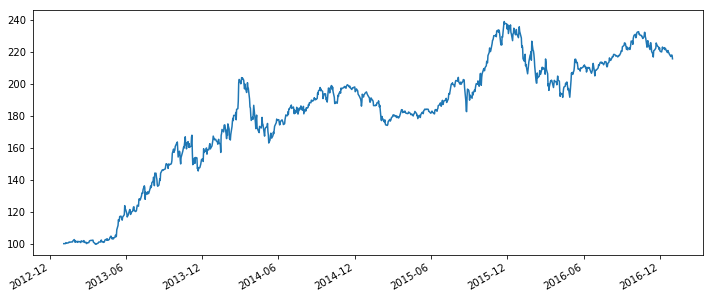

In [22]:
result.v.plot(figsize=(12,5))

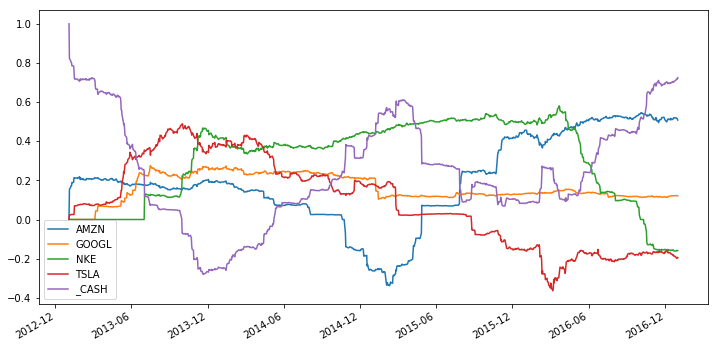

In [23]:
result.w.plot(figsize=(12,6))